In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        {'sp':'normalized','im':'t1','fe':['b25'],'fi':['targets']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_0_1_0_0_1_t1t2_normalized_e_n_e_0_0_e_0_1_connectivity_data_norm_b25_targets_t1_normalized_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_0_42_n_normalized_08_05_06


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(772408, 2116)
(772408, 8)
validation
(101248, 2116)
(101248, 8)
test
(98888, 2116)
(98888, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 2116)]            0         


 dense (Dense)               (None, 1024)              2167808   


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 2857864 (10.90 MB)


Trainable params: 2857864 (10.90 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/78 [..............................] - ETA: 1:51 - loss: 2.5938 - STD: 0.0422 - MAE: 0.2285

 3/78 [>.............................] - ETA: 2s - loss: 2.0842 - STD: 0.0407 - MAE: 0.2140  

 5/78 [>.............................] - ETA: 2s - loss: 1.8116 - STD: 0.0828 - MAE: 0.1938

 7/78 [=>............................] - ETA: 2s - loss: 1.6867 - STD: 0.1233 - MAE: 0.1767

 9/78 [==>...........................] - ETA: 2s - loss: 1.6200 - STD: 0.1518 - MAE: 0.1646

11/78 [===>..........................] - ETA: 2s - loss: 1.5787 - STD: 0.1702 - MAE: 0.1568

13/78 [====>.........................] - ETA: 2s - loss: 1.5501 - STD: 0.1811 - MAE: 0.1524

15/78 [====>.........................] - ETA: 2s - loss: 1.5184 - STD: 0.1861 - MAE: 0.1498

17/78 [=====>........................] - ETA: 2s - loss: 1.4960 - STD: 0.1871 - MAE: 0.1491

19/78 [======>.......................] - ETA: 2s - loss: 1.4798 - STD: 0.1860 - MAE: 0.1494

21/78 [=======>......................] - ETA: 2s - loss: 1.4682 - STD: 0.1844 - MAE: 0.1500

23/78 [=======>......................] - ETA: 2s - loss: 1.4575 - STD: 0.1833 - MAE: 0.1503

25/78 [========>.....................] - ETA: 2s - loss: 1.4466 - STD: 0.1832 - MAE: 0.1502

27/78 [=========>....................] - ETA: 2s - loss: 1.4375 - STD: 0.1840 - MAE: 0.1498

29/78 [==========>...................] - ETA: 2s - loss: 1.4297 - STD: 0.1853 - MAE: 0.1492

31/78 [==========>...................] - ETA: 2s - loss: 1.4235 - STD: 0.1868 - MAE: 0.1486

32/78 [===========>..................] - ETA: 2s - loss: 1.4206 - STD: 0.1874 - MAE: 0.1483

33/78 [===========>..................] - ETA: 2s - loss: 1.4171 - STD: 0.1880 - MAE: 0.1480

34/78 [============>.................] - ETA: 2s - loss: 1.4164 - STD: 0.1885 - MAE: 0.1478

36/78 [============>.................] - ETA: 2s - loss: 1.4109 - STD: 0.1891 - MAE: 0.1475

38/78 [=============>................] - ETA: 2s - loss: 1.4059 - STD: 0.1894 - MAE: 0.1473

40/78 [==============>...............] - ETA: 2s - loss: 1.4019 - STD: 0.1893 - MAE: 0.1473

42/78 [===============>..............] - ETA: 2s - loss: 1.3980 - STD: 0.1890 - MAE: 0.1474

44/78 [===============>..............] - ETA: 1s - loss: 1.3942 - STD: 0.1887 - MAE: 0.1474

46/78 [================>.............] - ETA: 1s - loss: 1.3905 - STD: 0.1885 - MAE: 0.1475

48/78 [=================>............] - ETA: 1s - loss: 1.3874 - STD: 0.1885 - MAE: 0.1474

49/78 [=================>............] - ETA: 1s - loss: 1.3861 - STD: 0.1885 - MAE: 0.1474

51/78 [==================>...........] - ETA: 1s - loss: 1.3831 - STD: 0.1887 - MAE: 0.1473

53/78 [===================>..........] - ETA: 1s - loss: 1.3802 - STD: 0.1889 - MAE: 0.1472

55/78 [====================>.........] - ETA: 1s - loss: 1.3777 - STD: 0.1892 - MAE: 0.1470

57/78 [====================>.........] - ETA: 1s - loss: 1.3753 - STD: 0.1894 - MAE: 0.1469

59/78 [=====================>........] - ETA: 1s - loss: 1.3730 - STD: 0.1896 - MAE: 0.1468

61/78 [======================>.......] - ETA: 0s - loss: 1.3710 - STD: 0.1897 - MAE: 0.1467

63/78 [=======================>......] - ETA: 0s - loss: 1.3690 - STD: 0.1897 - MAE: 0.1467

65/78 [========================>.....] - ETA: 0s - loss: 1.3675 - STD: 0.1897 - MAE: 0.1467

67/78 [========================>.....] - ETA: 0s - loss: 1.3665 - STD: 0.1897 - MAE: 0.1467

69/78 [=========================>....] - ETA: 0s - loss: 1.3648 - STD: 0.1897 - MAE: 0.1466

70/78 [=========================>....] - ETA: 0s - loss: 1.3642 - STD: 0.1898 - MAE: 0.1466

71/78 [==========================>...] - ETA: 0s - loss: 1.3636 - STD: 0.1898 - MAE: 0.1466

73/78 [===========================>..] - ETA: 0s - loss: 1.3622 - STD: 0.1898 - MAE: 0.1466

75/78 [===========================>..] - ETA: 0s - loss: 1.3612 - STD: 0.1899 - MAE: 0.1466

77/78 [============================>.] - ETA: 0s - loss: 1.3601 - STD: 0.1899 - MAE: 0.1465

78/78 [==============================] - ETA: 0s - loss: 1.3594 - STD: 0.1900 - MAE: 0.1465

78/78 [==============================] - 7s 68ms/step - loss: 1.3594 - STD: 0.1900 - MAE: 0.1465 - val_loss: 1.2738 - val_STD: 0.1917 - val_MAE: 0.1449


Epoch 2/10000


 1/78 [..............................] - ETA: 6s - loss: 1.3083 - STD: 0.1917 - MAE: 0.1450

 3/78 [>.............................] - ETA: 3s - loss: 1.3138 - STD: 0.1917 - MAE: 0.1453

 5/78 [>.............................] - ETA: 3s - loss: 1.3146 - STD: 0.1915 - MAE: 0.1454

 6/78 [=>............................] - ETA: 3s - loss: 1.3128 - STD: 0.1914 - MAE: 0.1453

 8/78 [==>...........................] - ETA: 3s - loss: 1.3133 - STD: 0.1913 - MAE: 0.1454

10/78 [==>...........................] - ETA: 3s - loss: 1.3130 - STD: 0.1913 - MAE: 0.1453

12/78 [===>..........................] - ETA: 3s - loss: 1.3151 - STD: 0.1915 - MAE: 0.1453

14/78 [====>.........................] - ETA: 3s - loss: 1.3168 - STD: 0.1916 - MAE: 0.1454

16/78 [=====>........................] - ETA: 3s - loss: 1.3162 - STD: 0.1916 - MAE: 0.1454

18/78 [=====>........................] - ETA: 2s - loss: 1.3164 - STD: 0.1915 - MAE: 0.1454

20/78 [======>.......................] - ETA: 2s - loss: 1.3167 - STD: 0.1914 - MAE: 0.1455

22/78 [=======>......................] - ETA: 2s - loss: 1.3164 - STD: 0.1914 - MAE: 0.1455

24/78 [========>.....................] - ETA: 2s - loss: 1.3160 - STD: 0.1914 - MAE: 0.1455

26/78 [=========>....................] - ETA: 2s - loss: 1.3162 - STD: 0.1914 - MAE: 0.1454

28/78 [=========>....................] - ETA: 2s - loss: 1.3165 - STD: 0.1915 - MAE: 0.1454

29/78 [==========>...................] - ETA: 2s - loss: 1.3174 - STD: 0.1915 - MAE: 0.1455

31/78 [==========>...................] - ETA: 2s - loss: 1.3171 - STD: 0.1915 - MAE: 0.1455

33/78 [===========>..................] - ETA: 2s - loss: 1.3166 - STD: 0.1914 - MAE: 0.1455

35/78 [============>.................] - ETA: 2s - loss: 1.3162 - STD: 0.1914 - MAE: 0.1455

37/78 [=============>................] - ETA: 1s - loss: 1.3170 - STD: 0.1914 - MAE: 0.1455

39/78 [==============>...............] - ETA: 1s - loss: 1.3173 - STD: 0.1914 - MAE: 0.1455

41/78 [==============>...............] - ETA: 1s - loss: 1.3173 - STD: 0.1913 - MAE: 0.1455

42/78 [===============>..............] - ETA: 1s - loss: 1.3177 - STD: 0.1913 - MAE: 0.1456

44/78 [===============>..............] - ETA: 1s - loss: 1.3171 - STD: 0.1912 - MAE: 0.1456

46/78 [================>.............] - ETA: 1s - loss: 1.3170 - STD: 0.1912 - MAE: 0.1456

48/78 [=================>............] - ETA: 1s - loss: 1.3170 - STD: 0.1913 - MAE: 0.1455

50/78 [==================>...........] - ETA: 1s - loss: 1.3171 - STD: 0.1914 - MAE: 0.1455

52/78 [===================>..........] - ETA: 1s - loss: 1.3168 - STD: 0.1914 - MAE: 0.1455

54/78 [===================>..........] - ETA: 1s - loss: 1.3169 - STD: 0.1915 - MAE: 0.1455

56/78 [====================>.........] - ETA: 1s - loss: 1.3166 - STD: 0.1915 - MAE: 0.1454

58/78 [=====================>........] - ETA: 0s - loss: 1.3162 - STD: 0.1914 - MAE: 0.1454

60/78 [======================>.......] - ETA: 0s - loss: 1.3163 - STD: 0.1914 - MAE: 0.1454

62/78 [======================>.......] - ETA: 0s - loss: 1.3162 - STD: 0.1914 - MAE: 0.1454

64/78 [=======================>......] - ETA: 0s - loss: 1.3158 - STD: 0.1915 - MAE: 0.1454

66/78 [========================>.....] - ETA: 0s - loss: 1.3158 - STD: 0.1915 - MAE: 0.1454

68/78 [=========================>....] - ETA: 0s - loss: 1.3160 - STD: 0.1915 - MAE: 0.1454

70/78 [=========================>....] - ETA: 0s - loss: 1.3163 - STD: 0.1915 - MAE: 0.1454

72/78 [==========================>...] - ETA: 0s - loss: 1.3161 - STD: 0.1915 - MAE: 0.1454

74/78 [===========================>..] - ETA: 0s - loss: 1.3160 - STD: 0.1914 - MAE: 0.1454

76/78 [============================>.] - ETA: 0s - loss: 1.3161 - STD: 0.1914 - MAE: 0.1454

78/78 [==============================] - ETA: 0s - loss: 1.3159 - STD: 0.1914 - MAE: 0.1454

78/78 [==============================] - 4s 55ms/step - loss: 1.3159 - STD: 0.1914 - MAE: 0.1454 - val_loss: 1.2705 - val_STD: 0.1926 - val_MAE: 0.1444


Epoch 3/10000


 1/78 [..............................] - ETA: 6s - loss: 1.3245 - STD: 0.1926 - MAE: 0.1454

 3/78 [>.............................] - ETA: 3s - loss: 1.3212 - STD: 0.1923 - MAE: 0.1454

 5/78 [>.............................] - ETA: 3s - loss: 1.3143 - STD: 0.1919 - MAE: 0.1452

 6/78 [=>............................] - ETA: 3s - loss: 1.3148 - STD: 0.1918 - MAE: 0.1452

 8/78 [==>...........................] - ETA: 3s - loss: 1.3161 - STD: 0.1916 - MAE: 0.1454

10/78 [==>...........................] - ETA: 3s - loss: 1.3155 - STD: 0.1912 - MAE: 0.1455

12/78 [===>..........................] - ETA: 3s - loss: 1.3147 - STD: 0.1910 - MAE: 0.1456

14/78 [====>.........................] - ETA: 3s - loss: 1.3143 - STD: 0.1910 - MAE: 0.1455

16/78 [=====>........................] - ETA: 3s - loss: 1.3136 - STD: 0.1910 - MAE: 0.1455

18/78 [=====>........................] - ETA: 2s - loss: 1.3126 - STD: 0.1910 - MAE: 0.1455

20/78 [======>.......................] - ETA: 2s - loss: 1.3133 - STD: 0.1910 - MAE: 0.1455

22/78 [=======>......................] - ETA: 2s - loss: 1.3120 - STD: 0.1908 - MAE: 0.1455

24/78 [========>.....................] - ETA: 2s - loss: 1.3120 - STD: 0.1907 - MAE: 0.1456

26/78 [=========>....................] - ETA: 2s - loss: 1.3117 - STD: 0.1905 - MAE: 0.1457

28/78 [=========>....................] - ETA: 2s - loss: 1.3106 - STD: 0.1904 - MAE: 0.1457

30/78 [==========>...................] - ETA: 2s - loss: 1.3079 - STD: 0.1904 - MAE: 0.1456

32/78 [===========>..................] - ETA: 2s - loss: 1.3063 - STD: 0.1905 - MAE: 0.1455

34/78 [============>.................] - ETA: 2s - loss: 1.3046 - STD: 0.1907 - MAE: 0.1453

36/78 [============>.................] - ETA: 2s - loss: 1.3026 - STD: 0.1910 - MAE: 0.1451

37/78 [=============>................] - ETA: 1s - loss: 1.3016 - STD: 0.1910 - MAE: 0.1451

39/78 [==============>...............] - ETA: 1s - loss: 1.2992 - STD: 0.1911 - MAE: 0.1449

41/78 [==============>...............] - ETA: 1s - loss: 1.2974 - STD: 0.1911 - MAE: 0.1449

43/78 [===============>..............] - ETA: 1s - loss: 1.2952 - STD: 0.1913 - MAE: 0.1447

45/78 [================>.............] - ETA: 1s - loss: 1.2928 - STD: 0.1914 - MAE: 0.1446

47/78 [=================>............] - ETA: 1s - loss: 1.2903 - STD: 0.1917 - MAE: 0.1443

49/78 [=================>............] - ETA: 1s - loss: 1.2887 - STD: 0.1918 - MAE: 0.1442

51/78 [==================>...........] - ETA: 1s - loss: 1.2871 - STD: 0.1922 - MAE: 0.1441

53/78 [===================>..........] - ETA: 1s - loss: 1.2848 - STD: 0.1923 - MAE: 0.1439

55/78 [====================>.........] - ETA: 1s - loss: 1.2833 - STD: 0.1924 - MAE: 0.1438

57/78 [====================>.........] - ETA: 1s - loss: 1.2810 - STD: 0.1926 - MAE: 0.1437

59/78 [=====================>........] - ETA: 0s - loss: 1.2785 - STD: 0.1927 - MAE: 0.1436

61/78 [======================>.......] - ETA: 0s - loss: 1.2765 - STD: 0.1929 - MAE: 0.1434

63/78 [=======================>......] - ETA: 0s - loss: 1.2746 - STD: 0.1933 - MAE: 0.1432

65/78 [========================>.....] - ETA: 0s - loss: 1.2725 - STD: 0.1933 - MAE: 0.1431

67/78 [========================>.....] - ETA: 0s - loss: 1.2705 - STD: 0.1936 - MAE: 0.1430

69/78 [=========================>....] - ETA: 0s - loss: 1.2682 - STD: 0.1936 - MAE: 0.1429

71/78 [==========================>...] - ETA: 0s - loss: 1.2657 - STD: 0.1938 - MAE: 0.1427

73/78 [===========================>..] - ETA: 0s - loss: 1.2637 - STD: 0.1939 - MAE: 0.1426

75/78 [===========================>..] - ETA: 0s - loss: 1.2619 - STD: 0.1941 - MAE: 0.1425

77/78 [============================>.] - ETA: 0s - loss: 1.2595 - STD: 0.1943 - MAE: 0.1424

78/78 [==============================] - 4s 55ms/step - loss: 1.2581 - STD: 0.1943 - MAE: 0.1423 - val_loss: 1.1511 - val_STD: 0.1950 - val_MAE: 0.1399


Epoch 4/10000


 1/78 [..............................] - ETA: 6s - loss: 1.1785 - STD: 0.1992 - MAE: 0.1382

 3/78 [>.............................] - ETA: 3s - loss: 1.1695 - STD: 0.1988 - MAE: 0.1381

 5/78 [>.............................] - ETA: 3s - loss: 1.1747 - STD: 0.1998 - MAE: 0.1378

 7/78 [=>............................] - ETA: 3s - loss: 1.1752 - STD: 0.2009 - MAE: 0.1374

 9/78 [==>...........................] - ETA: 3s - loss: 1.1735 - STD: 0.1998 - MAE: 0.1379

11/78 [===>..........................] - ETA: 3s - loss: 1.1722 - STD: 0.2008 - MAE: 0.1375

13/78 [====>.........................] - ETA: 3s - loss: 1.1712 - STD: 0.2004 - MAE: 0.1377

14/78 [====>.........................] - ETA: 3s - loss: 1.1699 - STD: 0.2008 - MAE: 0.1375

16/78 [=====>........................] - ETA: 3s - loss: 1.1664 - STD: 0.2003 - MAE: 0.1375

18/78 [=====>........................] - ETA: 2s - loss: 1.1645 - STD: 0.2007 - MAE: 0.1373

19/78 [======>.......................] - ETA: 2s - loss: 1.1636 - STD: 0.2006 - MAE: 0.1374

21/78 [=======>......................] - ETA: 2s - loss: 1.1612 - STD: 0.2009 - MAE: 0.1372

23/78 [=======>......................] - ETA: 2s - loss: 1.1601 - STD: 0.2008 - MAE: 0.1372

25/78 [========>.....................] - ETA: 2s - loss: 1.1587 - STD: 0.2009 - MAE: 0.1371

27/78 [=========>....................] - ETA: 2s - loss: 1.1575 - STD: 0.2008 - MAE: 0.1372

29/78 [==========>...................] - ETA: 2s - loss: 1.1566 - STD: 0.2008 - MAE: 0.1372

31/78 [==========>...................] - ETA: 2s - loss: 1.1546 - STD: 0.2008 - MAE: 0.1371

33/78 [===========>..................] - ETA: 2s - loss: 1.1535 - STD: 0.2009 - MAE: 0.1370

35/78 [============>.................] - ETA: 2s - loss: 1.1515 - STD: 0.2011 - MAE: 0.1369

37/78 [=============>................] - ETA: 2s - loss: 1.1499 - STD: 0.2013 - MAE: 0.1368

39/78 [==============>...............] - ETA: 1s - loss: 1.1478 - STD: 0.2014 - MAE: 0.1367

41/78 [==============>...............] - ETA: 1s - loss: 1.1465 - STD: 0.2014 - MAE: 0.1366

43/78 [===============>..............] - ETA: 1s - loss: 1.1456 - STD: 0.2014 - MAE: 0.1366

44/78 [===============>..............] - ETA: 1s - loss: 1.1452 - STD: 0.2015 - MAE: 0.1365

46/78 [================>.............] - ETA: 1s - loss: 1.1448 - STD: 0.2015 - MAE: 0.1366

47/78 [=================>............] - ETA: 1s - loss: 1.1443 - STD: 0.2016 - MAE: 0.1365

49/78 [=================>............] - ETA: 1s - loss: 1.1433 - STD: 0.2015 - MAE: 0.1365

51/78 [==================>...........] - ETA: 1s - loss: 1.1420 - STD: 0.2017 - MAE: 0.1364

53/78 [===================>..........] - ETA: 1s - loss: 1.1415 - STD: 0.2016 - MAE: 0.1365

55/78 [====================>.........] - ETA: 1s - loss: 1.1405 - STD: 0.2018 - MAE: 0.1364

57/78 [====================>.........] - ETA: 1s - loss: 1.1400 - STD: 0.2017 - MAE: 0.1364

59/78 [=====================>........] - ETA: 0s - loss: 1.1392 - STD: 0.2019 - MAE: 0.1363

61/78 [======================>.......] - ETA: 0s - loss: 1.1374 - STD: 0.2019 - MAE: 0.1362

63/78 [=======================>......] - ETA: 0s - loss: 1.1365 - STD: 0.2020 - MAE: 0.1361

64/78 [=======================>......] - ETA: 0s - loss: 1.1356 - STD: 0.2021 - MAE: 0.1361

66/78 [========================>.....] - ETA: 0s - loss: 1.1344 - STD: 0.2021 - MAE: 0.1360

68/78 [=========================>....] - ETA: 0s - loss: 1.1332 - STD: 0.2023 - MAE: 0.1359

70/78 [=========================>....] - ETA: 0s - loss: 1.1320 - STD: 0.2023 - MAE: 0.1359

72/78 [==========================>...] - ETA: 0s - loss: 1.1306 - STD: 0.2023 - MAE: 0.1358

74/78 [===========================>..] - ETA: 0s - loss: 1.1296 - STD: 0.2023 - MAE: 0.1358

76/78 [============================>.] - ETA: 0s - loss: 1.1284 - STD: 0.2024 - MAE: 0.1357

78/78 [==============================] - ETA: 0s - loss: 1.1272 - STD: 0.2025 - MAE: 0.1356

78/78 [==============================] - 4s 55ms/step - loss: 1.1272 - STD: 0.2025 - MAE: 0.1356 - val_loss: 1.0757 - val_STD: 0.2030 - val_MAE: 0.1341


Epoch 5/10000


 1/78 [..............................] - ETA: 6s - loss: 1.0837 - STD: 0.2064 - MAE: 0.1321

 3/78 [>.............................] - ETA: 3s - loss: 1.0828 - STD: 0.2057 - MAE: 0.1325

 5/78 [>.............................] - ETA: 3s - loss: 1.0788 - STD: 0.2064 - MAE: 0.1320

 7/78 [=>............................] - ETA: 3s - loss: 1.0809 - STD: 0.2061 - MAE: 0.1323

 9/78 [==>...........................] - ETA: 3s - loss: 1.0814 - STD: 0.2059 - MAE: 0.1324

11/78 [===>..........................] - ETA: 3s - loss: 1.0809 - STD: 0.2058 - MAE: 0.1325

12/78 [===>..........................] - ETA: 3s - loss: 1.0803 - STD: 0.2056 - MAE: 0.1325

14/78 [====>.........................] - ETA: 3s - loss: 1.0777 - STD: 0.2056 - MAE: 0.1324

16/78 [=====>........................] - ETA: 3s - loss: 1.0755 - STD: 0.2057 - MAE: 0.1322

18/78 [=====>........................] - ETA: 2s - loss: 1.0745 - STD: 0.2061 - MAE: 0.1320

20/78 [======>.......................] - ETA: 2s - loss: 1.0742 - STD: 0.2064 - MAE: 0.1319

22/78 [=======>......................] - ETA: 2s - loss: 1.0723 - STD: 0.2066 - MAE: 0.1317

24/78 [========>.....................] - ETA: 2s - loss: 1.0706 - STD: 0.2066 - MAE: 0.1316

25/78 [========>.....................] - ETA: 2s - loss: 1.0696 - STD: 0.2068 - MAE: 0.1315

27/78 [=========>....................] - ETA: 2s - loss: 1.0689 - STD: 0.2069 - MAE: 0.1314

28/78 [=========>....................] - ETA: 2s - loss: 1.0688 - STD: 0.2069 - MAE: 0.1314

29/78 [==========>...................] - ETA: 2s - loss: 1.0682 - STD: 0.2070 - MAE: 0.1314

31/78 [==========>...................] - ETA: 2s - loss: 1.0682 - STD: 0.2072 - MAE: 0.1313

32/78 [===========>..................] - ETA: 2s - loss: 1.0674 - STD: 0.2071 - MAE: 0.1313

34/78 [============>.................] - ETA: 2s - loss: 1.0659 - STD: 0.2072 - MAE: 0.1312

36/78 [============>.................] - ETA: 2s - loss: 1.0643 - STD: 0.2074 - MAE: 0.1310

37/78 [=============>................] - ETA: 2s - loss: 1.0639 - STD: 0.2075 - MAE: 0.1309

39/78 [==============>...............] - ETA: 1s - loss: 1.0627 - STD: 0.2076 - MAE: 0.1308

40/78 [==============>...............] - ETA: 1s - loss: 1.0621 - STD: 0.2077 - MAE: 0.1308

42/78 [===============>..............] - ETA: 1s - loss: 1.0613 - STD: 0.2078 - MAE: 0.1307

43/78 [===============>..............] - ETA: 1s - loss: 1.0605 - STD: 0.2078 - MAE: 0.1307

45/78 [================>.............] - ETA: 1s - loss: 1.0598 - STD: 0.2079 - MAE: 0.1306

47/78 [=================>............] - ETA: 1s - loss: 1.0598 - STD: 0.2080 - MAE: 0.1305

49/78 [=================>............] - ETA: 1s - loss: 1.0587 - STD: 0.2083 - MAE: 0.1303

51/78 [==================>...........] - ETA: 1s - loss: 1.0579 - STD: 0.2083 - MAE: 0.1303

53/78 [===================>..........] - ETA: 1s - loss: 1.0574 - STD: 0.2085 - MAE: 0.1302

55/78 [====================>.........] - ETA: 1s - loss: 1.0564 - STD: 0.2085 - MAE: 0.1301

56/78 [====================>.........] - ETA: 1s - loss: 1.0559 - STD: 0.2086 - MAE: 0.1301

58/78 [=====================>........] - ETA: 0s - loss: 1.0546 - STD: 0.2088 - MAE: 0.1299

60/78 [======================>.......] - ETA: 0s - loss: 1.0535 - STD: 0.2088 - MAE: 0.1299

61/78 [======================>.......] - ETA: 0s - loss: 1.0532 - STD: 0.2089 - MAE: 0.1298

63/78 [=======================>......] - ETA: 0s - loss: 1.0520 - STD: 0.2090 - MAE: 0.1297

65/78 [========================>.....] - ETA: 0s - loss: 1.0509 - STD: 0.2091 - MAE: 0.1296

67/78 [========================>.....] - ETA: 0s - loss: 1.0501 - STD: 0.2092 - MAE: 0.1295

69/78 [=========================>....] - ETA: 0s - loss: 1.0489 - STD: 0.2094 - MAE: 0.1294

71/78 [==========================>...] - ETA: 0s - loss: 1.0479 - STD: 0.2095 - MAE: 0.1293

73/78 [===========================>..] - ETA: 0s - loss: 1.0467 - STD: 0.2096 - MAE: 0.1292

75/78 [===========================>..] - ETA: 0s - loss: 1.0456 - STD: 0.2097 - MAE: 0.1290

77/78 [============================>.] - ETA: 0s - loss: 1.0444 - STD: 0.2098 - MAE: 0.1290

78/78 [==============================] - 4s 55ms/step - loss: 1.0438 - STD: 0.2099 - MAE: 0.1289 - val_loss: 0.9960 - val_STD: 0.2071 - val_MAE: 0.1277


Epoch 6/10000


 1/78 [..............................] - ETA: 6s - loss: 1.0096 - STD: 0.2107 - MAE: 0.1268

 3/78 [>.............................] - ETA: 3s - loss: 0.9969 - STD: 0.2139 - MAE: 0.1249

 5/78 [>.............................] - ETA: 3s - loss: 0.9965 - STD: 0.2150 - MAE: 0.1245

 7/78 [=>............................] - ETA: 3s - loss: 0.9953 - STD: 0.2144 - MAE: 0.1247

 9/78 [==>...........................] - ETA: 3s - loss: 0.9963 - STD: 0.2148 - MAE: 0.1246

10/78 [==>...........................] - ETA: 3s - loss: 0.9970 - STD: 0.2150 - MAE: 0.1246

12/78 [===>..........................] - ETA: 3s - loss: 0.9943 - STD: 0.2144 - MAE: 0.1247

14/78 [====>.........................] - ETA: 3s - loss: 0.9928 - STD: 0.2150 - MAE: 0.1244

16/78 [=====>........................] - ETA: 3s - loss: 0.9902 - STD: 0.2152 - MAE: 0.1242

18/78 [=====>........................] - ETA: 2s - loss: 0.9894 - STD: 0.2148 - MAE: 0.1243

20/78 [======>.......................] - ETA: 2s - loss: 0.9888 - STD: 0.2155 - MAE: 0.1240

22/78 [=======>......................] - ETA: 2s - loss: 0.9884 - STD: 0.2154 - MAE: 0.1240

24/78 [========>.....................] - ETA: 2s - loss: 0.9878 - STD: 0.2156 - MAE: 0.1239

26/78 [=========>....................] - ETA: 2s - loss: 0.9867 - STD: 0.2160 - MAE: 0.1237

28/78 [=========>....................] - ETA: 2s - loss: 0.9856 - STD: 0.2160 - MAE: 0.1236

30/78 [==========>...................] - ETA: 2s - loss: 0.9852 - STD: 0.2160 - MAE: 0.1236

32/78 [===========>..................] - ETA: 2s - loss: 0.9841 - STD: 0.2161 - MAE: 0.1235

34/78 [============>.................] - ETA: 2s - loss: 0.9826 - STD: 0.2161 - MAE: 0.1235

36/78 [============>.................] - ETA: 2s - loss: 0.9812 - STD: 0.2163 - MAE: 0.1233

38/78 [=============>................] - ETA: 1s - loss: 0.9797 - STD: 0.2161 - MAE: 0.1233

40/78 [==============>...............] - ETA: 1s - loss: 0.9782 - STD: 0.2165 - MAE: 0.1231

42/78 [===============>..............] - ETA: 1s - loss: 0.9775 - STD: 0.2163 - MAE: 0.1231

44/78 [===============>..............] - ETA: 1s - loss: 0.9760 - STD: 0.2166 - MAE: 0.1229

45/78 [================>.............] - ETA: 1s - loss: 0.9749 - STD: 0.2166 - MAE: 0.1229

46/78 [================>.............] - ETA: 1s - loss: 0.9745 - STD: 0.2167 - MAE: 0.1228

47/78 [=================>............] - ETA: 1s - loss: 0.9741 - STD: 0.2166 - MAE: 0.1228

49/78 [=================>............] - ETA: 1s - loss: 0.9723 - STD: 0.2168 - MAE: 0.1226

51/78 [==================>...........] - ETA: 1s - loss: 0.9718 - STD: 0.2169 - MAE: 0.1226

53/78 [===================>..........] - ETA: 1s - loss: 0.9706 - STD: 0.2170 - MAE: 0.1225

55/78 [====================>.........] - ETA: 1s - loss: 0.9692 - STD: 0.2170 - MAE: 0.1224

57/78 [====================>.........] - ETA: 1s - loss: 0.9672 - STD: 0.2173 - MAE: 0.1222

59/78 [=====================>........] - ETA: 0s - loss: 0.9658 - STD: 0.2173 - MAE: 0.1221

60/78 [======================>.......] - ETA: 0s - loss: 0.9654 - STD: 0.2175 - MAE: 0.1220

62/78 [======================>.......] - ETA: 0s - loss: 0.9640 - STD: 0.2175 - MAE: 0.1220

63/78 [=======================>......] - ETA: 0s - loss: 0.9633 - STD: 0.2176 - MAE: 0.1219

65/78 [========================>.....] - ETA: 0s - loss: 0.9621 - STD: 0.2176 - MAE: 0.1218

66/78 [========================>.....] - ETA: 0s - loss: 0.9614 - STD: 0.2176 - MAE: 0.1218

68/78 [=========================>....] - ETA: 0s - loss: 0.9601 - STD: 0.2178 - MAE: 0.1216

70/78 [=========================>....] - ETA: 0s - loss: 0.9591 - STD: 0.2178 - MAE: 0.1216

72/78 [==========================>...] - ETA: 0s - loss: 0.9578 - STD: 0.2180 - MAE: 0.1214

74/78 [===========================>..] - ETA: 0s - loss: 0.9562 - STD: 0.2181 - MAE: 0.1213

75/78 [===========================>..] - ETA: 0s - loss: 0.9555 - STD: 0.2183 - MAE: 0.1212

76/78 [============================>.] - ETA: 0s - loss: 0.9548 - STD: 0.2182 - MAE: 0.1212

77/78 [============================>.] - ETA: 0s - loss: 0.9540 - STD: 0.2183 - MAE: 0.1211

78/78 [==============================] - 4s 56ms/step - loss: 0.9532 - STD: 0.2185 - MAE: 0.1210 - val_loss: 0.9520 - val_STD: 0.2153 - val_MAE: 0.1218


Epoch 7/10000


 1/78 [..............................] - ETA: 6s - loss: 0.9020 - STD: 0.2197 - MAE: 0.1181

 2/78 [..............................] - ETA: 4s - loss: 0.8957 - STD: 0.2237 - MAE: 0.1161

 4/78 [>.............................] - ETA: 3s - loss: 0.9048 - STD: 0.2232 - MAE: 0.1167

 6/78 [=>............................] - ETA: 3s - loss: 0.9029 - STD: 0.2238 - MAE: 0.1164

 8/78 [==>...........................] - ETA: 3s - loss: 0.8993 - STD: 0.2232 - MAE: 0.1165

10/78 [==>...........................] - ETA: 3s - loss: 0.8934 - STD: 0.2244 - MAE: 0.1156

12/78 [===>..........................] - ETA: 3s - loss: 0.8922 - STD: 0.2237 - MAE: 0.1159

14/78 [====>.........................] - ETA: 3s - loss: 0.8927 - STD: 0.2245 - MAE: 0.1156

16/78 [=====>........................] - ETA: 3s - loss: 0.8911 - STD: 0.2248 - MAE: 0.1154

18/78 [=====>........................] - ETA: 2s - loss: 0.8915 - STD: 0.2246 - MAE: 0.1155

19/78 [======>.......................] - ETA: 2s - loss: 0.8905 - STD: 0.2245 - MAE: 0.1155

20/78 [======>.......................] - ETA: 2s - loss: 0.8902 - STD: 0.2251 - MAE: 0.1152

22/78 [=======>......................] - ETA: 2s - loss: 0.8894 - STD: 0.2250 - MAE: 0.1152

24/78 [========>.....................] - ETA: 2s - loss: 0.8892 - STD: 0.2253 - MAE: 0.1151

25/78 [========>.....................] - ETA: 2s - loss: 0.8884 - STD: 0.2251 - MAE: 0.1151

26/78 [=========>....................] - ETA: 2s - loss: 0.8878 - STD: 0.2255 - MAE: 0.1149

27/78 [=========>....................] - ETA: 2s - loss: 0.8879 - STD: 0.2255 - MAE: 0.1149

29/78 [==========>...................] - ETA: 2s - loss: 0.8873 - STD: 0.2255 - MAE: 0.1149

30/78 [==========>...................] - ETA: 2s - loss: 0.8867 - STD: 0.2257 - MAE: 0.1148

32/78 [===========>..................] - ETA: 2s - loss: 0.8858 - STD: 0.2257 - MAE: 0.1148

34/78 [============>.................] - ETA: 2s - loss: 0.8846 - STD: 0.2260 - MAE: 0.1146

35/78 [============>.................] - ETA: 2s - loss: 0.8836 - STD: 0.2259 - MAE: 0.1146

36/78 [============>.................] - ETA: 2s - loss: 0.8830 - STD: 0.2258 - MAE: 0.1146

38/78 [=============>................] - ETA: 2s - loss: 0.8818 - STD: 0.2261 - MAE: 0.1144

39/78 [==============>...............] - ETA: 1s - loss: 0.8817 - STD: 0.2260 - MAE: 0.1144

40/78 [==============>...............] - ETA: 1s - loss: 0.8814 - STD: 0.2260 - MAE: 0.1144

41/78 [==============>...............] - ETA: 1s - loss: 0.8811 - STD: 0.2262 - MAE: 0.1143

43/78 [===============>..............] - ETA: 1s - loss: 0.8800 - STD: 0.2262 - MAE: 0.1142

45/78 [================>.............] - ETA: 1s - loss: 0.8791 - STD: 0.2263 - MAE: 0.1142

47/78 [=================>............] - ETA: 1s - loss: 0.8784 - STD: 0.2266 - MAE: 0.1140

49/78 [=================>............] - ETA: 1s - loss: 0.8775 - STD: 0.2267 - MAE: 0.1139

51/78 [==================>...........] - ETA: 1s - loss: 0.8763 - STD: 0.2267 - MAE: 0.1139

53/78 [===================>..........] - ETA: 1s - loss: 0.8764 - STD: 0.2269 - MAE: 0.1138

55/78 [====================>.........] - ETA: 1s - loss: 0.8754 - STD: 0.2272 - MAE: 0.1136

57/78 [====================>.........] - ETA: 1s - loss: 0.8751 - STD: 0.2271 - MAE: 0.1136

59/78 [=====================>........] - ETA: 0s - loss: 0.8748 - STD: 0.2273 - MAE: 0.1135

61/78 [======================>.......] - ETA: 0s - loss: 0.8740 - STD: 0.2273 - MAE: 0.1135

63/78 [=======================>......] - ETA: 0s - loss: 0.8735 - STD: 0.2275 - MAE: 0.1134

65/78 [========================>.....] - ETA: 0s - loss: 0.8733 - STD: 0.2275 - MAE: 0.1133

67/78 [========================>.....] - ETA: 0s - loss: 0.8726 - STD: 0.2277 - MAE: 0.1132

68/78 [=========================>....] - ETA: 0s - loss: 0.8722 - STD: 0.2277 - MAE: 0.1132

70/78 [=========================>....] - ETA: 0s - loss: 0.8716 - STD: 0.2278 - MAE: 0.1131

72/78 [==========================>...] - ETA: 0s - loss: 0.8712 - STD: 0.2279 - MAE: 0.1130

73/78 [===========================>..] - ETA: 0s - loss: 0.8707 - STD: 0.2279 - MAE: 0.1130

74/78 [===========================>..] - ETA: 0s - loss: 0.8703 - STD: 0.2279 - MAE: 0.1130

76/78 [============================>.] - ETA: 0s - loss: 0.8694 - STD: 0.2280 - MAE: 0.1129

78/78 [==============================] - ETA: 0s - loss: 0.8686 - STD: 0.2281 - MAE: 0.1128

78/78 [==============================] - 4s 57ms/step - loss: 0.8686 - STD: 0.2281 - MAE: 0.1128 - val_loss: 0.9074 - val_STD: 0.2313 - val_MAE: 0.1132


Epoch 8/10000


 1/78 [..............................] - ETA: 6s - loss: 0.8412 - STD: 0.2342 - MAE: 0.1089

 2/78 [..............................] - ETA: 3s - loss: 0.8428 - STD: 0.2272 - MAE: 0.1122

 4/78 [>.............................] - ETA: 3s - loss: 0.8372 - STD: 0.2330 - MAE: 0.1092

 6/78 [=>............................] - ETA: 3s - loss: 0.8459 - STD: 0.2318 - MAE: 0.1101

 8/78 [==>...........................] - ETA: 3s - loss: 0.8433 - STD: 0.2319 - MAE: 0.1099

 9/78 [==>...........................] - ETA: 3s - loss: 0.8454 - STD: 0.2328 - MAE: 0.1096

11/78 [===>..........................] - ETA: 3s - loss: 0.8448 - STD: 0.2314 - MAE: 0.1103

13/78 [====>.........................] - ETA: 3s - loss: 0.8446 - STD: 0.2322 - MAE: 0.1099

15/78 [====>.........................] - ETA: 3s - loss: 0.8435 - STD: 0.2322 - MAE: 0.1098

17/78 [=====>........................] - ETA: 2s - loss: 0.8425 - STD: 0.2324 - MAE: 0.1096

19/78 [======>.......................] - ETA: 2s - loss: 0.8421 - STD: 0.2321 - MAE: 0.1098

21/78 [=======>......................] - ETA: 2s - loss: 0.8421 - STD: 0.2323 - MAE: 0.1097

23/78 [=======>......................] - ETA: 2s - loss: 0.8411 - STD: 0.2321 - MAE: 0.1097

25/78 [========>.....................] - ETA: 2s - loss: 0.8395 - STD: 0.2320 - MAE: 0.1096

27/78 [=========>....................] - ETA: 2s - loss: 0.8393 - STD: 0.2321 - MAE: 0.1096

29/78 [==========>...................] - ETA: 2s - loss: 0.8393 - STD: 0.2322 - MAE: 0.1096

30/78 [==========>...................] - ETA: 2s - loss: 0.8386 - STD: 0.2320 - MAE: 0.1096

32/78 [===========>..................] - ETA: 2s - loss: 0.8373 - STD: 0.2324 - MAE: 0.1094

34/78 [============>.................] - ETA: 2s - loss: 0.8366 - STD: 0.2323 - MAE: 0.1094

35/78 [============>.................] - ETA: 2s - loss: 0.8364 - STD: 0.2326 - MAE: 0.1093

36/78 [============>.................] - ETA: 2s - loss: 0.8369 - STD: 0.2323 - MAE: 0.1094

37/78 [=============>................] - ETA: 2s - loss: 0.8369 - STD: 0.2324 - MAE: 0.1094

38/78 [=============>................] - ETA: 2s - loss: 0.8362 - STD: 0.2324 - MAE: 0.1093

40/78 [==============>...............] - ETA: 1s - loss: 0.8363 - STD: 0.2327 - MAE: 0.1092

42/78 [===============>..............] - ETA: 1s - loss: 0.8363 - STD: 0.2323 - MAE: 0.1094

44/78 [===============>..............] - ETA: 1s - loss: 0.8365 - STD: 0.2327 - MAE: 0.1092

46/78 [================>.............] - ETA: 1s - loss: 0.8365 - STD: 0.2325 - MAE: 0.1093

48/78 [=================>............] - ETA: 1s - loss: 0.8369 - STD: 0.2326 - MAE: 0.1092

49/78 [=================>............] - ETA: 1s - loss: 0.8367 - STD: 0.2326 - MAE: 0.1092

51/78 [==================>...........] - ETA: 1s - loss: 0.8361 - STD: 0.2326 - MAE: 0.1092

52/78 [===================>..........] - ETA: 1s - loss: 0.8363 - STD: 0.2327 - MAE: 0.1092

53/78 [===================>..........] - ETA: 1s - loss: 0.8361 - STD: 0.2326 - MAE: 0.1092

54/78 [===================>..........] - ETA: 1s - loss: 0.8361 - STD: 0.2326 - MAE: 0.1092

56/78 [====================>.........] - ETA: 1s - loss: 0.8360 - STD: 0.2327 - MAE: 0.1091

58/78 [=====================>........] - ETA: 0s - loss: 0.8361 - STD: 0.2327 - MAE: 0.1091

60/78 [======================>.......] - ETA: 0s - loss: 0.8361 - STD: 0.2328 - MAE: 0.1091

62/78 [======================>.......] - ETA: 0s - loss: 0.8361 - STD: 0.2328 - MAE: 0.1091

64/78 [=======================>......] - ETA: 0s - loss: 0.8363 - STD: 0.2329 - MAE: 0.1090

66/78 [========================>.....] - ETA: 0s - loss: 0.8360 - STD: 0.2329 - MAE: 0.1090

68/78 [=========================>....] - ETA: 0s - loss: 0.8357 - STD: 0.2329 - MAE: 0.1090

70/78 [=========================>....] - ETA: 0s - loss: 0.8353 - STD: 0.2331 - MAE: 0.1089

71/78 [==========================>...] - ETA: 0s - loss: 0.8353 - STD: 0.2330 - MAE: 0.1090

73/78 [===========================>..] - ETA: 0s - loss: 0.8346 - STD: 0.2332 - MAE: 0.1088

75/78 [===========================>..] - ETA: 0s - loss: 0.8341 - STD: 0.2332 - MAE: 0.1088

77/78 [============================>.] - ETA: 0s - loss: 0.8341 - STD: 0.2332 - MAE: 0.1088

78/78 [==============================] - 4s 56ms/step - loss: 0.8341 - STD: 0.2332 - MAE: 0.1088 - val_loss: 0.8954 - val_STD: 0.2342 - val_MAE: 0.1110


Epoch 9/10000


 1/78 [..............................] - ETA: 6s - loss: 0.8164 - STD: 0.2376 - MAE: 0.1060

 3/78 [>.............................] - ETA: 3s - loss: 0.8193 - STD: 0.2337 - MAE: 0.1077

 5/78 [>.............................] - ETA: 3s - loss: 0.8203 - STD: 0.2344 - MAE: 0.1076

 7/78 [=>............................] - ETA: 3s - loss: 0.8206 - STD: 0.2325 - MAE: 0.1084

 9/78 [==>...........................] - ETA: 3s - loss: 0.8194 - STD: 0.2338 - MAE: 0.1078

10/78 [==>...........................] - ETA: 3s - loss: 0.8181 - STD: 0.2340 - MAE: 0.1076

11/78 [===>..........................] - ETA: 3s - loss: 0.8178 - STD: 0.2338 - MAE: 0.1076

13/78 [====>.........................] - ETA: 3s - loss: 0.8169 - STD: 0.2344 - MAE: 0.1073

15/78 [====>.........................] - ETA: 3s - loss: 0.8174 - STD: 0.2343 - MAE: 0.1074

16/78 [=====>........................] - ETA: 3s - loss: 0.8167 - STD: 0.2343 - MAE: 0.1073

18/78 [=====>........................] - ETA: 3s - loss: 0.8168 - STD: 0.2349 - MAE: 0.1070

19/78 [======>.......................] - ETA: 3s - loss: 0.8172 - STD: 0.2345 - MAE: 0.1073

21/78 [=======>......................] - ETA: 2s - loss: 0.8165 - STD: 0.2347 - MAE: 0.1072

23/78 [=======>......................] - ETA: 2s - loss: 0.8173 - STD: 0.2348 - MAE: 0.1072

24/78 [========>.....................] - ETA: 2s - loss: 0.8177 - STD: 0.2344 - MAE: 0.1074

25/78 [========>.....................] - ETA: 2s - loss: 0.8172 - STD: 0.2344 - MAE: 0.1074

26/78 [=========>....................] - ETA: 2s - loss: 0.8178 - STD: 0.2350 - MAE: 0.1071

27/78 [=========>....................] - ETA: 2s - loss: 0.8177 - STD: 0.2345 - MAE: 0.1074

28/78 [=========>....................] - ETA: 2s - loss: 0.8177 - STD: 0.2344 - MAE: 0.1074

29/78 [==========>...................] - ETA: 2s - loss: 0.8171 - STD: 0.2347 - MAE: 0.1072

30/78 [==========>...................] - ETA: 2s - loss: 0.8170 - STD: 0.2348 - MAE: 0.1072

31/78 [==========>...................] - ETA: 2s - loss: 0.8166 - STD: 0.2348 - MAE: 0.1072

32/78 [===========>..................] - ETA: 2s - loss: 0.8162 - STD: 0.2347 - MAE: 0.1072

33/78 [===========>..................] - ETA: 2s - loss: 0.8159 - STD: 0.2346 - MAE: 0.1072

34/78 [============>.................] - ETA: 2s - loss: 0.8153 - STD: 0.2350 - MAE: 0.1070

35/78 [============>.................] - ETA: 2s - loss: 0.8148 - STD: 0.2350 - MAE: 0.1070

36/78 [============>.................] - ETA: 2s - loss: 0.8144 - STD: 0.2349 - MAE: 0.1070

37/78 [=============>................] - ETA: 2s - loss: 0.8139 - STD: 0.2350 - MAE: 0.1069

38/78 [=============>................] - ETA: 2s - loss: 0.8139 - STD: 0.2351 - MAE: 0.1069

39/78 [==============>...............] - ETA: 2s - loss: 0.8133 - STD: 0.2351 - MAE: 0.1069

40/78 [==============>...............] - ETA: 1s - loss: 0.8130 - STD: 0.2351 - MAE: 0.1068

41/78 [==============>...............] - ETA: 1s - loss: 0.8127 - STD: 0.2351 - MAE: 0.1068

42/78 [===============>..............] - ETA: 1s - loss: 0.8122 - STD: 0.2352 - MAE: 0.1068

43/78 [===============>..............] - ETA: 1s - loss: 0.8116 - STD: 0.2353 - MAE: 0.1066

44/78 [===============>..............] - ETA: 1s - loss: 0.8115 - STD: 0.2352 - MAE: 0.1067

45/78 [================>.............] - ETA: 1s - loss: 0.8113 - STD: 0.2352 - MAE: 0.1067

46/78 [================>.............] - ETA: 1s - loss: 0.8111 - STD: 0.2354 - MAE: 0.1066

47/78 [=================>............] - ETA: 1s - loss: 0.8105 - STD: 0.2354 - MAE: 0.1065

48/78 [=================>............] - ETA: 1s - loss: 0.8103 - STD: 0.2354 - MAE: 0.1065

49/78 [=================>............] - ETA: 1s - loss: 0.8098 - STD: 0.2354 - MAE: 0.1065

50/78 [==================>...........] - ETA: 1s - loss: 0.8095 - STD: 0.2355 - MAE: 0.1064

51/78 [==================>...........] - ETA: 1s - loss: 0.8096 - STD: 0.2355 - MAE: 0.1064

52/78 [===================>..........] - ETA: 1s - loss: 0.8092 - STD: 0.2355 - MAE: 0.1064

53/78 [===================>..........] - ETA: 1s - loss: 0.8091 - STD: 0.2354 - MAE: 0.1064

54/78 [===================>..........] - ETA: 1s - loss: 0.8087 - STD: 0.2356 - MAE: 0.1063

55/78 [====================>.........] - ETA: 1s - loss: 0.8084 - STD: 0.2356 - MAE: 0.1063

56/78 [====================>.........] - ETA: 1s - loss: 0.8086 - STD: 0.2356 - MAE: 0.1063

57/78 [====================>.........] - ETA: 1s - loss: 0.8088 - STD: 0.2354 - MAE: 0.1064

58/78 [=====================>........] - ETA: 1s - loss: 0.8086 - STD: 0.2357 - MAE: 0.1063

59/78 [=====================>........] - ETA: 1s - loss: 0.8084 - STD: 0.2357 - MAE: 0.1063

60/78 [======================>.......] - ETA: 0s - loss: 0.8082 - STD: 0.2356 - MAE: 0.1063

61/78 [======================>.......] - ETA: 0s - loss: 0.8086 - STD: 0.2358 - MAE: 0.1063

62/78 [======================>.......] - ETA: 0s - loss: 0.8084 - STD: 0.2357 - MAE: 0.1063

63/78 [=======================>......] - ETA: 0s - loss: 0.8082 - STD: 0.2357 - MAE: 0.1063

64/78 [=======================>......] - ETA: 0s - loss: 0.8081 - STD: 0.2359 - MAE: 0.1062

65/78 [========================>.....] - ETA: 0s - loss: 0.8080 - STD: 0.2358 - MAE: 0.1063

66/78 [========================>.....] - ETA: 0s - loss: 0.8076 - STD: 0.2358 - MAE: 0.1062

67/78 [========================>.....] - ETA: 0s - loss: 0.8075 - STD: 0.2360 - MAE: 0.1062

68/78 [=========================>....] - ETA: 0s - loss: 0.8074 - STD: 0.2359 - MAE: 0.1062

69/78 [=========================>....] - ETA: 0s - loss: 0.8074 - STD: 0.2358 - MAE: 0.1062

71/78 [==========================>...] - ETA: 0s - loss: 0.8076 - STD: 0.2359 - MAE: 0.1062

72/78 [==========================>...] - ETA: 0s - loss: 0.8075 - STD: 0.2359 - MAE: 0.1062

73/78 [===========================>..] - ETA: 0s - loss: 0.8075 - STD: 0.2360 - MAE: 0.1062

74/78 [===========================>..] - ETA: 0s - loss: 0.8072 - STD: 0.2359 - MAE: 0.1062

75/78 [===========================>..] - ETA: 0s - loss: 0.8072 - STD: 0.2360 - MAE: 0.1061

76/78 [============================>.] - ETA: 0s - loss: 0.8069 - STD: 0.2360 - MAE: 0.1061

77/78 [============================>.] - ETA: 0s - loss: 0.8067 - STD: 0.2359 - MAE: 0.1061

78/78 [==============================] - ETA: 0s - loss: 0.8066 - STD: 0.2360 - MAE: 0.1061

78/78 [==============================] - 5s 61ms/step - loss: 0.8066 - STD: 0.2360 - MAE: 0.1061 - val_loss: 0.8745 - val_STD: 0.2361 - val_MAE: 0.1097


Epoch 10/10000


 1/78 [..............................] - ETA: 7s - loss: 0.7834 - STD: 0.2395 - MAE: 0.1035

 2/78 [..............................] - ETA: 4s - loss: 0.7893 - STD: 0.2365 - MAE: 0.1051

 3/78 [>.............................] - ETA: 4s - loss: 0.7918 - STD: 0.2371 - MAE: 0.1050

 4/78 [>.............................] - ETA: 3s - loss: 0.7915 - STD: 0.2366 - MAE: 0.1052

 5/78 [>.............................] - ETA: 3s - loss: 0.7932 - STD: 0.2371 - MAE: 0.1050

 6/78 [=>............................] - ETA: 3s - loss: 0.7924 - STD: 0.2369 - MAE: 0.1050

 7/78 [=>............................] - ETA: 3s - loss: 0.7898 - STD: 0.2372 - MAE: 0.1047

 8/78 [==>...........................] - ETA: 3s - loss: 0.7898 - STD: 0.2372 - MAE: 0.1047

 9/78 [==>...........................] - ETA: 3s - loss: 0.7902 - STD: 0.2373 - MAE: 0.1046

10/78 [==>...........................] - ETA: 3s - loss: 0.7897 - STD: 0.2372 - MAE: 0.1047

11/78 [===>..........................] - ETA: 3s - loss: 0.7899 - STD: 0.2370 - MAE: 0.1048

12/78 [===>..........................] - ETA: 3s - loss: 0.7907 - STD: 0.2374 - MAE: 0.1046

13/78 [====>.........................] - ETA: 3s - loss: 0.7900 - STD: 0.2373 - MAE: 0.1046

14/78 [====>.........................] - ETA: 3s - loss: 0.7894 - STD: 0.2373 - MAE: 0.1046

15/78 [====>.........................] - ETA: 3s - loss: 0.7885 - STD: 0.2375 - MAE: 0.1044

16/78 [=====>........................] - ETA: 3s - loss: 0.7891 - STD: 0.2374 - MAE: 0.1045

17/78 [=====>........................] - ETA: 3s - loss: 0.7889 - STD: 0.2378 - MAE: 0.1043

18/78 [=====>........................] - ETA: 3s - loss: 0.7888 - STD: 0.2376 - MAE: 0.1044

19/78 [======>.......................] - ETA: 3s - loss: 0.7889 - STD: 0.2374 - MAE: 0.1045

21/78 [=======>......................] - ETA: 3s - loss: 0.7887 - STD: 0.2376 - MAE: 0.1044

23/78 [=======>......................] - ETA: 2s - loss: 0.7877 - STD: 0.2377 - MAE: 0.1043

25/78 [========>.....................] - ETA: 2s - loss: 0.7875 - STD: 0.2378 - MAE: 0.1042

27/78 [=========>....................] - ETA: 2s - loss: 0.7879 - STD: 0.2377 - MAE: 0.1043

29/78 [==========>...................] - ETA: 2s - loss: 0.7870 - STD: 0.2376 - MAE: 0.1043

31/78 [==========>...................] - ETA: 2s - loss: 0.7876 - STD: 0.2378 - MAE: 0.1043

32/78 [===========>..................] - ETA: 2s - loss: 0.7879 - STD: 0.2380 - MAE: 0.1042

34/78 [============>.................] - ETA: 2s - loss: 0.7880 - STD: 0.2379 - MAE: 0.1043

36/78 [============>.................] - ETA: 2s - loss: 0.7886 - STD: 0.2380 - MAE: 0.1043

38/78 [=============>................] - ETA: 2s - loss: 0.7887 - STD: 0.2381 - MAE: 0.1042

40/78 [==============>...............] - ETA: 1s - loss: 0.7882 - STD: 0.2379 - MAE: 0.1043

42/78 [===============>..............] - ETA: 1s - loss: 0.7883 - STD: 0.2380 - MAE: 0.1042

43/78 [===============>..............] - ETA: 1s - loss: 0.7878 - STD: 0.2380 - MAE: 0.1042

44/78 [===============>..............] - ETA: 1s - loss: 0.7880 - STD: 0.2380 - MAE: 0.1042

45/78 [================>.............] - ETA: 1s - loss: 0.7878 - STD: 0.2380 - MAE: 0.1042

46/78 [================>.............] - ETA: 1s - loss: 0.7880 - STD: 0.2382 - MAE: 0.1041

47/78 [=================>............] - ETA: 1s - loss: 0.7883 - STD: 0.2380 - MAE: 0.1042

49/78 [=================>............] - ETA: 1s - loss: 0.7888 - STD: 0.2383 - MAE: 0.1041

50/78 [==================>...........] - ETA: 1s - loss: 0.7893 - STD: 0.2381 - MAE: 0.1042

52/78 [===================>..........] - ETA: 1s - loss: 0.7898 - STD: 0.2382 - MAE: 0.1042

53/78 [===================>..........] - ETA: 1s - loss: 0.7903 - STD: 0.2381 - MAE: 0.1043

55/78 [====================>.........] - ETA: 1s - loss: 0.7901 - STD: 0.2382 - MAE: 0.1042

57/78 [====================>.........] - ETA: 1s - loss: 0.7907 - STD: 0.2381 - MAE: 0.1043

59/78 [=====================>........] - ETA: 0s - loss: 0.7906 - STD: 0.2381 - MAE: 0.1043

60/78 [======================>.......] - ETA: 0s - loss: 0.7909 - STD: 0.2383 - MAE: 0.1043

62/78 [======================>.......] - ETA: 0s - loss: 0.7912 - STD: 0.2381 - MAE: 0.1044

64/78 [=======================>......] - ETA: 0s - loss: 0.7911 - STD: 0.2383 - MAE: 0.1043

65/78 [========================>.....] - ETA: 0s - loss: 0.7908 - STD: 0.2382 - MAE: 0.1043

66/78 [========================>.....] - ETA: 0s - loss: 0.7908 - STD: 0.2381 - MAE: 0.1044

67/78 [========================>.....] - ETA: 0s - loss: 0.7908 - STD: 0.2381 - MAE: 0.1043

69/78 [=========================>....] - ETA: 0s - loss: 0.7905 - STD: 0.2382 - MAE: 0.1043

71/78 [==========================>...] - ETA: 0s - loss: 0.7902 - STD: 0.2381 - MAE: 0.1043

73/78 [===========================>..] - ETA: 0s - loss: 0.7899 - STD: 0.2382 - MAE: 0.1043

75/78 [===========================>..] - ETA: 0s - loss: 0.7897 - STD: 0.2381 - MAE: 0.1043

77/78 [============================>.] - ETA: 0s - loss: 0.7892 - STD: 0.2382 - MAE: 0.1042

78/78 [==============================] - 4s 57ms/step - loss: 0.7889 - STD: 0.2382 - MAE: 0.1042 - val_loss: 0.8690 - val_STD: 0.2351 - val_MAE: 0.1099


Epoch 11/10000


 1/78 [..............................] - ETA: 6s - loss: 0.8003 - STD: 0.2391 - MAE: 0.1044

 3/78 [>.............................] - ETA: 3s - loss: 0.7797 - STD: 0.2409 - MAE: 0.1024

 5/78 [>.............................] - ETA: 3s - loss: 0.7802 - STD: 0.2395 - MAE: 0.1030

 6/78 [=>............................] - ETA: 3s - loss: 0.7796 - STD: 0.2391 - MAE: 0.1032

 7/78 [=>............................] - ETA: 3s - loss: 0.7757 - STD: 0.2394 - MAE: 0.1028

 8/78 [==>...........................] - ETA: 3s - loss: 0.7772 - STD: 0.2403 - MAE: 0.1025

 9/78 [==>...........................] - ETA: 3s - loss: 0.7762 - STD: 0.2396 - MAE: 0.1027

10/78 [==>...........................] - ETA: 3s - loss: 0.7760 - STD: 0.2394 - MAE: 0.1028

11/78 [===>..........................] - ETA: 3s - loss: 0.7761 - STD: 0.2401 - MAE: 0.1025

12/78 [===>..........................] - ETA: 3s - loss: 0.7765 - STD: 0.2397 - MAE: 0.1027

13/78 [====>.........................] - ETA: 3s - loss: 0.7760 - STD: 0.2400 - MAE: 0.1026

14/78 [====>.........................] - ETA: 3s - loss: 0.7748 - STD: 0.2397 - MAE: 0.1027

15/78 [====>.........................] - ETA: 3s - loss: 0.7750 - STD: 0.2398 - MAE: 0.1026

16/78 [=====>........................] - ETA: 3s - loss: 0.7749 - STD: 0.2398 - MAE: 0.1026

17/78 [=====>........................] - ETA: 3s - loss: 0.7755 - STD: 0.2394 - MAE: 0.1029

18/78 [=====>........................] - ETA: 3s - loss: 0.7756 - STD: 0.2397 - MAE: 0.1027

19/78 [======>.......................] - ETA: 3s - loss: 0.7753 - STD: 0.2396 - MAE: 0.1027

20/78 [======>.......................] - ETA: 3s - loss: 0.7745 - STD: 0.2394 - MAE: 0.1028

21/78 [=======>......................] - ETA: 3s - loss: 0.7741 - STD: 0.2397 - MAE: 0.1026

22/78 [=======>......................] - ETA: 3s - loss: 0.7735 - STD: 0.2396 - MAE: 0.1026

23/78 [=======>......................] - ETA: 3s - loss: 0.7739 - STD: 0.2397 - MAE: 0.1026

24/78 [========>.....................] - ETA: 3s - loss: 0.7739 - STD: 0.2396 - MAE: 0.1027

25/78 [========>.....................] - ETA: 3s - loss: 0.7736 - STD: 0.2395 - MAE: 0.1027

26/78 [=========>....................] - ETA: 3s - loss: 0.7733 - STD: 0.2397 - MAE: 0.1026

27/78 [=========>....................] - ETA: 2s - loss: 0.7729 - STD: 0.2395 - MAE: 0.1027

28/78 [=========>....................] - ETA: 2s - loss: 0.7727 - STD: 0.2397 - MAE: 0.1026

29/78 [==========>...................] - ETA: 2s - loss: 0.7724 - STD: 0.2397 - MAE: 0.1025

30/78 [==========>...................] - ETA: 2s - loss: 0.7721 - STD: 0.2395 - MAE: 0.1026

31/78 [==========>...................] - ETA: 2s - loss: 0.7719 - STD: 0.2398 - MAE: 0.1025

32/78 [===========>..................] - ETA: 2s - loss: 0.7723 - STD: 0.2398 - MAE: 0.1025

33/78 [===========>..................] - ETA: 2s - loss: 0.7722 - STD: 0.2397 - MAE: 0.1025

34/78 [============>.................] - ETA: 2s - loss: 0.7720 - STD: 0.2399 - MAE: 0.1024

36/78 [============>.................] - ETA: 2s - loss: 0.7718 - STD: 0.2398 - MAE: 0.1025

37/78 [=============>................] - ETA: 2s - loss: 0.7715 - STD: 0.2397 - MAE: 0.1025

38/78 [=============>................] - ETA: 2s - loss: 0.7712 - STD: 0.2398 - MAE: 0.1024

39/78 [==============>...............] - ETA: 2s - loss: 0.7709 - STD: 0.2398 - MAE: 0.1024

40/78 [==============>...............] - ETA: 2s - loss: 0.7708 - STD: 0.2399 - MAE: 0.1024

41/78 [==============>...............] - ETA: 2s - loss: 0.7703 - STD: 0.2398 - MAE: 0.1024

42/78 [===============>..............] - ETA: 2s - loss: 0.7700 - STD: 0.2400 - MAE: 0.1023

43/78 [===============>..............] - ETA: 2s - loss: 0.7704 - STD: 0.2400 - MAE: 0.1023

44/78 [===============>..............] - ETA: 1s - loss: 0.7702 - STD: 0.2400 - MAE: 0.1023

45/78 [================>.............] - ETA: 1s - loss: 0.7697 - STD: 0.2400 - MAE: 0.1023

46/78 [================>.............] - ETA: 1s - loss: 0.7694 - STD: 0.2400 - MAE: 0.1023

47/78 [=================>............] - ETA: 1s - loss: 0.7697 - STD: 0.2402 - MAE: 0.1022

48/78 [=================>............] - ETA: 1s - loss: 0.7698 - STD: 0.2399 - MAE: 0.1023

49/78 [=================>............] - ETA: 1s - loss: 0.7702 - STD: 0.2401 - MAE: 0.1023

50/78 [==================>...........] - ETA: 1s - loss: 0.7704 - STD: 0.2400 - MAE: 0.1023

51/78 [==================>...........] - ETA: 1s - loss: 0.7703 - STD: 0.2401 - MAE: 0.1023

52/78 [===================>..........] - ETA: 1s - loss: 0.7704 - STD: 0.2401 - MAE: 0.1023

53/78 [===================>..........] - ETA: 1s - loss: 0.7706 - STD: 0.2401 - MAE: 0.1023

54/78 [===================>..........] - ETA: 1s - loss: 0.7708 - STD: 0.2402 - MAE: 0.1023

55/78 [====================>.........] - ETA: 1s - loss: 0.7706 - STD: 0.2401 - MAE: 0.1023

57/78 [====================>.........] - ETA: 1s - loss: 0.7704 - STD: 0.2402 - MAE: 0.1022

59/78 [=====================>........] - ETA: 1s - loss: 0.7700 - STD: 0.2401 - MAE: 0.1022

61/78 [======================>.......] - ETA: 0s - loss: 0.7696 - STD: 0.2401 - MAE: 0.1022

63/78 [=======================>......] - ETA: 0s - loss: 0.7690 - STD: 0.2402 - MAE: 0.1022

65/78 [========================>.....] - ETA: 0s - loss: 0.7689 - STD: 0.2402 - MAE: 0.1021

67/78 [========================>.....] - ETA: 0s - loss: 0.7687 - STD: 0.2402 - MAE: 0.1021

69/78 [=========================>....] - ETA: 0s - loss: 0.7686 - STD: 0.2402 - MAE: 0.1021

71/78 [==========================>...] - ETA: 0s - loss: 0.7685 - STD: 0.2402 - MAE: 0.1021

73/78 [===========================>..] - ETA: 0s - loss: 0.7679 - STD: 0.2403 - MAE: 0.1021

75/78 [===========================>..] - ETA: 0s - loss: 0.7674 - STD: 0.2403 - MAE: 0.1020

77/78 [============================>.] - ETA: 0s - loss: 0.7673 - STD: 0.2404 - MAE: 0.1020

78/78 [==============================] - 5s 64ms/step - loss: 0.7672 - STD: 0.2403 - MAE: 0.1020 - val_loss: 0.8474 - val_STD: 0.2425 - val_MAE: 0.1062


Epoch 12/10000


 1/78 [..............................] - ETA: 8s - loss: 0.7550 - STD: 0.2458 - MAE: 0.0986

 2/78 [..............................] - ETA: 4s - loss: 0.7539 - STD: 0.2435 - MAE: 0.0996

 3/78 [>.............................] - ETA: 4s - loss: 0.7498 - STD: 0.2425 - MAE: 0.0998

 4/78 [>.............................] - ETA: 4s - loss: 0.7534 - STD: 0.2432 - MAE: 0.0998

 5/78 [>.............................] - ETA: 3s - loss: 0.7570 - STD: 0.2406 - MAE: 0.1012

 7/78 [=>............................] - ETA: 3s - loss: 0.7616 - STD: 0.2409 - MAE: 0.1014

 8/78 [==>...........................] - ETA: 3s - loss: 0.7615 - STD: 0.2418 - MAE: 0.1011

 9/78 [==>...........................] - ETA: 3s - loss: 0.7602 - STD: 0.2414 - MAE: 0.1011

10/78 [==>...........................] - ETA: 3s - loss: 0.7593 - STD: 0.2412 - MAE: 0.1012

11/78 [===>..........................] - ETA: 3s - loss: 0.7595 - STD: 0.2417 - MAE: 0.1010

13/78 [====>.........................] - ETA: 3s - loss: 0.7578 - STD: 0.2412 - MAE: 0.1011

14/78 [====>.........................] - ETA: 3s - loss: 0.7574 - STD: 0.2418 - MAE: 0.1008

15/78 [====>.........................] - ETA: 3s - loss: 0.7566 - STD: 0.2418 - MAE: 0.1008

16/78 [=====>........................] - ETA: 3s - loss: 0.7569 - STD: 0.2418 - MAE: 0.1008

17/78 [=====>........................] - ETA: 3s - loss: 0.7569 - STD: 0.2416 - MAE: 0.1008

18/78 [=====>........................] - ETA: 3s - loss: 0.7568 - STD: 0.2417 - MAE: 0.1008

20/78 [======>.......................] - ETA: 3s - loss: 0.7564 - STD: 0.2415 - MAE: 0.1009

22/78 [=======>......................] - ETA: 2s - loss: 0.7573 - STD: 0.2419 - MAE: 0.1007

24/78 [========>.....................] - ETA: 2s - loss: 0.7582 - STD: 0.2419 - MAE: 0.1008

26/78 [=========>....................] - ETA: 2s - loss: 0.7580 - STD: 0.2419 - MAE: 0.1008

27/78 [=========>....................] - ETA: 2s - loss: 0.7575 - STD: 0.2417 - MAE: 0.1009

28/78 [=========>....................] - ETA: 2s - loss: 0.7580 - STD: 0.2416 - MAE: 0.1009

29/78 [==========>...................] - ETA: 2s - loss: 0.7580 - STD: 0.2418 - MAE: 0.1008

30/78 [==========>...................] - ETA: 2s - loss: 0.7579 - STD: 0.2417 - MAE: 0.1009

31/78 [==========>...................] - ETA: 2s - loss: 0.7577 - STD: 0.2416 - MAE: 0.1009

32/78 [===========>..................] - ETA: 2s - loss: 0.7583 - STD: 0.2418 - MAE: 0.1008

33/78 [===========>..................] - ETA: 2s - loss: 0.7579 - STD: 0.2418 - MAE: 0.1008

34/78 [============>.................] - ETA: 2s - loss: 0.7581 - STD: 0.2417 - MAE: 0.1009

35/78 [============>.................] - ETA: 2s - loss: 0.7581 - STD: 0.2418 - MAE: 0.1008

36/78 [============>.................] - ETA: 2s - loss: 0.7585 - STD: 0.2418 - MAE: 0.1009

37/78 [=============>................] - ETA: 2s - loss: 0.7593 - STD: 0.2416 - MAE: 0.1010

38/78 [=============>................] - ETA: 2s - loss: 0.7599 - STD: 0.2419 - MAE: 0.1009

39/78 [==============>...............] - ETA: 2s - loss: 0.7597 - STD: 0.2417 - MAE: 0.1010

40/78 [==============>...............] - ETA: 2s - loss: 0.7598 - STD: 0.2417 - MAE: 0.1010

41/78 [==============>...............] - ETA: 2s - loss: 0.7601 - STD: 0.2419 - MAE: 0.1009

42/78 [===============>..............] - ETA: 1s - loss: 0.7600 - STD: 0.2417 - MAE: 0.1010

43/78 [===============>..............] - ETA: 1s - loss: 0.7609 - STD: 0.2417 - MAE: 0.1010

44/78 [===============>..............] - ETA: 1s - loss: 0.7613 - STD: 0.2418 - MAE: 0.1010

45/78 [================>.............] - ETA: 1s - loss: 0.7614 - STD: 0.2418 - MAE: 0.1010

46/78 [================>.............] - ETA: 1s - loss: 0.7620 - STD: 0.2419 - MAE: 0.1010

47/78 [=================>............] - ETA: 1s - loss: 0.7621 - STD: 0.2418 - MAE: 0.1011

48/78 [=================>............] - ETA: 1s - loss: 0.7621 - STD: 0.2417 - MAE: 0.1011

49/78 [=================>............] - ETA: 1s - loss: 0.7622 - STD: 0.2419 - MAE: 0.1010

50/78 [==================>...........] - ETA: 1s - loss: 0.7619 - STD: 0.2418 - MAE: 0.1010

51/78 [==================>...........] - ETA: 1s - loss: 0.7621 - STD: 0.2417 - MAE: 0.1011

52/78 [===================>..........] - ETA: 1s - loss: 0.7623 - STD: 0.2419 - MAE: 0.1010

53/78 [===================>..........] - ETA: 1s - loss: 0.7620 - STD: 0.2418 - MAE: 0.1011

54/78 [===================>..........] - ETA: 1s - loss: 0.7622 - STD: 0.2417 - MAE: 0.1011

55/78 [====================>.........] - ETA: 1s - loss: 0.7620 - STD: 0.2418 - MAE: 0.1010

56/78 [====================>.........] - ETA: 1s - loss: 0.7623 - STD: 0.2418 - MAE: 0.1011

57/78 [====================>.........] - ETA: 1s - loss: 0.7620 - STD: 0.2418 - MAE: 0.1011

58/78 [=====================>........] - ETA: 1s - loss: 0.7617 - STD: 0.2418 - MAE: 0.1010

59/78 [=====================>........] - ETA: 1s - loss: 0.7618 - STD: 0.2418 - MAE: 0.1011

60/78 [======================>.......] - ETA: 1s - loss: 0.7616 - STD: 0.2419 - MAE: 0.1010

61/78 [======================>.......] - ETA: 0s - loss: 0.7618 - STD: 0.2418 - MAE: 0.1010

62/78 [======================>.......] - ETA: 0s - loss: 0.7620 - STD: 0.2417 - MAE: 0.1011

63/78 [=======================>......] - ETA: 0s - loss: 0.7619 - STD: 0.2420 - MAE: 0.1010

64/78 [=======================>......] - ETA: 0s - loss: 0.7620 - STD: 0.2418 - MAE: 0.1011

65/78 [========================>.....] - ETA: 0s - loss: 0.7619 - STD: 0.2417 - MAE: 0.1011

66/78 [========================>.....] - ETA: 0s - loss: 0.7621 - STD: 0.2418 - MAE: 0.1011

67/78 [========================>.....] - ETA: 0s - loss: 0.7621 - STD: 0.2418 - MAE: 0.1011

68/78 [=========================>....] - ETA: 0s - loss: 0.7618 - STD: 0.2417 - MAE: 0.1011

70/78 [=========================>....] - ETA: 0s - loss: 0.7618 - STD: 0.2417 - MAE: 0.1011

71/78 [==========================>...] - ETA: 0s - loss: 0.7615 - STD: 0.2418 - MAE: 0.1011

72/78 [==========================>...] - ETA: 0s - loss: 0.7613 - STD: 0.2418 - MAE: 0.1011

73/78 [===========================>..] - ETA: 0s - loss: 0.7610 - STD: 0.2417 - MAE: 0.1011

74/78 [===========================>..] - ETA: 0s - loss: 0.7609 - STD: 0.2418 - MAE: 0.1011

75/78 [===========================>..] - ETA: 0s - loss: 0.7605 - STD: 0.2418 - MAE: 0.1010

76/78 [============================>.] - ETA: 0s - loss: 0.7603 - STD: 0.2417 - MAE: 0.1010

77/78 [============================>.] - ETA: 0s - loss: 0.7599 - STD: 0.2418 - MAE: 0.1010

78/78 [==============================] - ETA: 0s - loss: 0.7599 - STD: 0.2419 - MAE: 0.1010

78/78 [==============================] - 5s 65ms/step - loss: 0.7599 - STD: 0.2419 - MAE: 0.1010 - val_loss: 0.8489 - val_STD: 0.2307 - val_MAE: 0.1124


Epoch 13/10000


 1/78 [..............................] - ETA: 7s - loss: 0.7576 - STD: 0.2343 - MAE: 0.1047

 2/78 [..............................] - ETA: 4s - loss: 0.7528 - STD: 0.2382 - MAE: 0.1023

 3/78 [>.............................] - ETA: 4s - loss: 0.7548 - STD: 0.2405 - MAE: 0.1013

 4/78 [>.............................] - ETA: 4s - loss: 0.7506 - STD: 0.2411 - MAE: 0.1008

 5/78 [>.............................] - ETA: 4s - loss: 0.7468 - STD: 0.2412 - MAE: 0.1006

 6/78 [=>............................] - ETA: 4s - loss: 0.7465 - STD: 0.2408 - MAE: 0.1008

 7/78 [=>............................] - ETA: 4s - loss: 0.7469 - STD: 0.2416 - MAE: 0.1004

 9/78 [==>...........................] - ETA: 3s - loss: 0.7458 - STD: 0.2411 - MAE: 0.1006

10/78 [==>...........................] - ETA: 3s - loss: 0.7461 - STD: 0.2418 - MAE: 0.1002

11/78 [===>..........................] - ETA: 3s - loss: 0.7456 - STD: 0.2418 - MAE: 0.1002

12/78 [===>..........................] - ETA: 3s - loss: 0.7454 - STD: 0.2418 - MAE: 0.1002

13/78 [====>.........................] - ETA: 3s - loss: 0.7447 - STD: 0.2418 - MAE: 0.1001

14/78 [====>.........................] - ETA: 3s - loss: 0.7459 - STD: 0.2419 - MAE: 0.1002

15/78 [====>.........................] - ETA: 3s - loss: 0.7473 - STD: 0.2425 - MAE: 0.1000

16/78 [=====>........................] - ETA: 3s - loss: 0.7484 - STD: 0.2419 - MAE: 0.1003

17/78 [=====>........................] - ETA: 3s - loss: 0.7475 - STD: 0.2421 - MAE: 0.1002

18/78 [=====>........................] - ETA: 3s - loss: 0.7479 - STD: 0.2427 - MAE: 0.0999

19/78 [======>.......................] - ETA: 3s - loss: 0.7477 - STD: 0.2424 - MAE: 0.1001

20/78 [======>.......................] - ETA: 3s - loss: 0.7480 - STD: 0.2423 - MAE: 0.1001

21/78 [=======>......................] - ETA: 3s - loss: 0.7482 - STD: 0.2424 - MAE: 0.1001

22/78 [=======>......................] - ETA: 3s - loss: 0.7478 - STD: 0.2426 - MAE: 0.0999

23/78 [=======>......................] - ETA: 3s - loss: 0.7479 - STD: 0.2424 - MAE: 0.1001

24/78 [========>.....................] - ETA: 3s - loss: 0.7477 - STD: 0.2423 - MAE: 0.1001

25/78 [========>.....................] - ETA: 3s - loss: 0.7472 - STD: 0.2426 - MAE: 0.0999

26/78 [=========>....................] - ETA: 3s - loss: 0.7467 - STD: 0.2427 - MAE: 0.0998

27/78 [=========>....................] - ETA: 2s - loss: 0.7467 - STD: 0.2425 - MAE: 0.1000

28/78 [=========>....................] - ETA: 2s - loss: 0.7471 - STD: 0.2424 - MAE: 0.1000

29/78 [==========>...................] - ETA: 2s - loss: 0.7462 - STD: 0.2426 - MAE: 0.0999

30/78 [==========>...................] - ETA: 2s - loss: 0.7459 - STD: 0.2427 - MAE: 0.0998

31/78 [==========>...................] - ETA: 2s - loss: 0.7460 - STD: 0.2426 - MAE: 0.0998

32/78 [===========>..................] - ETA: 2s - loss: 0.7460 - STD: 0.2426 - MAE: 0.0998

33/78 [===========>..................] - ETA: 2s - loss: 0.7456 - STD: 0.2428 - MAE: 0.0997

34/78 [============>.................] - ETA: 2s - loss: 0.7452 - STD: 0.2427 - MAE: 0.0997

35/78 [============>.................] - ETA: 2s - loss: 0.7458 - STD: 0.2428 - MAE: 0.0998

36/78 [============>.................] - ETA: 2s - loss: 0.7455 - STD: 0.2427 - MAE: 0.0998

37/78 [=============>................] - ETA: 2s - loss: 0.7452 - STD: 0.2429 - MAE: 0.0997

38/78 [=============>................] - ETA: 2s - loss: 0.7454 - STD: 0.2428 - MAE: 0.0997

39/78 [==============>...............] - ETA: 2s - loss: 0.7451 - STD: 0.2427 - MAE: 0.0998

40/78 [==============>...............] - ETA: 2s - loss: 0.7452 - STD: 0.2430 - MAE: 0.0996

41/78 [==============>...............] - ETA: 2s - loss: 0.7458 - STD: 0.2429 - MAE: 0.0997

42/78 [===============>..............] - ETA: 2s - loss: 0.7462 - STD: 0.2428 - MAE: 0.0998

43/78 [===============>..............] - ETA: 2s - loss: 0.7459 - STD: 0.2429 - MAE: 0.0997

44/78 [===============>..............] - ETA: 2s - loss: 0.7456 - STD: 0.2429 - MAE: 0.0997

45/78 [================>.............] - ETA: 1s - loss: 0.7452 - STD: 0.2429 - MAE: 0.0997

46/78 [================>.............] - ETA: 1s - loss: 0.7447 - STD: 0.2429 - MAE: 0.0996

47/78 [=================>............] - ETA: 1s - loss: 0.7445 - STD: 0.2429 - MAE: 0.0996

48/78 [=================>............] - ETA: 1s - loss: 0.7443 - STD: 0.2429 - MAE: 0.0996

49/78 [=================>............] - ETA: 1s - loss: 0.7443 - STD: 0.2430 - MAE: 0.0996

50/78 [==================>...........] - ETA: 1s - loss: 0.7443 - STD: 0.2429 - MAE: 0.0996

51/78 [==================>...........] - ETA: 1s - loss: 0.7443 - STD: 0.2431 - MAE: 0.0995

52/78 [===================>..........] - ETA: 1s - loss: 0.7443 - STD: 0.2430 - MAE: 0.0996

53/78 [===================>..........] - ETA: 1s - loss: 0.7443 - STD: 0.2431 - MAE: 0.0995

54/78 [===================>..........] - ETA: 1s - loss: 0.7441 - STD: 0.2431 - MAE: 0.0995

55/78 [====================>.........] - ETA: 1s - loss: 0.7442 - STD: 0.2430 - MAE: 0.0996

56/78 [====================>.........] - ETA: 1s - loss: 0.7443 - STD: 0.2431 - MAE: 0.0996

57/78 [====================>.........] - ETA: 1s - loss: 0.7443 - STD: 0.2430 - MAE: 0.0996

58/78 [=====================>........] - ETA: 1s - loss: 0.7443 - STD: 0.2430 - MAE: 0.0996

59/78 [=====================>........] - ETA: 1s - loss: 0.7444 - STD: 0.2431 - MAE: 0.0995

60/78 [======================>.......] - ETA: 1s - loss: 0.7445 - STD: 0.2430 - MAE: 0.0996

61/78 [======================>.......] - ETA: 1s - loss: 0.7446 - STD: 0.2431 - MAE: 0.0995

62/78 [======================>.......] - ETA: 0s - loss: 0.7445 - STD: 0.2431 - MAE: 0.0995

63/78 [=======================>......] - ETA: 0s - loss: 0.7444 - STD: 0.2430 - MAE: 0.0996

65/78 [========================>.....] - ETA: 0s - loss: 0.7444 - STD: 0.2431 - MAE: 0.0995

66/78 [========================>.....] - ETA: 0s - loss: 0.7445 - STD: 0.2430 - MAE: 0.0996

67/78 [========================>.....] - ETA: 0s - loss: 0.7445 - STD: 0.2432 - MAE: 0.0995

68/78 [=========================>....] - ETA: 0s - loss: 0.7442 - STD: 0.2431 - MAE: 0.0995

69/78 [=========================>....] - ETA: 0s - loss: 0.7442 - STD: 0.2431 - MAE: 0.0995

70/78 [=========================>....] - ETA: 0s - loss: 0.7441 - STD: 0.2432 - MAE: 0.0995

71/78 [==========================>...] - ETA: 0s - loss: 0.7444 - STD: 0.2432 - MAE: 0.0995

72/78 [==========================>...] - ETA: 0s - loss: 0.7441 - STD: 0.2432 - MAE: 0.0995

73/78 [===========================>..] - ETA: 0s - loss: 0.7439 - STD: 0.2432 - MAE: 0.0995

74/78 [===========================>..] - ETA: 0s - loss: 0.7439 - STD: 0.2431 - MAE: 0.0995

75/78 [===========================>..] - ETA: 0s - loss: 0.7439 - STD: 0.2432 - MAE: 0.0995

76/78 [============================>.] - ETA: 0s - loss: 0.7438 - STD: 0.2432 - MAE: 0.0995

77/78 [============================>.] - ETA: 0s - loss: 0.7438 - STD: 0.2431 - MAE: 0.0995

78/78 [==============================] - ETA: 0s - loss: 0.7437 - STD: 0.2432 - MAE: 0.0994

78/78 [==============================] - 5s 67ms/step - loss: 0.7437 - STD: 0.2432 - MAE: 0.0994 - val_loss: 0.8256 - val_STD: 0.2383 - val_MAE: 0.1082


Epoch 14/10000


 1/78 [..............................] - ETA: 7s - loss: 0.7232 - STD: 0.2413 - MAE: 0.0994

 2/78 [..............................] - ETA: 4s - loss: 0.7293 - STD: 0.2404 - MAE: 0.1000

 3/78 [>.............................] - ETA: 4s - loss: 0.7289 - STD: 0.2440 - MAE: 0.0983

 4/78 [>.............................] - ETA: 4s - loss: 0.7381 - STD: 0.2431 - MAE: 0.0992

 5/78 [>.............................] - ETA: 4s - loss: 0.7378 - STD: 0.2432 - MAE: 0.0992

 6/78 [=>............................] - ETA: 4s - loss: 0.7396 - STD: 0.2441 - MAE: 0.0988

 7/78 [=>............................] - ETA: 4s - loss: 0.7375 - STD: 0.2435 - MAE: 0.0990

 8/78 [==>...........................] - ETA: 4s - loss: 0.7366 - STD: 0.2440 - MAE: 0.0987

 9/78 [==>...........................] - ETA: 3s - loss: 0.7392 - STD: 0.2444 - MAE: 0.0987

10/78 [==>...........................] - ETA: 3s - loss: 0.7407 - STD: 0.2434 - MAE: 0.0992

11/78 [===>..........................] - ETA: 3s - loss: 0.7399 - STD: 0.2442 - MAE: 0.0988

12/78 [===>..........................] - ETA: 3s - loss: 0.7395 - STD: 0.2444 - MAE: 0.0987

13/78 [====>.........................] - ETA: 3s - loss: 0.7398 - STD: 0.2437 - MAE: 0.0991

14/78 [====>.........................] - ETA: 3s - loss: 0.7402 - STD: 0.2442 - MAE: 0.0988

15/78 [====>.........................] - ETA: 3s - loss: 0.7391 - STD: 0.2445 - MAE: 0.0986

16/78 [=====>........................] - ETA: 3s - loss: 0.7394 - STD: 0.2438 - MAE: 0.0990

17/78 [=====>........................] - ETA: 3s - loss: 0.7394 - STD: 0.2442 - MAE: 0.0988

18/78 [=====>........................] - ETA: 3s - loss: 0.7393 - STD: 0.2444 - MAE: 0.0987

19/78 [======>.......................] - ETA: 3s - loss: 0.7398 - STD: 0.2439 - MAE: 0.0990

20/78 [======>.......................] - ETA: 3s - loss: 0.7402 - STD: 0.2440 - MAE: 0.0989

21/78 [=======>......................] - ETA: 3s - loss: 0.7417 - STD: 0.2445 - MAE: 0.0988

22/78 [=======>......................] - ETA: 3s - loss: 0.7425 - STD: 0.2440 - MAE: 0.0991

23/78 [=======>......................] - ETA: 3s - loss: 0.7423 - STD: 0.2439 - MAE: 0.0992

24/78 [========>.....................] - ETA: 3s - loss: 0.7431 - STD: 0.2444 - MAE: 0.0990

25/78 [========>.....................] - ETA: 3s - loss: 0.7431 - STD: 0.2441 - MAE: 0.0991

26/78 [=========>....................] - ETA: 3s - loss: 0.7438 - STD: 0.2439 - MAE: 0.0992

27/78 [=========>....................] - ETA: 2s - loss: 0.7443 - STD: 0.2442 - MAE: 0.0991

28/78 [=========>....................] - ETA: 2s - loss: 0.7443 - STD: 0.2441 - MAE: 0.0992

29/78 [==========>...................] - ETA: 2s - loss: 0.7451 - STD: 0.2439 - MAE: 0.0993

30/78 [==========>...................] - ETA: 2s - loss: 0.7454 - STD: 0.2438 - MAE: 0.0994

31/78 [==========>...................] - ETA: 2s - loss: 0.7448 - STD: 0.2439 - MAE: 0.0993

32/78 [===========>..................] - ETA: 2s - loss: 0.7447 - STD: 0.2438 - MAE: 0.0993

33/78 [===========>..................] - ETA: 2s - loss: 0.7445 - STD: 0.2437 - MAE: 0.0993

34/78 [============>.................] - ETA: 2s - loss: 0.7449 - STD: 0.2439 - MAE: 0.0993

35/78 [============>.................] - ETA: 2s - loss: 0.7451 - STD: 0.2438 - MAE: 0.0993

36/78 [============>.................] - ETA: 2s - loss: 0.7450 - STD: 0.2437 - MAE: 0.0994

37/78 [=============>................] - ETA: 2s - loss: 0.7451 - STD: 0.2438 - MAE: 0.0993

38/78 [=============>................] - ETA: 2s - loss: 0.7448 - STD: 0.2438 - MAE: 0.0993

39/78 [==============>...............] - ETA: 2s - loss: 0.7443 - STD: 0.2438 - MAE: 0.0993

40/78 [==============>...............] - ETA: 2s - loss: 0.7440 - STD: 0.2439 - MAE: 0.0992

41/78 [==============>...............] - ETA: 2s - loss: 0.7437 - STD: 0.2439 - MAE: 0.0992

42/78 [===============>..............] - ETA: 2s - loss: 0.7434 - STD: 0.2438 - MAE: 0.0992

43/78 [===============>..............] - ETA: 2s - loss: 0.7427 - STD: 0.2439 - MAE: 0.0991

44/78 [===============>..............] - ETA: 2s - loss: 0.7427 - STD: 0.2440 - MAE: 0.0991

45/78 [================>.............] - ETA: 1s - loss: 0.7425 - STD: 0.2438 - MAE: 0.0992

46/78 [================>.............] - ETA: 1s - loss: 0.7422 - STD: 0.2439 - MAE: 0.0991

47/78 [=================>............] - ETA: 1s - loss: 0.7419 - STD: 0.2441 - MAE: 0.0990

48/78 [=================>............] - ETA: 1s - loss: 0.7419 - STD: 0.2439 - MAE: 0.0991

49/78 [=================>............] - ETA: 1s - loss: 0.7418 - STD: 0.2440 - MAE: 0.0991

50/78 [==================>...........] - ETA: 1s - loss: 0.7416 - STD: 0.2440 - MAE: 0.0990

51/78 [==================>...........] - ETA: 1s - loss: 0.7416 - STD: 0.2440 - MAE: 0.0991

52/78 [===================>..........] - ETA: 1s - loss: 0.7415 - STD: 0.2440 - MAE: 0.0990

53/78 [===================>..........] - ETA: 1s - loss: 0.7412 - STD: 0.2440 - MAE: 0.0990

54/78 [===================>..........] - ETA: 1s - loss: 0.7410 - STD: 0.2439 - MAE: 0.0991

55/78 [====================>.........] - ETA: 1s - loss: 0.7409 - STD: 0.2441 - MAE: 0.0990

56/78 [====================>.........] - ETA: 1s - loss: 0.7405 - STD: 0.2440 - MAE: 0.0990

57/78 [====================>.........] - ETA: 1s - loss: 0.7403 - STD: 0.2440 - MAE: 0.0990

58/78 [=====================>........] - ETA: 1s - loss: 0.7404 - STD: 0.2441 - MAE: 0.0989

59/78 [=====================>........] - ETA: 1s - loss: 0.7406 - STD: 0.2440 - MAE: 0.0990

61/78 [======================>.......] - ETA: 1s - loss: 0.7406 - STD: 0.2442 - MAE: 0.0989

62/78 [======================>.......] - ETA: 0s - loss: 0.7409 - STD: 0.2441 - MAE: 0.0989

63/78 [=======================>......] - ETA: 0s - loss: 0.7409 - STD: 0.2440 - MAE: 0.0990

64/78 [=======================>......] - ETA: 0s - loss: 0.7409 - STD: 0.2442 - MAE: 0.0989

65/78 [========================>.....] - ETA: 0s - loss: 0.7408 - STD: 0.2441 - MAE: 0.0989

66/78 [========================>.....] - ETA: 0s - loss: 0.7411 - STD: 0.2441 - MAE: 0.0990

67/78 [========================>.....] - ETA: 0s - loss: 0.7415 - STD: 0.2442 - MAE: 0.0989

68/78 [=========================>....] - ETA: 0s - loss: 0.7412 - STD: 0.2441 - MAE: 0.0989

69/78 [=========================>....] - ETA: 0s - loss: 0.7411 - STD: 0.2441 - MAE: 0.0989

70/78 [=========================>....] - ETA: 0s - loss: 0.7410 - STD: 0.2442 - MAE: 0.0989

71/78 [==========================>...] - ETA: 0s - loss: 0.7416 - STD: 0.2441 - MAE: 0.0990

72/78 [==========================>...] - ETA: 0s - loss: 0.7418 - STD: 0.2441 - MAE: 0.0990

73/78 [===========================>..] - ETA: 0s - loss: 0.7415 - STD: 0.2442 - MAE: 0.0989

74/78 [===========================>..] - ETA: 0s - loss: 0.7415 - STD: 0.2442 - MAE: 0.0989

75/78 [===========================>..] - ETA: 0s - loss: 0.7413 - STD: 0.2441 - MAE: 0.0990

76/78 [============================>.] - ETA: 0s - loss: 0.7411 - STD: 0.2441 - MAE: 0.0989

78/78 [==============================] - ETA: 0s - loss: 0.7408 - STD: 0.2441 - MAE: 0.0989

78/78 [==============================] - 5s 67ms/step - loss: 0.7408 - STD: 0.2441 - MAE: 0.0989 - val_loss: 0.8299 - val_STD: 0.2389 - val_MAE: 0.1076


Epoch 15/10000


 1/78 [..............................] - ETA: 8s - loss: 0.7319 - STD: 0.2412 - MAE: 0.0996

 2/78 [..............................] - ETA: 4s - loss: 0.7321 - STD: 0.2451 - MAE: 0.0978

 3/78 [>.............................] - ETA: 4s - loss: 0.7288 - STD: 0.2452 - MAE: 0.0976

 4/78 [>.............................] - ETA: 4s - loss: 0.7295 - STD: 0.2440 - MAE: 0.0982

 5/78 [>.............................] - ETA: 4s - loss: 0.7290 - STD: 0.2443 - MAE: 0.0980

 6/78 [=>............................] - ETA: 4s - loss: 0.7273 - STD: 0.2448 - MAE: 0.0977

 7/78 [=>............................] - ETA: 4s - loss: 0.7276 - STD: 0.2442 - MAE: 0.0980

 8/78 [==>...........................] - ETA: 4s - loss: 0.7271 - STD: 0.2445 - MAE: 0.0978

 9/78 [==>...........................] - ETA: 4s - loss: 0.7268 - STD: 0.2447 - MAE: 0.0977

10/78 [==>...........................] - ETA: 4s - loss: 0.7264 - STD: 0.2442 - MAE: 0.0979

11/78 [===>..........................] - ETA: 3s - loss: 0.7252 - STD: 0.2446 - MAE: 0.0976

12/78 [===>..........................] - ETA: 3s - loss: 0.7240 - STD: 0.2450 - MAE: 0.0974

13/78 [====>.........................] - ETA: 3s - loss: 0.7240 - STD: 0.2448 - MAE: 0.0975

14/78 [====>.........................] - ETA: 3s - loss: 0.7242 - STD: 0.2449 - MAE: 0.0974

15/78 [====>.........................] - ETA: 3s - loss: 0.7239 - STD: 0.2452 - MAE: 0.0973

16/78 [=====>........................] - ETA: 3s - loss: 0.7241 - STD: 0.2450 - MAE: 0.0974

17/78 [=====>........................] - ETA: 3s - loss: 0.7245 - STD: 0.2450 - MAE: 0.0975

18/78 [=====>........................] - ETA: 3s - loss: 0.7246 - STD: 0.2452 - MAE: 0.0974

19/78 [======>.......................] - ETA: 3s - loss: 0.7245 - STD: 0.2451 - MAE: 0.0974

20/78 [======>.......................] - ETA: 3s - loss: 0.7240 - STD: 0.2452 - MAE: 0.0974

21/78 [=======>......................] - ETA: 3s - loss: 0.7236 - STD: 0.2451 - MAE: 0.0973

22/78 [=======>......................] - ETA: 3s - loss: 0.7233 - STD: 0.2452 - MAE: 0.0973

23/78 [=======>......................] - ETA: 3s - loss: 0.7231 - STD: 0.2454 - MAE: 0.0972

24/78 [========>.....................] - ETA: 3s - loss: 0.7234 - STD: 0.2453 - MAE: 0.0973

25/78 [========>.....................] - ETA: 3s - loss: 0.7235 - STD: 0.2452 - MAE: 0.0973

26/78 [=========>....................] - ETA: 3s - loss: 0.7235 - STD: 0.2455 - MAE: 0.0972

27/78 [=========>....................] - ETA: 3s - loss: 0.7237 - STD: 0.2453 - MAE: 0.0973

28/78 [=========>....................] - ETA: 3s - loss: 0.7235 - STD: 0.2452 - MAE: 0.0973

29/78 [==========>...................] - ETA: 2s - loss: 0.7238 - STD: 0.2454 - MAE: 0.0972

30/78 [==========>...................] - ETA: 2s - loss: 0.7242 - STD: 0.2452 - MAE: 0.0974

31/78 [==========>...................] - ETA: 2s - loss: 0.7239 - STD: 0.2452 - MAE: 0.0974

32/78 [===========>..................] - ETA: 2s - loss: 0.7234 - STD: 0.2454 - MAE: 0.0972

33/78 [===========>..................] - ETA: 2s - loss: 0.7236 - STD: 0.2453 - MAE: 0.0973

34/78 [============>.................] - ETA: 2s - loss: 0.7237 - STD: 0.2452 - MAE: 0.0974

35/78 [============>.................] - ETA: 2s - loss: 0.7239 - STD: 0.2453 - MAE: 0.0973

36/78 [============>.................] - ETA: 2s - loss: 0.7235 - STD: 0.2452 - MAE: 0.0974

37/78 [=============>................] - ETA: 2s - loss: 0.7230 - STD: 0.2453 - MAE: 0.0973

38/78 [=============>................] - ETA: 2s - loss: 0.7235 - STD: 0.2454 - MAE: 0.0973

39/78 [==============>...............] - ETA: 2s - loss: 0.7240 - STD: 0.2452 - MAE: 0.0974

40/78 [==============>...............] - ETA: 2s - loss: 0.7244 - STD: 0.2453 - MAE: 0.0974

41/78 [==============>...............] - ETA: 2s - loss: 0.7245 - STD: 0.2454 - MAE: 0.0974

42/78 [===============>..............] - ETA: 2s - loss: 0.7245 - STD: 0.2453 - MAE: 0.0974

43/78 [===============>..............] - ETA: 2s - loss: 0.7245 - STD: 0.2453 - MAE: 0.0974

45/78 [================>.............] - ETA: 1s - loss: 0.7244 - STD: 0.2454 - MAE: 0.0974

46/78 [================>.............] - ETA: 1s - loss: 0.7244 - STD: 0.2453 - MAE: 0.0974

47/78 [=================>............] - ETA: 1s - loss: 0.7241 - STD: 0.2453 - MAE: 0.0974

48/78 [=================>............] - ETA: 1s - loss: 0.7237 - STD: 0.2453 - MAE: 0.0974

49/78 [=================>............] - ETA: 1s - loss: 0.7234 - STD: 0.2453 - MAE: 0.0974

50/78 [==================>...........] - ETA: 1s - loss: 0.7232 - STD: 0.2453 - MAE: 0.0973

51/78 [==================>...........] - ETA: 1s - loss: 0.7232 - STD: 0.2454 - MAE: 0.0973

52/78 [===================>..........] - ETA: 1s - loss: 0.7232 - STD: 0.2453 - MAE: 0.0973

53/78 [===================>..........] - ETA: 1s - loss: 0.7233 - STD: 0.2454 - MAE: 0.0973

54/78 [===================>..........] - ETA: 1s - loss: 0.7233 - STD: 0.2454 - MAE: 0.0973

55/78 [====================>.........] - ETA: 1s - loss: 0.7234 - STD: 0.2454 - MAE: 0.0973

56/78 [====================>.........] - ETA: 1s - loss: 0.7235 - STD: 0.2453 - MAE: 0.0974

57/78 [====================>.........] - ETA: 1s - loss: 0.7238 - STD: 0.2453 - MAE: 0.0974

58/78 [=====================>........] - ETA: 1s - loss: 0.7236 - STD: 0.2453 - MAE: 0.0974

59/78 [=====================>........] - ETA: 1s - loss: 0.7236 - STD: 0.2454 - MAE: 0.0974

60/78 [======================>.......] - ETA: 1s - loss: 0.7237 - STD: 0.2453 - MAE: 0.0974

61/78 [======================>.......] - ETA: 1s - loss: 0.7235 - STD: 0.2453 - MAE: 0.0974

62/78 [======================>.......] - ETA: 0s - loss: 0.7234 - STD: 0.2454 - MAE: 0.0973

63/78 [=======================>......] - ETA: 0s - loss: 0.7234 - STD: 0.2453 - MAE: 0.0974

64/78 [=======================>......] - ETA: 0s - loss: 0.7233 - STD: 0.2454 - MAE: 0.0973

65/78 [========================>.....] - ETA: 0s - loss: 0.7231 - STD: 0.2455 - MAE: 0.0973

66/78 [========================>.....] - ETA: 0s - loss: 0.7229 - STD: 0.2454 - MAE: 0.0973

67/78 [========================>.....] - ETA: 0s - loss: 0.7226 - STD: 0.2454 - MAE: 0.0973

68/78 [=========================>....] - ETA: 0s - loss: 0.7224 - STD: 0.2455 - MAE: 0.0972

69/78 [=========================>....] - ETA: 0s - loss: 0.7225 - STD: 0.2455 - MAE: 0.0972

70/78 [=========================>....] - ETA: 0s - loss: 0.7225 - STD: 0.2454 - MAE: 0.0973

71/78 [==========================>...] - ETA: 0s - loss: 0.7223 - STD: 0.2455 - MAE: 0.0972

72/78 [==========================>...] - ETA: 0s - loss: 0.7223 - STD: 0.2455 - MAE: 0.0972

73/78 [===========================>..] - ETA: 0s - loss: 0.7222 - STD: 0.2455 - MAE: 0.0972

74/78 [===========================>..] - ETA: 0s - loss: 0.7221 - STD: 0.2455 - MAE: 0.0972

75/78 [===========================>..] - ETA: 0s - loss: 0.7221 - STD: 0.2456 - MAE: 0.0972

76/78 [============================>.] - ETA: 0s - loss: 0.7220 - STD: 0.2455 - MAE: 0.0972

77/78 [============================>.] - ETA: 0s - loss: 0.7222 - STD: 0.2455 - MAE: 0.0972

78/78 [==============================] - ETA: 0s - loss: 0.7220 - STD: 0.2455 - MAE: 0.0972

78/78 [==============================] - 5s 68ms/step - loss: 0.7220 - STD: 0.2455 - MAE: 0.0972 - val_loss: 0.8103 - val_STD: 0.2421 - val_MAE: 0.1054


Epoch 16/10000


 1/78 [..............................] - ETA: 8s - loss: 0.7114 - STD: 0.2451 - MAE: 0.0968

 2/78 [..............................] - ETA: 4s - loss: 0.7183 - STD: 0.2459 - MAE: 0.0969

 3/78 [>.............................] - ETA: 4s - loss: 0.7197 - STD: 0.2460 - MAE: 0.0968

 5/78 [>.............................] - ETA: 3s - loss: 0.7151 - STD: 0.2465 - MAE: 0.0962

 6/78 [=>............................] - ETA: 3s - loss: 0.7157 - STD: 0.2464 - MAE: 0.0963

 7/78 [=>............................] - ETA: 3s - loss: 0.7174 - STD: 0.2462 - MAE: 0.0965

 8/78 [==>...........................] - ETA: 3s - loss: 0.7194 - STD: 0.2471 - MAE: 0.0962

 9/78 [==>...........................] - ETA: 3s - loss: 0.7220 - STD: 0.2464 - MAE: 0.0967

10/78 [==>...........................] - ETA: 3s - loss: 0.7204 - STD: 0.2468 - MAE: 0.0965

11/78 [===>..........................] - ETA: 3s - loss: 0.7210 - STD: 0.2469 - MAE: 0.0964

12/78 [===>..........................] - ETA: 3s - loss: 0.7216 - STD: 0.2462 - MAE: 0.0968

13/78 [====>.........................] - ETA: 3s - loss: 0.7218 - STD: 0.2467 - MAE: 0.0966

14/78 [====>.........................] - ETA: 3s - loss: 0.7215 - STD: 0.2465 - MAE: 0.0966

15/78 [====>.........................] - ETA: 3s - loss: 0.7230 - STD: 0.2460 - MAE: 0.0970

16/78 [=====>........................] - ETA: 3s - loss: 0.7241 - STD: 0.2467 - MAE: 0.0968

17/78 [=====>........................] - ETA: 3s - loss: 0.7238 - STD: 0.2461 - MAE: 0.0970

18/78 [=====>........................] - ETA: 3s - loss: 0.7231 - STD: 0.2457 - MAE: 0.0972

19/78 [======>.......................] - ETA: 3s - loss: 0.7234 - STD: 0.2465 - MAE: 0.0969

20/78 [======>.......................] - ETA: 3s - loss: 0.7225 - STD: 0.2463 - MAE: 0.0969

21/78 [=======>......................] - ETA: 3s - loss: 0.7223 - STD: 0.2460 - MAE: 0.0970

22/78 [=======>......................] - ETA: 3s - loss: 0.7222 - STD: 0.2463 - MAE: 0.0969

23/78 [=======>......................] - ETA: 3s - loss: 0.7224 - STD: 0.2465 - MAE: 0.0968

24/78 [========>.....................] - ETA: 3s - loss: 0.7226 - STD: 0.2460 - MAE: 0.0970

25/78 [========>.....................] - ETA: 3s - loss: 0.7222 - STD: 0.2460 - MAE: 0.0970

26/78 [=========>....................] - ETA: 3s - loss: 0.7224 - STD: 0.2463 - MAE: 0.0969

27/78 [=========>....................] - ETA: 2s - loss: 0.7218 - STD: 0.2461 - MAE: 0.0969

28/78 [=========>....................] - ETA: 2s - loss: 0.7218 - STD: 0.2459 - MAE: 0.0970

29/78 [==========>...................] - ETA: 2s - loss: 0.7225 - STD: 0.2462 - MAE: 0.0969

30/78 [==========>...................] - ETA: 2s - loss: 0.7225 - STD: 0.2461 - MAE: 0.0970

31/78 [==========>...................] - ETA: 2s - loss: 0.7223 - STD: 0.2459 - MAE: 0.0971

32/78 [===========>..................] - ETA: 2s - loss: 0.7220 - STD: 0.2461 - MAE: 0.0970

33/78 [===========>..................] - ETA: 2s - loss: 0.7220 - STD: 0.2462 - MAE: 0.0969

34/78 [============>.................] - ETA: 2s - loss: 0.7218 - STD: 0.2459 - MAE: 0.0970

35/78 [============>.................] - ETA: 2s - loss: 0.7216 - STD: 0.2459 - MAE: 0.0970

36/78 [============>.................] - ETA: 2s - loss: 0.7210 - STD: 0.2461 - MAE: 0.0969

37/78 [=============>................] - ETA: 2s - loss: 0.7214 - STD: 0.2461 - MAE: 0.0969

38/78 [=============>................] - ETA: 2s - loss: 0.7221 - STD: 0.2459 - MAE: 0.0970

39/78 [==============>...............] - ETA: 2s - loss: 0.7220 - STD: 0.2460 - MAE: 0.0970

40/78 [==============>...............] - ETA: 2s - loss: 0.7222 - STD: 0.2462 - MAE: 0.0969

41/78 [==============>...............] - ETA: 2s - loss: 0.7222 - STD: 0.2461 - MAE: 0.0969

42/78 [===============>..............] - ETA: 2s - loss: 0.7221 - STD: 0.2460 - MAE: 0.0970

43/78 [===============>..............] - ETA: 2s - loss: 0.7222 - STD: 0.2462 - MAE: 0.0969

44/78 [===============>..............] - ETA: 2s - loss: 0.7218 - STD: 0.2462 - MAE: 0.0969

45/78 [================>.............] - ETA: 1s - loss: 0.7218 - STD: 0.2461 - MAE: 0.0970

46/78 [================>.............] - ETA: 1s - loss: 0.7219 - STD: 0.2462 - MAE: 0.0969

47/78 [=================>............] - ETA: 1s - loss: 0.7221 - STD: 0.2462 - MAE: 0.0969

48/78 [=================>............] - ETA: 1s - loss: 0.7221 - STD: 0.2462 - MAE: 0.0969

49/78 [=================>............] - ETA: 1s - loss: 0.7221 - STD: 0.2462 - MAE: 0.0969

50/78 [==================>...........] - ETA: 1s - loss: 0.7222 - STD: 0.2462 - MAE: 0.0969

51/78 [==================>...........] - ETA: 1s - loss: 0.7225 - STD: 0.2462 - MAE: 0.0969

52/78 [===================>..........] - ETA: 1s - loss: 0.7223 - STD: 0.2462 - MAE: 0.0969

53/78 [===================>..........] - ETA: 1s - loss: 0.7224 - STD: 0.2461 - MAE: 0.0970

54/78 [===================>..........] - ETA: 1s - loss: 0.7224 - STD: 0.2461 - MAE: 0.0970

55/78 [====================>.........] - ETA: 1s - loss: 0.7223 - STD: 0.2463 - MAE: 0.0969

57/78 [====================>.........] - ETA: 1s - loss: 0.7220 - STD: 0.2460 - MAE: 0.0970

58/78 [=====================>........] - ETA: 1s - loss: 0.7224 - STD: 0.2462 - MAE: 0.0969

59/78 [=====================>........] - ETA: 1s - loss: 0.7221 - STD: 0.2462 - MAE: 0.0969

60/78 [======================>.......] - ETA: 1s - loss: 0.7223 - STD: 0.2461 - MAE: 0.0970

61/78 [======================>.......] - ETA: 1s - loss: 0.7222 - STD: 0.2461 - MAE: 0.0970

62/78 [======================>.......] - ETA: 0s - loss: 0.7219 - STD: 0.2462 - MAE: 0.0969

63/78 [=======================>......] - ETA: 0s - loss: 0.7217 - STD: 0.2462 - MAE: 0.0969

64/78 [=======================>......] - ETA: 0s - loss: 0.7215 - STD: 0.2461 - MAE: 0.0969

65/78 [========================>.....] - ETA: 0s - loss: 0.7218 - STD: 0.2461 - MAE: 0.0969

66/78 [========================>.....] - ETA: 0s - loss: 0.7217 - STD: 0.2462 - MAE: 0.0969

67/78 [========================>.....] - ETA: 0s - loss: 0.7214 - STD: 0.2462 - MAE: 0.0969

68/78 [=========================>....] - ETA: 0s - loss: 0.7211 - STD: 0.2462 - MAE: 0.0969

69/78 [=========================>....] - ETA: 0s - loss: 0.7210 - STD: 0.2462 - MAE: 0.0968

70/78 [=========================>....] - ETA: 0s - loss: 0.7206 - STD: 0.2463 - MAE: 0.0968

71/78 [==========================>...] - ETA: 0s - loss: 0.7204 - STD: 0.2463 - MAE: 0.0968

72/78 [==========================>...] - ETA: 0s - loss: 0.7205 - STD: 0.2462 - MAE: 0.0968

73/78 [===========================>..] - ETA: 0s - loss: 0.7207 - STD: 0.2464 - MAE: 0.0968

74/78 [===========================>..] - ETA: 0s - loss: 0.7208 - STD: 0.2463 - MAE: 0.0968

75/78 [===========================>..] - ETA: 0s - loss: 0.7205 - STD: 0.2463 - MAE: 0.0968

76/78 [============================>.] - ETA: 0s - loss: 0.7208 - STD: 0.2464 - MAE: 0.0968

77/78 [============================>.] - ETA: 0s - loss: 0.7209 - STD: 0.2463 - MAE: 0.0968

78/78 [==============================] - ETA: 0s - loss: 0.7208 - STD: 0.2464 - MAE: 0.0967

78/78 [==============================] - 5s 67ms/step - loss: 0.7208 - STD: 0.2464 - MAE: 0.0967 - val_loss: 0.8160 - val_STD: 0.2466 - val_MAE: 0.1039


Epoch 17/10000


 1/78 [..............................] - ETA: 7s - loss: 0.7207 - STD: 0.2495 - MAE: 0.0953

 2/78 [..............................] - ETA: 4s - loss: 0.7354 - STD: 0.2408 - MAE: 0.1007

 3/78 [>.............................] - ETA: 4s - loss: 0.7289 - STD: 0.2452 - MAE: 0.0980

 4/78 [>.............................] - ETA: 4s - loss: 0.7247 - STD: 0.2471 - MAE: 0.0969

 5/78 [>.............................] - ETA: 4s - loss: 0.7281 - STD: 0.2445 - MAE: 0.0984

 6/78 [=>............................] - ETA: 4s - loss: 0.7283 - STD: 0.2451 - MAE: 0.0981

 7/78 [=>............................] - ETA: 4s - loss: 0.7255 - STD: 0.2464 - MAE: 0.0972

 8/78 [==>...........................] - ETA: 4s - loss: 0.7232 - STD: 0.2457 - MAE: 0.0974

 9/78 [==>...........................] - ETA: 4s - loss: 0.7227 - STD: 0.2456 - MAE: 0.0975

10/78 [==>...........................] - ETA: 4s - loss: 0.7224 - STD: 0.2459 - MAE: 0.0973

11/78 [===>..........................] - ETA: 3s - loss: 0.7221 - STD: 0.2455 - MAE: 0.0975

12/78 [===>..........................] - ETA: 3s - loss: 0.7207 - STD: 0.2454 - MAE: 0.0974

13/78 [====>.........................] - ETA: 3s - loss: 0.7210 - STD: 0.2461 - MAE: 0.0971

14/78 [====>.........................] - ETA: 3s - loss: 0.7197 - STD: 0.2459 - MAE: 0.0971

15/78 [====>.........................] - ETA: 3s - loss: 0.7185 - STD: 0.2456 - MAE: 0.0972

16/78 [=====>........................] - ETA: 3s - loss: 0.7183 - STD: 0.2460 - MAE: 0.0970

17/78 [=====>........................] - ETA: 3s - loss: 0.7177 - STD: 0.2462 - MAE: 0.0969

18/78 [=====>........................] - ETA: 3s - loss: 0.7173 - STD: 0.2460 - MAE: 0.0969

19/78 [======>.......................] - ETA: 3s - loss: 0.7175 - STD: 0.2461 - MAE: 0.0968

20/78 [======>.......................] - ETA: 3s - loss: 0.7176 - STD: 0.2464 - MAE: 0.0967

21/78 [=======>......................] - ETA: 3s - loss: 0.7180 - STD: 0.2461 - MAE: 0.0968

22/78 [=======>......................] - ETA: 3s - loss: 0.7172 - STD: 0.2461 - MAE: 0.0968

23/78 [=======>......................] - ETA: 3s - loss: 0.7180 - STD: 0.2465 - MAE: 0.0967

24/78 [========>.....................] - ETA: 3s - loss: 0.7178 - STD: 0.2464 - MAE: 0.0967

25/78 [========>.....................] - ETA: 3s - loss: 0.7175 - STD: 0.2464 - MAE: 0.0967

26/78 [=========>....................] - ETA: 3s - loss: 0.7167 - STD: 0.2464 - MAE: 0.0967

27/78 [=========>....................] - ETA: 3s - loss: 0.7169 - STD: 0.2464 - MAE: 0.0967

28/78 [=========>....................] - ETA: 3s - loss: 0.7170 - STD: 0.2464 - MAE: 0.0967

29/78 [==========>...................] - ETA: 2s - loss: 0.7168 - STD: 0.2464 - MAE: 0.0967

30/78 [==========>...................] - ETA: 2s - loss: 0.7170 - STD: 0.2463 - MAE: 0.0967

31/78 [==========>...................] - ETA: 2s - loss: 0.7167 - STD: 0.2465 - MAE: 0.0966

32/78 [===========>..................] - ETA: 2s - loss: 0.7160 - STD: 0.2465 - MAE: 0.0966

33/78 [===========>..................] - ETA: 2s - loss: 0.7162 - STD: 0.2464 - MAE: 0.0966

34/78 [============>.................] - ETA: 2s - loss: 0.7165 - STD: 0.2463 - MAE: 0.0967

35/78 [============>.................] - ETA: 2s - loss: 0.7165 - STD: 0.2465 - MAE: 0.0966

36/78 [============>.................] - ETA: 2s - loss: 0.7165 - STD: 0.2465 - MAE: 0.0966

37/78 [=============>................] - ETA: 2s - loss: 0.7160 - STD: 0.2465 - MAE: 0.0966

38/78 [=============>................] - ETA: 2s - loss: 0.7157 - STD: 0.2466 - MAE: 0.0964

39/78 [==============>...............] - ETA: 2s - loss: 0.7158 - STD: 0.2465 - MAE: 0.0965

40/78 [==============>...............] - ETA: 2s - loss: 0.7155 - STD: 0.2465 - MAE: 0.0965

41/78 [==============>...............] - ETA: 2s - loss: 0.7153 - STD: 0.2465 - MAE: 0.0965

42/78 [===============>..............] - ETA: 2s - loss: 0.7151 - STD: 0.2466 - MAE: 0.0965

43/78 [===============>..............] - ETA: 2s - loss: 0.7149 - STD: 0.2465 - MAE: 0.0965

44/78 [===============>..............] - ETA: 2s - loss: 0.7151 - STD: 0.2466 - MAE: 0.0964

46/78 [================>.............] - ETA: 1s - loss: 0.7143 - STD: 0.2466 - MAE: 0.0964

47/78 [=================>............] - ETA: 1s - loss: 0.7142 - STD: 0.2466 - MAE: 0.0964

48/78 [=================>............] - ETA: 1s - loss: 0.7140 - STD: 0.2467 - MAE: 0.0963

49/78 [=================>............] - ETA: 1s - loss: 0.7138 - STD: 0.2467 - MAE: 0.0963

50/78 [==================>...........] - ETA: 1s - loss: 0.7134 - STD: 0.2467 - MAE: 0.0963

51/78 [==================>...........] - ETA: 1s - loss: 0.7138 - STD: 0.2468 - MAE: 0.0963

52/78 [===================>..........] - ETA: 1s - loss: 0.7138 - STD: 0.2467 - MAE: 0.0963

53/78 [===================>..........] - ETA: 1s - loss: 0.7135 - STD: 0.2468 - MAE: 0.0963

54/78 [===================>..........] - ETA: 1s - loss: 0.7133 - STD: 0.2468 - MAE: 0.0962

55/78 [====================>.........] - ETA: 1s - loss: 0.7138 - STD: 0.2468 - MAE: 0.0962

56/78 [====================>.........] - ETA: 1s - loss: 0.7139 - STD: 0.2468 - MAE: 0.0963

57/78 [====================>.........] - ETA: 1s - loss: 0.7139 - STD: 0.2468 - MAE: 0.0963

58/78 [=====================>........] - ETA: 1s - loss: 0.7139 - STD: 0.2468 - MAE: 0.0962

59/78 [=====================>........] - ETA: 1s - loss: 0.7141 - STD: 0.2469 - MAE: 0.0962

60/78 [======================>.......] - ETA: 1s - loss: 0.7140 - STD: 0.2468 - MAE: 0.0963

61/78 [======================>.......] - ETA: 1s - loss: 0.7136 - STD: 0.2468 - MAE: 0.0963

62/78 [======================>.......] - ETA: 0s - loss: 0.7137 - STD: 0.2469 - MAE: 0.0962

64/78 [=======================>......] - ETA: 0s - loss: 0.7139 - STD: 0.2468 - MAE: 0.0963

65/78 [========================>.....] - ETA: 0s - loss: 0.7136 - STD: 0.2468 - MAE: 0.0962

66/78 [========================>.....] - ETA: 0s - loss: 0.7133 - STD: 0.2469 - MAE: 0.0962

67/78 [========================>.....] - ETA: 0s - loss: 0.7131 - STD: 0.2469 - MAE: 0.0962

68/78 [=========================>....] - ETA: 0s - loss: 0.7129 - STD: 0.2468 - MAE: 0.0962

69/78 [=========================>....] - ETA: 0s - loss: 0.7127 - STD: 0.2468 - MAE: 0.0962

70/78 [=========================>....] - ETA: 0s - loss: 0.7129 - STD: 0.2469 - MAE: 0.0962

71/78 [==========================>...] - ETA: 0s - loss: 0.7125 - STD: 0.2468 - MAE: 0.0962

72/78 [==========================>...] - ETA: 0s - loss: 0.7122 - STD: 0.2469 - MAE: 0.0961

73/78 [===========================>..] - ETA: 0s - loss: 0.7121 - STD: 0.2469 - MAE: 0.0961

74/78 [===========================>..] - ETA: 0s - loss: 0.7122 - STD: 0.2469 - MAE: 0.0961

75/78 [===========================>..] - ETA: 0s - loss: 0.7117 - STD: 0.2469 - MAE: 0.0961

76/78 [============================>.] - ETA: 0s - loss: 0.7119 - STD: 0.2470 - MAE: 0.0960

77/78 [============================>.] - ETA: 0s - loss: 0.7117 - STD: 0.2470 - MAE: 0.0961

78/78 [==============================] - ETA: 0s - loss: 0.7116 - STD: 0.2469 - MAE: 0.0961

78/78 [==============================] - 5s 67ms/step - loss: 0.7116 - STD: 0.2469 - MAE: 0.0961 - val_loss: 0.8154 - val_STD: 0.2436 - val_MAE: 0.1049


Epoch 18/10000


 1/78 [..............................] - ETA: 7s - loss: 0.6994 - STD: 0.2456 - MAE: 0.0961

 2/78 [..............................] - ETA: 4s - loss: 0.7137 - STD: 0.2488 - MAE: 0.0953

 3/78 [>.............................] - ETA: 4s - loss: 0.7161 - STD: 0.2467 - MAE: 0.0965

 4/78 [>.............................] - ETA: 4s - loss: 0.7111 - STD: 0.2474 - MAE: 0.0959

 5/78 [>.............................] - ETA: 4s - loss: 0.7104 - STD: 0.2474 - MAE: 0.0959

 6/78 [=>............................] - ETA: 4s - loss: 0.7087 - STD: 0.2481 - MAE: 0.0954

 7/78 [=>............................] - ETA: 4s - loss: 0.7083 - STD: 0.2475 - MAE: 0.0957

 8/78 [==>...........................] - ETA: 4s - loss: 0.7081 - STD: 0.2475 - MAE: 0.0956

 9/78 [==>...........................] - ETA: 4s - loss: 0.7091 - STD: 0.2484 - MAE: 0.0953

10/78 [==>...........................] - ETA: 4s - loss: 0.7086 - STD: 0.2477 - MAE: 0.0956

11/78 [===>..........................] - ETA: 3s - loss: 0.7072 - STD: 0.2474 - MAE: 0.0957

12/78 [===>..........................] - ETA: 3s - loss: 0.7084 - STD: 0.2482 - MAE: 0.0954

13/78 [====>.........................] - ETA: 3s - loss: 0.7085 - STD: 0.2476 - MAE: 0.0957

14/78 [====>.........................] - ETA: 3s - loss: 0.7078 - STD: 0.2472 - MAE: 0.0958

15/78 [====>.........................] - ETA: 3s - loss: 0.7092 - STD: 0.2480 - MAE: 0.0955

16/78 [=====>........................] - ETA: 3s - loss: 0.7102 - STD: 0.2475 - MAE: 0.0958

17/78 [=====>........................] - ETA: 3s - loss: 0.7109 - STD: 0.2474 - MAE: 0.0959

18/78 [=====>........................] - ETA: 3s - loss: 0.7114 - STD: 0.2477 - MAE: 0.0957

19/78 [======>.......................] - ETA: 3s - loss: 0.7114 - STD: 0.2475 - MAE: 0.0959

20/78 [======>.......................] - ETA: 3s - loss: 0.7096 - STD: 0.2476 - MAE: 0.0957

21/78 [=======>......................] - ETA: 3s - loss: 0.7095 - STD: 0.2477 - MAE: 0.0957

22/78 [=======>......................] - ETA: 3s - loss: 0.7104 - STD: 0.2474 - MAE: 0.0959

23/78 [=======>......................] - ETA: 3s - loss: 0.7093 - STD: 0.2475 - MAE: 0.0958

24/78 [========>.....................] - ETA: 3s - loss: 0.7087 - STD: 0.2476 - MAE: 0.0956

25/78 [========>.....................] - ETA: 3s - loss: 0.7081 - STD: 0.2476 - MAE: 0.0956

26/78 [=========>....................] - ETA: 3s - loss: 0.7079 - STD: 0.2477 - MAE: 0.0955

27/78 [=========>....................] - ETA: 3s - loss: 0.7078 - STD: 0.2478 - MAE: 0.0955

28/78 [=========>....................] - ETA: 3s - loss: 0.7081 - STD: 0.2477 - MAE: 0.0956

29/78 [==========>...................] - ETA: 2s - loss: 0.7085 - STD: 0.2477 - MAE: 0.0956

30/78 [==========>...................] - ETA: 2s - loss: 0.7088 - STD: 0.2477 - MAE: 0.0956

31/78 [==========>...................] - ETA: 2s - loss: 0.7088 - STD: 0.2475 - MAE: 0.0957

32/78 [===========>..................] - ETA: 2s - loss: 0.7085 - STD: 0.2476 - MAE: 0.0956

33/78 [===========>..................] - ETA: 2s - loss: 0.7090 - STD: 0.2479 - MAE: 0.0955

34/78 [============>.................] - ETA: 2s - loss: 0.7097 - STD: 0.2475 - MAE: 0.0957

35/78 [============>.................] - ETA: 2s - loss: 0.7092 - STD: 0.2476 - MAE: 0.0957

36/78 [============>.................] - ETA: 2s - loss: 0.7095 - STD: 0.2478 - MAE: 0.0956

37/78 [=============>................] - ETA: 2s - loss: 0.7100 - STD: 0.2475 - MAE: 0.0958

38/78 [=============>................] - ETA: 2s - loss: 0.7098 - STD: 0.2475 - MAE: 0.0958

39/78 [==============>...............] - ETA: 2s - loss: 0.7097 - STD: 0.2477 - MAE: 0.0957

40/78 [==============>...............] - ETA: 2s - loss: 0.7098 - STD: 0.2475 - MAE: 0.0958

41/78 [==============>...............] - ETA: 2s - loss: 0.7098 - STD: 0.2474 - MAE: 0.0958

42/78 [===============>..............] - ETA: 2s - loss: 0.7095 - STD: 0.2476 - MAE: 0.0957

43/78 [===============>..............] - ETA: 2s - loss: 0.7097 - STD: 0.2475 - MAE: 0.0957

44/78 [===============>..............] - ETA: 2s - loss: 0.7099 - STD: 0.2474 - MAE: 0.0958

45/78 [================>.............] - ETA: 1s - loss: 0.7097 - STD: 0.2476 - MAE: 0.0957

46/78 [================>.............] - ETA: 1s - loss: 0.7096 - STD: 0.2475 - MAE: 0.0957

47/78 [=================>............] - ETA: 1s - loss: 0.7094 - STD: 0.2475 - MAE: 0.0957

48/78 [=================>............] - ETA: 1s - loss: 0.7092 - STD: 0.2476 - MAE: 0.0957

49/78 [=================>............] - ETA: 1s - loss: 0.7094 - STD: 0.2475 - MAE: 0.0957

50/78 [==================>...........] - ETA: 1s - loss: 0.7091 - STD: 0.2475 - MAE: 0.0957

51/78 [==================>...........] - ETA: 1s - loss: 0.7094 - STD: 0.2476 - MAE: 0.0957

52/78 [===================>..........] - ETA: 1s - loss: 0.7091 - STD: 0.2475 - MAE: 0.0957

53/78 [===================>..........] - ETA: 1s - loss: 0.7092 - STD: 0.2475 - MAE: 0.0957

54/78 [===================>..........] - ETA: 1s - loss: 0.7091 - STD: 0.2476 - MAE: 0.0957

55/78 [====================>.........] - ETA: 1s - loss: 0.7088 - STD: 0.2475 - MAE: 0.0957

57/78 [====================>.........] - ETA: 1s - loss: 0.7087 - STD: 0.2475 - MAE: 0.0957

58/78 [=====================>........] - ETA: 1s - loss: 0.7082 - STD: 0.2475 - MAE: 0.0957

59/78 [=====================>........] - ETA: 1s - loss: 0.7079 - STD: 0.2476 - MAE: 0.0956

60/78 [======================>.......] - ETA: 1s - loss: 0.7079 - STD: 0.2476 - MAE: 0.0956

61/78 [======================>.......] - ETA: 1s - loss: 0.7077 - STD: 0.2476 - MAE: 0.0956

62/78 [======================>.......] - ETA: 0s - loss: 0.7077 - STD: 0.2476 - MAE: 0.0956

63/78 [=======================>......] - ETA: 0s - loss: 0.7073 - STD: 0.2476 - MAE: 0.0955

64/78 [=======================>......] - ETA: 0s - loss: 0.7073 - STD: 0.2476 - MAE: 0.0955

65/78 [========================>.....] - ETA: 0s - loss: 0.7075 - STD: 0.2476 - MAE: 0.0956

66/78 [========================>.....] - ETA: 0s - loss: 0.7073 - STD: 0.2477 - MAE: 0.0955

67/78 [========================>.....] - ETA: 0s - loss: 0.7072 - STD: 0.2477 - MAE: 0.0955

68/78 [=========================>....] - ETA: 0s - loss: 0.7073 - STD: 0.2476 - MAE: 0.0956

69/78 [=========================>....] - ETA: 0s - loss: 0.7072 - STD: 0.2477 - MAE: 0.0955

70/78 [=========================>....] - ETA: 0s - loss: 0.7071 - STD: 0.2477 - MAE: 0.0955

71/78 [==========================>...] - ETA: 0s - loss: 0.7070 - STD: 0.2477 - MAE: 0.0955

72/78 [==========================>...] - ETA: 0s - loss: 0.7069 - STD: 0.2477 - MAE: 0.0955

73/78 [===========================>..] - ETA: 0s - loss: 0.7066 - STD: 0.2478 - MAE: 0.0954

74/78 [===========================>..] - ETA: 0s - loss: 0.7065 - STD: 0.2477 - MAE: 0.0955

75/78 [===========================>..] - ETA: 0s - loss: 0.7065 - STD: 0.2477 - MAE: 0.0955

76/78 [============================>.] - ETA: 0s - loss: 0.7063 - STD: 0.2477 - MAE: 0.0954

77/78 [============================>.] - ETA: 0s - loss: 0.7061 - STD: 0.2477 - MAE: 0.0954

78/78 [==============================] - ETA: 0s - loss: 0.7058 - STD: 0.2477 - MAE: 0.0954

78/78 [==============================] - 5s 68ms/step - loss: 0.7058 - STD: 0.2477 - MAE: 0.0954 - val_loss: 0.8169 - val_STD: 0.2470 - val_MAE: 0.1031


Epoch 19/10000


 1/78 [..............................] - ETA: 8s - loss: 0.6887 - STD: 0.2515 - MAE: 0.0921

 2/78 [..............................] - ETA: 4s - loss: 0.6936 - STD: 0.2485 - MAE: 0.0940

 3/78 [>.............................] - ETA: 4s - loss: 0.6971 - STD: 0.2491 - MAE: 0.0940

 5/78 [>.............................] - ETA: 3s - loss: 0.6973 - STD: 0.2489 - MAE: 0.0943

 6/78 [=>............................] - ETA: 3s - loss: 0.6978 - STD: 0.2490 - MAE: 0.0943

 7/78 [=>............................] - ETA: 3s - loss: 0.6984 - STD: 0.2487 - MAE: 0.0944

 8/78 [==>...........................] - ETA: 3s - loss: 0.6983 - STD: 0.2481 - MAE: 0.0947

 9/78 [==>...........................] - ETA: 3s - loss: 0.6986 - STD: 0.2487 - MAE: 0.0944

10/78 [==>...........................] - ETA: 3s - loss: 0.6990 - STD: 0.2485 - MAE: 0.0946

11/78 [===>..........................] - ETA: 3s - loss: 0.6989 - STD: 0.2481 - MAE: 0.0948

12/78 [===>..........................] - ETA: 3s - loss: 0.6971 - STD: 0.2485 - MAE: 0.0945

13/78 [====>.........................] - ETA: 3s - loss: 0.6977 - STD: 0.2489 - MAE: 0.0944

14/78 [====>.........................] - ETA: 3s - loss: 0.6980 - STD: 0.2483 - MAE: 0.0947

15/78 [====>.........................] - ETA: 3s - loss: 0.6981 - STD: 0.2482 - MAE: 0.0947

16/78 [=====>........................] - ETA: 3s - loss: 0.6993 - STD: 0.2487 - MAE: 0.0945

17/78 [=====>........................] - ETA: 3s - loss: 0.6992 - STD: 0.2486 - MAE: 0.0945

18/78 [=====>........................] - ETA: 3s - loss: 0.6999 - STD: 0.2484 - MAE: 0.0947

19/78 [======>.......................] - ETA: 3s - loss: 0.7001 - STD: 0.2485 - MAE: 0.0946

20/78 [======>.......................] - ETA: 3s - loss: 0.6992 - STD: 0.2487 - MAE: 0.0945

21/78 [=======>......................] - ETA: 3s - loss: 0.6993 - STD: 0.2486 - MAE: 0.0945

22/78 [=======>......................] - ETA: 3s - loss: 0.6988 - STD: 0.2484 - MAE: 0.0946

23/78 [=======>......................] - ETA: 3s - loss: 0.6983 - STD: 0.2486 - MAE: 0.0945

24/78 [========>.....................] - ETA: 3s - loss: 0.6982 - STD: 0.2488 - MAE: 0.0944

26/78 [=========>....................] - ETA: 2s - loss: 0.6977 - STD: 0.2486 - MAE: 0.0945

27/78 [=========>....................] - ETA: 2s - loss: 0.6984 - STD: 0.2489 - MAE: 0.0944

28/78 [=========>....................] - ETA: 2s - loss: 0.6989 - STD: 0.2486 - MAE: 0.0945

29/78 [==========>...................] - ETA: 2s - loss: 0.6989 - STD: 0.2485 - MAE: 0.0946

30/78 [==========>...................] - ETA: 2s - loss: 0.6988 - STD: 0.2486 - MAE: 0.0945

31/78 [==========>...................] - ETA: 2s - loss: 0.6992 - STD: 0.2486 - MAE: 0.0945

32/78 [===========>..................] - ETA: 2s - loss: 0.6992 - STD: 0.2485 - MAE: 0.0946

33/78 [===========>..................] - ETA: 2s - loss: 0.6986 - STD: 0.2485 - MAE: 0.0946

34/78 [============>.................] - ETA: 2s - loss: 0.6988 - STD: 0.2487 - MAE: 0.0945

35/78 [============>.................] - ETA: 2s - loss: 0.6987 - STD: 0.2486 - MAE: 0.0945

36/78 [============>.................] - ETA: 2s - loss: 0.6990 - STD: 0.2484 - MAE: 0.0947

37/78 [=============>................] - ETA: 2s - loss: 0.6989 - STD: 0.2486 - MAE: 0.0945

38/78 [=============>................] - ETA: 2s - loss: 0.6990 - STD: 0.2487 - MAE: 0.0945

39/78 [==============>...............] - ETA: 2s - loss: 0.6990 - STD: 0.2484 - MAE: 0.0946

40/78 [==============>...............] - ETA: 2s - loss: 0.6990 - STD: 0.2485 - MAE: 0.0946

41/78 [==============>...............] - ETA: 2s - loss: 0.6989 - STD: 0.2486 - MAE: 0.0946

42/78 [===============>..............] - ETA: 2s - loss: 0.6984 - STD: 0.2486 - MAE: 0.0945

43/78 [===============>..............] - ETA: 2s - loss: 0.6985 - STD: 0.2486 - MAE: 0.0945

44/78 [===============>..............] - ETA: 1s - loss: 0.6984 - STD: 0.2486 - MAE: 0.0945

45/78 [================>.............] - ETA: 1s - loss: 0.6984 - STD: 0.2486 - MAE: 0.0945

46/78 [================>.............] - ETA: 1s - loss: 0.6981 - STD: 0.2487 - MAE: 0.0945

47/78 [=================>............] - ETA: 1s - loss: 0.6981 - STD: 0.2485 - MAE: 0.0946

48/78 [=================>............] - ETA: 1s - loss: 0.6980 - STD: 0.2486 - MAE: 0.0945

49/78 [=================>............] - ETA: 1s - loss: 0.6981 - STD: 0.2486 - MAE: 0.0945

50/78 [==================>...........] - ETA: 1s - loss: 0.6980 - STD: 0.2485 - MAE: 0.0946

51/78 [==================>...........] - ETA: 1s - loss: 0.6978 - STD: 0.2486 - MAE: 0.0945

52/78 [===================>..........] - ETA: 1s - loss: 0.6977 - STD: 0.2487 - MAE: 0.0945

53/78 [===================>..........] - ETA: 1s - loss: 0.6975 - STD: 0.2486 - MAE: 0.0945

54/78 [===================>..........] - ETA: 1s - loss: 0.6974 - STD: 0.2486 - MAE: 0.0945

55/78 [====================>.........] - ETA: 1s - loss: 0.6973 - STD: 0.2487 - MAE: 0.0945

56/78 [====================>.........] - ETA: 1s - loss: 0.6974 - STD: 0.2486 - MAE: 0.0945

57/78 [====================>.........] - ETA: 1s - loss: 0.6976 - STD: 0.2487 - MAE: 0.0945

58/78 [=====================>........] - ETA: 1s - loss: 0.6976 - STD: 0.2486 - MAE: 0.0945

59/78 [=====================>........] - ETA: 1s - loss: 0.6981 - STD: 0.2486 - MAE: 0.0945

60/78 [======================>.......] - ETA: 1s - loss: 0.6988 - STD: 0.2487 - MAE: 0.0945

61/78 [======================>.......] - ETA: 0s - loss: 0.6988 - STD: 0.2487 - MAE: 0.0946

62/78 [======================>.......] - ETA: 0s - loss: 0.6986 - STD: 0.2487 - MAE: 0.0945

63/78 [=======================>......] - ETA: 0s - loss: 0.6988 - STD: 0.2488 - MAE: 0.0945

64/78 [=======================>......] - ETA: 0s - loss: 0.6995 - STD: 0.2487 - MAE: 0.0946

65/78 [========================>.....] - ETA: 0s - loss: 0.6999 - STD: 0.2487 - MAE: 0.0946

66/78 [========================>.....] - ETA: 0s - loss: 0.6999 - STD: 0.2488 - MAE: 0.0946

67/78 [========================>.....] - ETA: 0s - loss: 0.7001 - STD: 0.2487 - MAE: 0.0946

68/78 [=========================>....] - ETA: 0s - loss: 0.7005 - STD: 0.2487 - MAE: 0.0946

69/78 [=========================>....] - ETA: 0s - loss: 0.7005 - STD: 0.2487 - MAE: 0.0946

70/78 [=========================>....] - ETA: 0s - loss: 0.7005 - STD: 0.2487 - MAE: 0.0946

71/78 [==========================>...] - ETA: 0s - loss: 0.7012 - STD: 0.2486 - MAE: 0.0947

72/78 [==========================>...] - ETA: 0s - loss: 0.7011 - STD: 0.2487 - MAE: 0.0947

73/78 [===========================>..] - ETA: 0s - loss: 0.7012 - STD: 0.2486 - MAE: 0.0947

74/78 [===========================>..] - ETA: 0s - loss: 0.7018 - STD: 0.2486 - MAE: 0.0947

75/78 [===========================>..] - ETA: 0s - loss: 0.7015 - STD: 0.2486 - MAE: 0.0947

76/78 [============================>.] - ETA: 0s - loss: 0.7016 - STD: 0.2486 - MAE: 0.0947

77/78 [============================>.] - ETA: 0s - loss: 0.7020 - STD: 0.2486 - MAE: 0.0948

78/78 [==============================] - ETA: 0s - loss: 0.7020 - STD: 0.2486 - MAE: 0.0948

78/78 [==============================] - 5s 67ms/step - loss: 0.7020 - STD: 0.2486 - MAE: 0.0948 - val_loss: 0.8232 - val_STD: 0.2454 - val_MAE: 0.1041


Epoch 20/10000


 1/78 [..............................] - ETA: 7s - loss: 0.6891 - STD: 0.2482 - MAE: 0.0939

 2/78 [..............................] - ETA: 4s - loss: 0.7027 - STD: 0.2494 - MAE: 0.0942

 3/78 [>.............................] - ETA: 4s - loss: 0.6974 - STD: 0.2493 - MAE: 0.0940

 4/78 [>.............................] - ETA: 4s - loss: 0.6979 - STD: 0.2478 - MAE: 0.0949

 5/78 [>.............................] - ETA: 4s - loss: 0.6991 - STD: 0.2491 - MAE: 0.0943

 6/78 [=>............................] - ETA: 4s - loss: 0.6959 - STD: 0.2487 - MAE: 0.0943

 7/78 [=>............................] - ETA: 4s - loss: 0.6961 - STD: 0.2480 - MAE: 0.0947

 8/78 [==>...........................] - ETA: 4s - loss: 0.6963 - STD: 0.2486 - MAE: 0.0944

 9/78 [==>...........................] - ETA: 4s - loss: 0.6923 - STD: 0.2487 - MAE: 0.0941

10/78 [==>...........................] - ETA: 4s - loss: 0.6936 - STD: 0.2485 - MAE: 0.0943

11/78 [===>..........................] - ETA: 4s - loss: 0.6934 - STD: 0.2488 - MAE: 0.0942

12/78 [===>..........................] - ETA: 3s - loss: 0.6926 - STD: 0.2486 - MAE: 0.0943

13/78 [====>.........................] - ETA: 3s - loss: 0.6922 - STD: 0.2486 - MAE: 0.0942

15/78 [====>.........................] - ETA: 3s - loss: 0.6929 - STD: 0.2488 - MAE: 0.0942

16/78 [=====>........................] - ETA: 3s - loss: 0.6924 - STD: 0.2488 - MAE: 0.0941

17/78 [=====>........................] - ETA: 3s - loss: 0.6921 - STD: 0.2489 - MAE: 0.0941

18/78 [=====>........................] - ETA: 3s - loss: 0.6914 - STD: 0.2490 - MAE: 0.0939

19/78 [======>.......................] - ETA: 3s - loss: 0.6930 - STD: 0.2489 - MAE: 0.0941

20/78 [======>.......................] - ETA: 3s - loss: 0.6932 - STD: 0.2486 - MAE: 0.0943

21/78 [=======>......................] - ETA: 3s - loss: 0.6940 - STD: 0.2490 - MAE: 0.0941

22/78 [=======>......................] - ETA: 3s - loss: 0.6940 - STD: 0.2488 - MAE: 0.0942

23/78 [=======>......................] - ETA: 3s - loss: 0.6947 - STD: 0.2486 - MAE: 0.0943

24/78 [========>.....................] - ETA: 3s - loss: 0.6946 - STD: 0.2490 - MAE: 0.0942

25/78 [========>.....................] - ETA: 3s - loss: 0.6951 - STD: 0.2488 - MAE: 0.0943

26/78 [=========>....................] - ETA: 3s - loss: 0.6948 - STD: 0.2488 - MAE: 0.0943

27/78 [=========>....................] - ETA: 2s - loss: 0.6951 - STD: 0.2491 - MAE: 0.0942

28/78 [=========>....................] - ETA: 2s - loss: 0.6955 - STD: 0.2488 - MAE: 0.0943

29/78 [==========>...................] - ETA: 2s - loss: 0.6957 - STD: 0.2488 - MAE: 0.0943

30/78 [==========>...................] - ETA: 2s - loss: 0.6958 - STD: 0.2490 - MAE: 0.0943

31/78 [==========>...................] - ETA: 2s - loss: 0.6966 - STD: 0.2487 - MAE: 0.0944

32/78 [===========>..................] - ETA: 2s - loss: 0.6966 - STD: 0.2487 - MAE: 0.0944

33/78 [===========>..................] - ETA: 2s - loss: 0.6977 - STD: 0.2490 - MAE: 0.0944

34/78 [============>.................] - ETA: 2s - loss: 0.6985 - STD: 0.2486 - MAE: 0.0947

35/78 [============>.................] - ETA: 2s - loss: 0.6983 - STD: 0.2485 - MAE: 0.0947

36/78 [============>.................] - ETA: 2s - loss: 0.6992 - STD: 0.2488 - MAE: 0.0946

37/78 [=============>................] - ETA: 2s - loss: 0.7000 - STD: 0.2485 - MAE: 0.0948

38/78 [=============>................] - ETA: 2s - loss: 0.7001 - STD: 0.2483 - MAE: 0.0949

39/78 [==============>...............] - ETA: 2s - loss: 0.7008 - STD: 0.2486 - MAE: 0.0948

40/78 [==============>...............] - ETA: 2s - loss: 0.7010 - STD: 0.2485 - MAE: 0.0949

41/78 [==============>...............] - ETA: 2s - loss: 0.7013 - STD: 0.2483 - MAE: 0.0950

42/78 [===============>..............] - ETA: 2s - loss: 0.7016 - STD: 0.2484 - MAE: 0.0950

43/78 [===============>..............] - ETA: 2s - loss: 0.7016 - STD: 0.2485 - MAE: 0.0949

44/78 [===============>..............] - ETA: 1s - loss: 0.7019 - STD: 0.2483 - MAE: 0.0950

45/78 [================>.............] - ETA: 1s - loss: 0.7016 - STD: 0.2482 - MAE: 0.0951

46/78 [================>.............] - ETA: 1s - loss: 0.7013 - STD: 0.2484 - MAE: 0.0949

47/78 [=================>............] - ETA: 1s - loss: 0.7013 - STD: 0.2484 - MAE: 0.0950

48/78 [=================>............] - ETA: 1s - loss: 0.7009 - STD: 0.2483 - MAE: 0.0950

49/78 [=================>............] - ETA: 1s - loss: 0.7008 - STD: 0.2483 - MAE: 0.0950

50/78 [==================>...........] - ETA: 1s - loss: 0.7004 - STD: 0.2483 - MAE: 0.0949

51/78 [==================>...........] - ETA: 1s - loss: 0.7000 - STD: 0.2483 - MAE: 0.0949

53/78 [===================>..........] - ETA: 1s - loss: 0.7001 - STD: 0.2483 - MAE: 0.0949

54/78 [===================>..........] - ETA: 1s - loss: 0.6999 - STD: 0.2483 - MAE: 0.0949

55/78 [====================>.........] - ETA: 1s - loss: 0.6998 - STD: 0.2484 - MAE: 0.0949

56/78 [====================>.........] - ETA: 1s - loss: 0.6998 - STD: 0.2483 - MAE: 0.0949

57/78 [====================>.........] - ETA: 1s - loss: 0.6995 - STD: 0.2482 - MAE: 0.0949

58/78 [=====================>........] - ETA: 1s - loss: 0.6996 - STD: 0.2483 - MAE: 0.0949

59/78 [=====================>........] - ETA: 1s - loss: 0.6993 - STD: 0.2484 - MAE: 0.0948

60/78 [======================>.......] - ETA: 1s - loss: 0.6993 - STD: 0.2483 - MAE: 0.0949

61/78 [======================>.......] - ETA: 0s - loss: 0.6989 - STD: 0.2483 - MAE: 0.0948

62/78 [======================>.......] - ETA: 0s - loss: 0.6985 - STD: 0.2485 - MAE: 0.0947

63/78 [=======================>......] - ETA: 0s - loss: 0.6985 - STD: 0.2484 - MAE: 0.0947

64/78 [=======================>......] - ETA: 0s - loss: 0.6984 - STD: 0.2484 - MAE: 0.0948

65/78 [========================>.....] - ETA: 0s - loss: 0.6984 - STD: 0.2485 - MAE: 0.0947

66/78 [========================>.....] - ETA: 0s - loss: 0.6981 - STD: 0.2485 - MAE: 0.0947

67/78 [========================>.....] - ETA: 0s - loss: 0.6979 - STD: 0.2485 - MAE: 0.0947

68/78 [=========================>....] - ETA: 0s - loss: 0.6978 - STD: 0.2485 - MAE: 0.0947

69/78 [=========================>....] - ETA: 0s - loss: 0.6974 - STD: 0.2486 - MAE: 0.0946

70/78 [=========================>....] - ETA: 0s - loss: 0.6971 - STD: 0.2485 - MAE: 0.0946

71/78 [==========================>...] - ETA: 0s - loss: 0.6969 - STD: 0.2485 - MAE: 0.0946

72/78 [==========================>...] - ETA: 0s - loss: 0.6967 - STD: 0.2486 - MAE: 0.0946

73/78 [===========================>..] - ETA: 0s - loss: 0.6966 - STD: 0.2486 - MAE: 0.0945

74/78 [===========================>..] - ETA: 0s - loss: 0.6964 - STD: 0.2486 - MAE: 0.0945

75/78 [===========================>..] - ETA: 0s - loss: 0.6964 - STD: 0.2487 - MAE: 0.0945

76/78 [============================>.] - ETA: 0s - loss: 0.6960 - STD: 0.2487 - MAE: 0.0945

77/78 [============================>.] - ETA: 0s - loss: 0.6959 - STD: 0.2487 - MAE: 0.0945

78/78 [==============================] - ETA: 0s - loss: 0.6960 - STD: 0.2488 - MAE: 0.0944

78/78 [==============================] - 5s 68ms/step - loss: 0.6960 - STD: 0.2488 - MAE: 0.0944 - val_loss: 0.8003 - val_STD: 0.2413 - val_MAE: 0.1074


Epoch 21/10000


 1/78 [..............................] - ETA: 7s - loss: 0.6977 - STD: 0.2415 - MAE: 0.0986

 2/78 [..............................] - ETA: 3s - loss: 0.6834 - STD: 0.2468 - MAE: 0.0951

 3/78 [>.............................] - ETA: 3s - loss: 0.6914 - STD: 0.2492 - MAE: 0.0942

 4/78 [>.............................] - ETA: 3s - loss: 0.7019 - STD: 0.2459 - MAE: 0.0964

 5/78 [>.............................] - ETA: 3s - loss: 0.7009 - STD: 0.2474 - MAE: 0.0955

 6/78 [=>............................] - ETA: 4s - loss: 0.6993 - STD: 0.2492 - MAE: 0.0945

 7/78 [=>............................] - ETA: 3s - loss: 0.7036 - STD: 0.2477 - MAE: 0.0956

 8/78 [==>...........................] - ETA: 3s - loss: 0.7056 - STD: 0.2479 - MAE: 0.0955

 9/78 [==>...........................] - ETA: 3s - loss: 0.7062 - STD: 0.2491 - MAE: 0.0950

10/78 [==>...........................] - ETA: 3s - loss: 0.7055 - STD: 0.2481 - MAE: 0.0955

11/78 [===>..........................] - ETA: 3s - loss: 0.7026 - STD: 0.2481 - MAE: 0.0953

12/78 [===>..........................] - ETA: 3s - loss: 0.7053 - STD: 0.2493 - MAE: 0.0948

13/78 [====>.........................] - ETA: 3s - loss: 0.7047 - STD: 0.2486 - MAE: 0.0952

14/78 [====>.........................] - ETA: 3s - loss: 0.7031 - STD: 0.2482 - MAE: 0.0952

15/78 [====>.........................] - ETA: 3s - loss: 0.7032 - STD: 0.2491 - MAE: 0.0948

16/78 [=====>........................] - ETA: 3s - loss: 0.7021 - STD: 0.2489 - MAE: 0.0949

17/78 [=====>........................] - ETA: 3s - loss: 0.7018 - STD: 0.2483 - MAE: 0.0952

18/78 [=====>........................] - ETA: 3s - loss: 0.7011 - STD: 0.2487 - MAE: 0.0949

19/78 [======>.......................] - ETA: 3s - loss: 0.7010 - STD: 0.2490 - MAE: 0.0948

20/78 [======>.......................] - ETA: 3s - loss: 0.7011 - STD: 0.2485 - MAE: 0.0950

21/78 [=======>......................] - ETA: 3s - loss: 0.7003 - STD: 0.2483 - MAE: 0.0951

22/78 [=======>......................] - ETA: 3s - loss: 0.7005 - STD: 0.2487 - MAE: 0.0949

23/78 [=======>......................] - ETA: 3s - loss: 0.6997 - STD: 0.2487 - MAE: 0.0948

24/78 [========>.....................] - ETA: 3s - loss: 0.6997 - STD: 0.2484 - MAE: 0.0950

25/78 [========>.....................] - ETA: 3s - loss: 0.6986 - STD: 0.2484 - MAE: 0.0949

26/78 [=========>....................] - ETA: 3s - loss: 0.6983 - STD: 0.2487 - MAE: 0.0947

27/78 [=========>....................] - ETA: 2s - loss: 0.6980 - STD: 0.2486 - MAE: 0.0947

28/78 [=========>....................] - ETA: 2s - loss: 0.6977 - STD: 0.2485 - MAE: 0.0948

29/78 [==========>...................] - ETA: 2s - loss: 0.6977 - STD: 0.2487 - MAE: 0.0946

30/78 [==========>...................] - ETA: 2s - loss: 0.6969 - STD: 0.2487 - MAE: 0.0946

31/78 [==========>...................] - ETA: 2s - loss: 0.6964 - STD: 0.2486 - MAE: 0.0946

32/78 [===========>..................] - ETA: 2s - loss: 0.6956 - STD: 0.2487 - MAE: 0.0945

33/78 [===========>..................] - ETA: 2s - loss: 0.6952 - STD: 0.2489 - MAE: 0.0944

34/78 [============>.................] - ETA: 2s - loss: 0.6946 - STD: 0.2488 - MAE: 0.0944

35/78 [============>.................] - ETA: 2s - loss: 0.6943 - STD: 0.2488 - MAE: 0.0944

36/78 [============>.................] - ETA: 2s - loss: 0.6940 - STD: 0.2489 - MAE: 0.0943

37/78 [=============>................] - ETA: 2s - loss: 0.6937 - STD: 0.2489 - MAE: 0.0943

38/78 [=============>................] - ETA: 2s - loss: 0.6933 - STD: 0.2488 - MAE: 0.0943

39/78 [==============>...............] - ETA: 2s - loss: 0.6928 - STD: 0.2490 - MAE: 0.0942

40/78 [==============>...............] - ETA: 2s - loss: 0.6922 - STD: 0.2490 - MAE: 0.0942

41/78 [==============>...............] - ETA: 2s - loss: 0.6916 - STD: 0.2489 - MAE: 0.0942

42/78 [===============>..............] - ETA: 2s - loss: 0.6913 - STD: 0.2491 - MAE: 0.0941

43/78 [===============>..............] - ETA: 2s - loss: 0.6911 - STD: 0.2491 - MAE: 0.0941

44/78 [===============>..............] - ETA: 1s - loss: 0.6910 - STD: 0.2490 - MAE: 0.0941

45/78 [================>.............] - ETA: 1s - loss: 0.6904 - STD: 0.2491 - MAE: 0.0940

46/78 [================>.............] - ETA: 1s - loss: 0.6899 - STD: 0.2492 - MAE: 0.0939

47/78 [=================>............] - ETA: 1s - loss: 0.6896 - STD: 0.2491 - MAE: 0.0940

48/78 [=================>............] - ETA: 1s - loss: 0.6895 - STD: 0.2492 - MAE: 0.0939

49/78 [=================>............] - ETA: 1s - loss: 0.6892 - STD: 0.2492 - MAE: 0.0939

50/78 [==================>...........] - ETA: 1s - loss: 0.6894 - STD: 0.2491 - MAE: 0.0939

51/78 [==================>...........] - ETA: 1s - loss: 0.6892 - STD: 0.2492 - MAE: 0.0939

52/78 [===================>..........] - ETA: 1s - loss: 0.6889 - STD: 0.2493 - MAE: 0.0938

53/78 [===================>..........] - ETA: 1s - loss: 0.6889 - STD: 0.2493 - MAE: 0.0938

54/78 [===================>..........] - ETA: 1s - loss: 0.6885 - STD: 0.2492 - MAE: 0.0938

55/78 [====================>.........] - ETA: 1s - loss: 0.6886 - STD: 0.2493 - MAE: 0.0938

56/78 [====================>.........] - ETA: 1s - loss: 0.6888 - STD: 0.2494 - MAE: 0.0938

57/78 [====================>.........] - ETA: 1s - loss: 0.6890 - STD: 0.2493 - MAE: 0.0938

58/78 [=====================>........] - ETA: 1s - loss: 0.6892 - STD: 0.2493 - MAE: 0.0938

59/78 [=====================>........] - ETA: 1s - loss: 0.6892 - STD: 0.2495 - MAE: 0.0938

60/78 [======================>.......] - ETA: 1s - loss: 0.6893 - STD: 0.2493 - MAE: 0.0938

61/78 [======================>.......] - ETA: 1s - loss: 0.6894 - STD: 0.2493 - MAE: 0.0939

62/78 [======================>.......] - ETA: 0s - loss: 0.6899 - STD: 0.2495 - MAE: 0.0938

63/78 [=======================>......] - ETA: 0s - loss: 0.6900 - STD: 0.2493 - MAE: 0.0939

64/78 [=======================>......] - ETA: 0s - loss: 0.6899 - STD: 0.2492 - MAE: 0.0940

65/78 [========================>.....] - ETA: 0s - loss: 0.6903 - STD: 0.2494 - MAE: 0.0939

66/78 [========================>.....] - ETA: 0s - loss: 0.6904 - STD: 0.2493 - MAE: 0.0939

67/78 [========================>.....] - ETA: 0s - loss: 0.6906 - STD: 0.2492 - MAE: 0.0940

68/78 [=========================>....] - ETA: 0s - loss: 0.6905 - STD: 0.2493 - MAE: 0.0940

69/78 [=========================>....] - ETA: 0s - loss: 0.6904 - STD: 0.2494 - MAE: 0.0939

70/78 [=========================>....] - ETA: 0s - loss: 0.6905 - STD: 0.2493 - MAE: 0.0940

72/78 [==========================>...] - ETA: 0s - loss: 0.6906 - STD: 0.2494 - MAE: 0.0939

73/78 [===========================>..] - ETA: 0s - loss: 0.6908 - STD: 0.2494 - MAE: 0.0939

74/78 [===========================>..] - ETA: 0s - loss: 0.6911 - STD: 0.2493 - MAE: 0.0940

75/78 [===========================>..] - ETA: 0s - loss: 0.6915 - STD: 0.2493 - MAE: 0.0940

76/78 [============================>.] - ETA: 0s - loss: 0.6914 - STD: 0.2493 - MAE: 0.0940

77/78 [============================>.] - ETA: 0s - loss: 0.6914 - STD: 0.2493 - MAE: 0.0940

78/78 [==============================] - ETA: 0s - loss: 0.6918 - STD: 0.2492 - MAE: 0.0940

78/78 [==============================] - 5s 67ms/step - loss: 0.6918 - STD: 0.2492 - MAE: 0.0940 - val_loss: 0.8258 - val_STD: 0.2549 - val_MAE: 0.0993


Epoch 22/10000


 1/78 [..............................] - ETA: 7s - loss: 0.6862 - STD: 0.2564 - MAE: 0.0903

 2/78 [..............................] - ETA: 4s - loss: 0.6925 - STD: 0.2515 - MAE: 0.0930

 3/78 [>.............................] - ETA: 4s - loss: 0.6918 - STD: 0.2502 - MAE: 0.0936

 4/78 [>.............................] - ETA: 4s - loss: 0.6868 - STD: 0.2504 - MAE: 0.0932

 5/78 [>.............................] - ETA: 4s - loss: 0.6888 - STD: 0.2507 - MAE: 0.0931

 6/78 [=>............................] - ETA: 4s - loss: 0.6890 - STD: 0.2503 - MAE: 0.0933

 7/78 [=>............................] - ETA: 4s - loss: 0.6914 - STD: 0.2497 - MAE: 0.0937

 8/78 [==>...........................] - ETA: 3s - loss: 0.6901 - STD: 0.2500 - MAE: 0.0935

10/78 [==>...........................] - ETA: 3s - loss: 0.6911 - STD: 0.2495 - MAE: 0.0939

11/78 [===>..........................] - ETA: 3s - loss: 0.6915 - STD: 0.2493 - MAE: 0.0939

12/78 [===>..........................] - ETA: 3s - loss: 0.6911 - STD: 0.2498 - MAE: 0.0937

13/78 [====>.........................] - ETA: 3s - loss: 0.6909 - STD: 0.2499 - MAE: 0.0936

14/78 [====>.........................] - ETA: 3s - loss: 0.6923 - STD: 0.2497 - MAE: 0.0938

15/78 [====>.........................] - ETA: 3s - loss: 0.6909 - STD: 0.2497 - MAE: 0.0937

16/78 [=====>........................] - ETA: 3s - loss: 0.6897 - STD: 0.2499 - MAE: 0.0935

17/78 [=====>........................] - ETA: 3s - loss: 0.6896 - STD: 0.2501 - MAE: 0.0934

18/78 [=====>........................] - ETA: 3s - loss: 0.6890 - STD: 0.2498 - MAE: 0.0935

19/78 [======>.......................] - ETA: 3s - loss: 0.6881 - STD: 0.2498 - MAE: 0.0935

20/78 [======>.......................] - ETA: 3s - loss: 0.6875 - STD: 0.2501 - MAE: 0.0933

21/78 [=======>......................] - ETA: 3s - loss: 0.6863 - STD: 0.2499 - MAE: 0.0933

22/78 [=======>......................] - ETA: 3s - loss: 0.6861 - STD: 0.2498 - MAE: 0.0933

23/78 [=======>......................] - ETA: 3s - loss: 0.6856 - STD: 0.2500 - MAE: 0.0932

24/78 [========>.....................] - ETA: 3s - loss: 0.6850 - STD: 0.2500 - MAE: 0.0932

25/78 [========>.....................] - ETA: 3s - loss: 0.6850 - STD: 0.2499 - MAE: 0.0932

26/78 [=========>....................] - ETA: 2s - loss: 0.6851 - STD: 0.2500 - MAE: 0.0932

27/78 [=========>....................] - ETA: 2s - loss: 0.6846 - STD: 0.2500 - MAE: 0.0932

28/78 [=========>....................] - ETA: 2s - loss: 0.6847 - STD: 0.2499 - MAE: 0.0932

29/78 [==========>...................] - ETA: 2s - loss: 0.6846 - STD: 0.2499 - MAE: 0.0932

30/78 [==========>...................] - ETA: 2s - loss: 0.6840 - STD: 0.2500 - MAE: 0.0931

31/78 [==========>...................] - ETA: 2s - loss: 0.6838 - STD: 0.2499 - MAE: 0.0931

32/78 [===========>..................] - ETA: 2s - loss: 0.6833 - STD: 0.2500 - MAE: 0.0931

33/78 [===========>..................] - ETA: 2s - loss: 0.6833 - STD: 0.2501 - MAE: 0.0930

34/78 [============>.................] - ETA: 2s - loss: 0.6829 - STD: 0.2500 - MAE: 0.0930

35/78 [============>.................] - ETA: 2s - loss: 0.6826 - STD: 0.2499 - MAE: 0.0931

36/78 [============>.................] - ETA: 2s - loss: 0.6826 - STD: 0.2501 - MAE: 0.0930

37/78 [=============>................] - ETA: 2s - loss: 0.6824 - STD: 0.2499 - MAE: 0.0931

38/78 [=============>................] - ETA: 2s - loss: 0.6819 - STD: 0.2500 - MAE: 0.0930

39/78 [==============>...............] - ETA: 2s - loss: 0.6816 - STD: 0.2500 - MAE: 0.0930

40/78 [==============>...............] - ETA: 2s - loss: 0.6816 - STD: 0.2500 - MAE: 0.0930

41/78 [==============>...............] - ETA: 2s - loss: 0.6816 - STD: 0.2501 - MAE: 0.0929

42/78 [===============>..............] - ETA: 2s - loss: 0.6815 - STD: 0.2501 - MAE: 0.0929

43/78 [===============>..............] - ETA: 2s - loss: 0.6818 - STD: 0.2501 - MAE: 0.0930

44/78 [===============>..............] - ETA: 1s - loss: 0.6817 - STD: 0.2501 - MAE: 0.0930

45/78 [================>.............] - ETA: 1s - loss: 0.6815 - STD: 0.2502 - MAE: 0.0929

46/78 [================>.............] - ETA: 1s - loss: 0.6811 - STD: 0.2501 - MAE: 0.0930

47/78 [=================>............] - ETA: 1s - loss: 0.6810 - STD: 0.2501 - MAE: 0.0929

48/78 [=================>............] - ETA: 1s - loss: 0.6807 - STD: 0.2502 - MAE: 0.0929

49/78 [=================>............] - ETA: 1s - loss: 0.6807 - STD: 0.2501 - MAE: 0.0929

50/78 [==================>...........] - ETA: 1s - loss: 0.6808 - STD: 0.2502 - MAE: 0.0929

51/78 [==================>...........] - ETA: 1s - loss: 0.6808 - STD: 0.2502 - MAE: 0.0929

52/78 [===================>..........] - ETA: 1s - loss: 0.6807 - STD: 0.2502 - MAE: 0.0929

53/78 [===================>..........] - ETA: 1s - loss: 0.6803 - STD: 0.2502 - MAE: 0.0928

54/78 [===================>..........] - ETA: 1s - loss: 0.6802 - STD: 0.2501 - MAE: 0.0929

55/78 [====================>.........] - ETA: 1s - loss: 0.6802 - STD: 0.2501 - MAE: 0.0928

56/78 [====================>.........] - ETA: 1s - loss: 0.6800 - STD: 0.2502 - MAE: 0.0928

57/78 [====================>.........] - ETA: 1s - loss: 0.6802 - STD: 0.2502 - MAE: 0.0928

58/78 [=====================>........] - ETA: 1s - loss: 0.6801 - STD: 0.2501 - MAE: 0.0928

59/78 [=====================>........] - ETA: 1s - loss: 0.6800 - STD: 0.2503 - MAE: 0.0928

60/78 [======================>.......] - ETA: 1s - loss: 0.6799 - STD: 0.2502 - MAE: 0.0928

61/78 [======================>.......] - ETA: 1s - loss: 0.6798 - STD: 0.2501 - MAE: 0.0928

62/78 [======================>.......] - ETA: 0s - loss: 0.6796 - STD: 0.2502 - MAE: 0.0928

63/78 [=======================>......] - ETA: 0s - loss: 0.6795 - STD: 0.2503 - MAE: 0.0928

64/78 [=======================>......] - ETA: 0s - loss: 0.6795 - STD: 0.2502 - MAE: 0.0928

65/78 [========================>.....] - ETA: 0s - loss: 0.6796 - STD: 0.2502 - MAE: 0.0928

66/78 [========================>.....] - ETA: 0s - loss: 0.6794 - STD: 0.2502 - MAE: 0.0928

67/78 [========================>.....] - ETA: 0s - loss: 0.6792 - STD: 0.2503 - MAE: 0.0928

68/78 [=========================>....] - ETA: 0s - loss: 0.6792 - STD: 0.2503 - MAE: 0.0927

69/78 [=========================>....] - ETA: 0s - loss: 0.6790 - STD: 0.2502 - MAE: 0.0927

70/78 [=========================>....] - ETA: 0s - loss: 0.6787 - STD: 0.2503 - MAE: 0.0927

71/78 [==========================>...] - ETA: 0s - loss: 0.6784 - STD: 0.2503 - MAE: 0.0927

73/78 [===========================>..] - ETA: 0s - loss: 0.6784 - STD: 0.2503 - MAE: 0.0927

74/78 [===========================>..] - ETA: 0s - loss: 0.6784 - STD: 0.2503 - MAE: 0.0927

75/78 [===========================>..] - ETA: 0s - loss: 0.6785 - STD: 0.2503 - MAE: 0.0927

76/78 [============================>.] - ETA: 0s - loss: 0.6788 - STD: 0.2504 - MAE: 0.0927

77/78 [============================>.] - ETA: 0s - loss: 0.6787 - STD: 0.2503 - MAE: 0.0927

78/78 [==============================] - ETA: 0s - loss: 0.6786 - STD: 0.2504 - MAE: 0.0927

78/78 [==============================] - 5s 67ms/step - loss: 0.6786 - STD: 0.2504 - MAE: 0.0927 - val_loss: 0.8077 - val_STD: 0.2460 - val_MAE: 0.1037


Epoch 23/10000


 1/78 [..............................] - ETA: 7s - loss: 0.6906 - STD: 0.2465 - MAE: 0.0954

 2/78 [..............................] - ETA: 5s - loss: 0.6758 - STD: 0.2480 - MAE: 0.0938

 3/78 [>.............................] - ETA: 4s - loss: 0.6814 - STD: 0.2517 - MAE: 0.0922

 4/78 [>.............................] - ETA: 4s - loss: 0.6846 - STD: 0.2499 - MAE: 0.0933

 5/78 [>.............................] - ETA: 4s - loss: 0.6822 - STD: 0.2501 - MAE: 0.0931

 6/78 [=>............................] - ETA: 4s - loss: 0.6835 - STD: 0.2519 - MAE: 0.0922

 7/78 [=>............................] - ETA: 4s - loss: 0.6835 - STD: 0.2504 - MAE: 0.0931

 8/78 [==>...........................] - ETA: 4s - loss: 0.6841 - STD: 0.2501 - MAE: 0.0932

 9/78 [==>...........................] - ETA: 4s - loss: 0.6878 - STD: 0.2510 - MAE: 0.0930

10/78 [==>...........................] - ETA: 4s - loss: 0.6871 - STD: 0.2501 - MAE: 0.0934

11/78 [===>..........................] - ETA: 4s - loss: 0.6860 - STD: 0.2496 - MAE: 0.0936

12/78 [===>..........................] - ETA: 3s - loss: 0.6861 - STD: 0.2505 - MAE: 0.0932

13/78 [====>.........................] - ETA: 3s - loss: 0.6857 - STD: 0.2503 - MAE: 0.0932

14/78 [====>.........................] - ETA: 3s - loss: 0.6844 - STD: 0.2498 - MAE: 0.0934

15/78 [====>.........................] - ETA: 3s - loss: 0.6858 - STD: 0.2504 - MAE: 0.0932

17/78 [=====>........................] - ETA: 3s - loss: 0.6855 - STD: 0.2501 - MAE: 0.0932

18/78 [=====>........................] - ETA: 3s - loss: 0.6862 - STD: 0.2504 - MAE: 0.0931

19/78 [======>.......................] - ETA: 3s - loss: 0.6865 - STD: 0.2505 - MAE: 0.0930

20/78 [======>.......................] - ETA: 3s - loss: 0.6856 - STD: 0.2502 - MAE: 0.0931

21/78 [=======>......................] - ETA: 3s - loss: 0.6859 - STD: 0.2504 - MAE: 0.0931

22/78 [=======>......................] - ETA: 3s - loss: 0.6863 - STD: 0.2505 - MAE: 0.0930

23/78 [=======>......................] - ETA: 3s - loss: 0.6865 - STD: 0.2503 - MAE: 0.0931

24/78 [========>.....................] - ETA: 3s - loss: 0.6871 - STD: 0.2504 - MAE: 0.0932

25/78 [========>.....................] - ETA: 3s - loss: 0.6867 - STD: 0.2504 - MAE: 0.0931

26/78 [=========>....................] - ETA: 3s - loss: 0.6871 - STD: 0.2503 - MAE: 0.0932

27/78 [=========>....................] - ETA: 2s - loss: 0.6873 - STD: 0.2505 - MAE: 0.0931

28/78 [=========>....................] - ETA: 2s - loss: 0.6869 - STD: 0.2503 - MAE: 0.0932

29/78 [==========>...................] - ETA: 2s - loss: 0.6864 - STD: 0.2502 - MAE: 0.0932

30/78 [==========>...................] - ETA: 2s - loss: 0.6866 - STD: 0.2505 - MAE: 0.0931

31/78 [==========>...................] - ETA: 2s - loss: 0.6867 - STD: 0.2504 - MAE: 0.0932

32/78 [===========>..................] - ETA: 2s - loss: 0.6867 - STD: 0.2501 - MAE: 0.0933

33/78 [===========>..................] - ETA: 2s - loss: 0.6873 - STD: 0.2505 - MAE: 0.0932

34/78 [============>.................] - ETA: 2s - loss: 0.6868 - STD: 0.2505 - MAE: 0.0931

35/78 [============>.................] - ETA: 2s - loss: 0.6866 - STD: 0.2502 - MAE: 0.0932

36/78 [============>.................] - ETA: 2s - loss: 0.6862 - STD: 0.2504 - MAE: 0.0931

37/78 [=============>................] - ETA: 2s - loss: 0.6856 - STD: 0.2505 - MAE: 0.0931

38/78 [=============>................] - ETA: 2s - loss: 0.6855 - STD: 0.2503 - MAE: 0.0931

39/78 [==============>...............] - ETA: 2s - loss: 0.6853 - STD: 0.2504 - MAE: 0.0931

40/78 [==============>...............] - ETA: 2s - loss: 0.6847 - STD: 0.2506 - MAE: 0.0930

41/78 [==============>...............] - ETA: 2s - loss: 0.6840 - STD: 0.2505 - MAE: 0.0930

42/78 [===============>..............] - ETA: 2s - loss: 0.6838 - STD: 0.2503 - MAE: 0.0930

43/78 [===============>..............] - ETA: 2s - loss: 0.6836 - STD: 0.2505 - MAE: 0.0930

44/78 [===============>..............] - ETA: 2s - loss: 0.6835 - STD: 0.2505 - MAE: 0.0930

45/78 [================>.............] - ETA: 1s - loss: 0.6836 - STD: 0.2503 - MAE: 0.0930

46/78 [================>.............] - ETA: 1s - loss: 0.6830 - STD: 0.2504 - MAE: 0.0930

47/78 [=================>............] - ETA: 1s - loss: 0.6827 - STD: 0.2506 - MAE: 0.0929

48/78 [=================>............] - ETA: 1s - loss: 0.6824 - STD: 0.2505 - MAE: 0.0929

49/78 [=================>............] - ETA: 1s - loss: 0.6824 - STD: 0.2505 - MAE: 0.0929

50/78 [==================>...........] - ETA: 1s - loss: 0.6822 - STD: 0.2506 - MAE: 0.0928

51/78 [==================>...........] - ETA: 1s - loss: 0.6819 - STD: 0.2505 - MAE: 0.0928

52/78 [===================>..........] - ETA: 1s - loss: 0.6816 - STD: 0.2505 - MAE: 0.0928

53/78 [===================>..........] - ETA: 1s - loss: 0.6817 - STD: 0.2505 - MAE: 0.0929

54/78 [===================>..........] - ETA: 1s - loss: 0.6814 - STD: 0.2505 - MAE: 0.0928

55/78 [====================>.........] - ETA: 1s - loss: 0.6809 - STD: 0.2505 - MAE: 0.0928

56/78 [====================>.........] - ETA: 1s - loss: 0.6807 - STD: 0.2505 - MAE: 0.0928

57/78 [====================>.........] - ETA: 1s - loss: 0.6805 - STD: 0.2506 - MAE: 0.0928

58/78 [=====================>........] - ETA: 1s - loss: 0.6802 - STD: 0.2506 - MAE: 0.0927

59/78 [=====================>........] - ETA: 1s - loss: 0.6801 - STD: 0.2506 - MAE: 0.0927

60/78 [======================>.......] - ETA: 1s - loss: 0.6803 - STD: 0.2506 - MAE: 0.0927

61/78 [======================>.......] - ETA: 1s - loss: 0.6804 - STD: 0.2506 - MAE: 0.0927

62/78 [======================>.......] - ETA: 0s - loss: 0.6799 - STD: 0.2506 - MAE: 0.0927

63/78 [=======================>......] - ETA: 0s - loss: 0.6801 - STD: 0.2507 - MAE: 0.0927

64/78 [=======================>......] - ETA: 0s - loss: 0.6803 - STD: 0.2507 - MAE: 0.0927

65/78 [========================>.....] - ETA: 0s - loss: 0.6802 - STD: 0.2507 - MAE: 0.0927

66/78 [========================>.....] - ETA: 0s - loss: 0.6801 - STD: 0.2507 - MAE: 0.0927

67/78 [========================>.....] - ETA: 0s - loss: 0.6801 - STD: 0.2507 - MAE: 0.0927

68/78 [=========================>....] - ETA: 0s - loss: 0.6799 - STD: 0.2507 - MAE: 0.0926

69/78 [=========================>....] - ETA: 0s - loss: 0.6795 - STD: 0.2507 - MAE: 0.0926

70/78 [=========================>....] - ETA: 0s - loss: 0.6793 - STD: 0.2507 - MAE: 0.0926

71/78 [==========================>...] - ETA: 0s - loss: 0.6790 - STD: 0.2508 - MAE: 0.0926

72/78 [==========================>...] - ETA: 0s - loss: 0.6790 - STD: 0.2507 - MAE: 0.0926

73/78 [===========================>..] - ETA: 0s - loss: 0.6785 - STD: 0.2508 - MAE: 0.0925

74/78 [===========================>..] - ETA: 0s - loss: 0.6784 - STD: 0.2508 - MAE: 0.0925

75/78 [===========================>..] - ETA: 0s - loss: 0.6786 - STD: 0.2508 - MAE: 0.0925

76/78 [============================>.] - ETA: 0s - loss: 0.6785 - STD: 0.2508 - MAE: 0.0925

77/78 [============================>.] - ETA: 0s - loss: 0.6785 - STD: 0.2508 - MAE: 0.0925

78/78 [==============================] - ETA: 0s - loss: 0.6787 - STD: 0.2507 - MAE: 0.0926

78/78 [==============================] - 5s 67ms/step - loss: 0.6787 - STD: 0.2507 - MAE: 0.0926 - val_loss: 0.8178 - val_STD: 0.2516 - val_MAE: 0.1014


Epoch 24/10000


 1/78 [..............................] - ETA: 7s - loss: 0.6759 - STD: 0.2533 - MAE: 0.0911

 2/78 [..............................] - ETA: 4s - loss: 0.6660 - STD: 0.2532 - MAE: 0.0904

 3/78 [>.............................] - ETA: 4s - loss: 0.6681 - STD: 0.2522 - MAE: 0.0911

 4/78 [>.............................] - ETA: 4s - loss: 0.6736 - STD: 0.2522 - MAE: 0.0914

 5/78 [>.............................] - ETA: 4s - loss: 0.6712 - STD: 0.2516 - MAE: 0.0916

 6/78 [=>............................] - ETA: 4s - loss: 0.6719 - STD: 0.2514 - MAE: 0.0918

 7/78 [=>............................] - ETA: 4s - loss: 0.6735 - STD: 0.2515 - MAE: 0.0919

 8/78 [==>...........................] - ETA: 4s - loss: 0.6746 - STD: 0.2515 - MAE: 0.0920

 9/78 [==>...........................] - ETA: 4s - loss: 0.6721 - STD: 0.2511 - MAE: 0.0920

10/78 [==>...........................] - ETA: 4s - loss: 0.6726 - STD: 0.2515 - MAE: 0.0918

11/78 [===>..........................] - ETA: 4s - loss: 0.6744 - STD: 0.2515 - MAE: 0.0919

12/78 [===>..........................] - ETA: 4s - loss: 0.6737 - STD: 0.2513 - MAE: 0.0920

13/78 [====>.........................] - ETA: 4s - loss: 0.6724 - STD: 0.2514 - MAE: 0.0919

14/78 [====>.........................] - ETA: 3s - loss: 0.6732 - STD: 0.2514 - MAE: 0.0919

15/78 [====>.........................] - ETA: 3s - loss: 0.6731 - STD: 0.2512 - MAE: 0.0920

16/78 [=====>........................] - ETA: 3s - loss: 0.6723 - STD: 0.2515 - MAE: 0.0918

17/78 [=====>........................] - ETA: 3s - loss: 0.6721 - STD: 0.2515 - MAE: 0.0918

18/78 [=====>........................] - ETA: 3s - loss: 0.6713 - STD: 0.2513 - MAE: 0.0919

19/78 [======>.......................] - ETA: 3s - loss: 0.6712 - STD: 0.2515 - MAE: 0.0918

20/78 [======>.......................] - ETA: 3s - loss: 0.6711 - STD: 0.2514 - MAE: 0.0918

21/78 [=======>......................] - ETA: 3s - loss: 0.6706 - STD: 0.2512 - MAE: 0.0919

22/78 [=======>......................] - ETA: 3s - loss: 0.6704 - STD: 0.2516 - MAE: 0.0917

23/78 [=======>......................] - ETA: 3s - loss: 0.6704 - STD: 0.2513 - MAE: 0.0918

24/78 [========>.....................] - ETA: 3s - loss: 0.6700 - STD: 0.2513 - MAE: 0.0918

25/78 [========>.....................] - ETA: 3s - loss: 0.6707 - STD: 0.2517 - MAE: 0.0917

26/78 [=========>....................] - ETA: 3s - loss: 0.6712 - STD: 0.2512 - MAE: 0.0919

27/78 [=========>....................] - ETA: 3s - loss: 0.6714 - STD: 0.2512 - MAE: 0.0919

28/78 [=========>....................] - ETA: 3s - loss: 0.6714 - STD: 0.2515 - MAE: 0.0918

29/78 [==========>...................] - ETA: 2s - loss: 0.6713 - STD: 0.2513 - MAE: 0.0919

30/78 [==========>...................] - ETA: 2s - loss: 0.6711 - STD: 0.2512 - MAE: 0.0919

31/78 [==========>...................] - ETA: 2s - loss: 0.6711 - STD: 0.2514 - MAE: 0.0918

32/78 [===========>..................] - ETA: 2s - loss: 0.6706 - STD: 0.2513 - MAE: 0.0918

33/78 [===========>..................] - ETA: 2s - loss: 0.6704 - STD: 0.2512 - MAE: 0.0919

34/78 [============>.................] - ETA: 2s - loss: 0.6704 - STD: 0.2514 - MAE: 0.0918

35/78 [============>.................] - ETA: 2s - loss: 0.6704 - STD: 0.2513 - MAE: 0.0918

36/78 [============>.................] - ETA: 2s - loss: 0.6704 - STD: 0.2513 - MAE: 0.0918

37/78 [=============>................] - ETA: 2s - loss: 0.6702 - STD: 0.2514 - MAE: 0.0918

38/78 [=============>................] - ETA: 2s - loss: 0.6705 - STD: 0.2514 - MAE: 0.0918

39/78 [==============>...............] - ETA: 2s - loss: 0.6706 - STD: 0.2513 - MAE: 0.0918

40/78 [==============>...............] - ETA: 2s - loss: 0.6710 - STD: 0.2514 - MAE: 0.0918

41/78 [==============>...............] - ETA: 2s - loss: 0.6715 - STD: 0.2513 - MAE: 0.0919

42/78 [===============>..............] - ETA: 2s - loss: 0.6712 - STD: 0.2513 - MAE: 0.0918

43/78 [===============>..............] - ETA: 2s - loss: 0.6716 - STD: 0.2514 - MAE: 0.0918

44/78 [===============>..............] - ETA: 2s - loss: 0.6717 - STD: 0.2513 - MAE: 0.0919

45/78 [================>.............] - ETA: 2s - loss: 0.6716 - STD: 0.2514 - MAE: 0.0918

46/78 [================>.............] - ETA: 1s - loss: 0.6716 - STD: 0.2514 - MAE: 0.0918

47/78 [=================>............] - ETA: 1s - loss: 0.6712 - STD: 0.2513 - MAE: 0.0918

48/78 [=================>............] - ETA: 1s - loss: 0.6712 - STD: 0.2514 - MAE: 0.0918

50/78 [==================>...........] - ETA: 1s - loss: 0.6711 - STD: 0.2514 - MAE: 0.0918

51/78 [==================>...........] - ETA: 1s - loss: 0.6706 - STD: 0.2514 - MAE: 0.0918

52/78 [===================>..........] - ETA: 1s - loss: 0.6705 - STD: 0.2514 - MAE: 0.0918

53/78 [===================>..........] - ETA: 1s - loss: 0.6705 - STD: 0.2514 - MAE: 0.0917

54/78 [===================>..........] - ETA: 1s - loss: 0.6705 - STD: 0.2514 - MAE: 0.0918

55/78 [====================>.........] - ETA: 1s - loss: 0.6704 - STD: 0.2514 - MAE: 0.0918

56/78 [====================>.........] - ETA: 1s - loss: 0.6706 - STD: 0.2514 - MAE: 0.0918

57/78 [====================>.........] - ETA: 1s - loss: 0.6707 - STD: 0.2513 - MAE: 0.0918

59/78 [=====================>........] - ETA: 1s - loss: 0.6704 - STD: 0.2513 - MAE: 0.0918

61/78 [======================>.......] - ETA: 1s - loss: 0.6699 - STD: 0.2514 - MAE: 0.0917

62/78 [======================>.......] - ETA: 0s - loss: 0.6697 - STD: 0.2514 - MAE: 0.0917

63/78 [=======================>......] - ETA: 0s - loss: 0.6695 - STD: 0.2514 - MAE: 0.0917

64/78 [=======================>......] - ETA: 0s - loss: 0.6697 - STD: 0.2514 - MAE: 0.0917

65/78 [========================>.....] - ETA: 0s - loss: 0.6695 - STD: 0.2514 - MAE: 0.0917

66/78 [========================>.....] - ETA: 0s - loss: 0.6696 - STD: 0.2515 - MAE: 0.0917

67/78 [========================>.....] - ETA: 0s - loss: 0.6695 - STD: 0.2514 - MAE: 0.0917

68/78 [=========================>....] - ETA: 0s - loss: 0.6693 - STD: 0.2514 - MAE: 0.0917

69/78 [=========================>....] - ETA: 0s - loss: 0.6693 - STD: 0.2515 - MAE: 0.0916

70/78 [=========================>....] - ETA: 0s - loss: 0.6695 - STD: 0.2514 - MAE: 0.0917

71/78 [==========================>...] - ETA: 0s - loss: 0.6700 - STD: 0.2514 - MAE: 0.0917

72/78 [==========================>...] - ETA: 0s - loss: 0.6701 - STD: 0.2514 - MAE: 0.0917

73/78 [===========================>..] - ETA: 0s - loss: 0.6699 - STD: 0.2514 - MAE: 0.0917

74/78 [===========================>..] - ETA: 0s - loss: 0.6699 - STD: 0.2515 - MAE: 0.0917

75/78 [===========================>..] - ETA: 0s - loss: 0.6700 - STD: 0.2514 - MAE: 0.0917

76/78 [============================>.] - ETA: 0s - loss: 0.6701 - STD: 0.2516 - MAE: 0.0916

77/78 [============================>.] - ETA: 0s - loss: 0.6701 - STD: 0.2515 - MAE: 0.0917

78/78 [==============================] - ETA: 0s - loss: 0.6699 - STD: 0.2514 - MAE: 0.0917

78/78 [==============================] - 5s 68ms/step - loss: 0.6699 - STD: 0.2514 - MAE: 0.0917 - val_loss: 0.8400 - val_STD: 0.2635 - val_MAE: 0.0971


Epoch 25/10000


 1/78 [..............................] - ETA: 7s - loss: 0.6933 - STD: 0.2639 - MAE: 0.0867

 2/78 [..............................] - ETA: 4s - loss: 0.6898 - STD: 0.2525 - MAE: 0.0925

 3/78 [>.............................] - ETA: 4s - loss: 0.6835 - STD: 0.2509 - MAE: 0.0929

 4/78 [>.............................] - ETA: 4s - loss: 0.6830 - STD: 0.2530 - MAE: 0.0918

 5/78 [>.............................] - ETA: 4s - loss: 0.6816 - STD: 0.2520 - MAE: 0.0922

 6/78 [=>............................] - ETA: 4s - loss: 0.6784 - STD: 0.2514 - MAE: 0.0923

 7/78 [=>............................] - ETA: 4s - loss: 0.6781 - STD: 0.2518 - MAE: 0.0921

 8/78 [==>...........................] - ETA: 4s - loss: 0.6778 - STD: 0.2519 - MAE: 0.0920

 9/78 [==>...........................] - ETA: 4s - loss: 0.6759 - STD: 0.2514 - MAE: 0.0920

10/78 [==>...........................] - ETA: 4s - loss: 0.6754 - STD: 0.2513 - MAE: 0.0921

11/78 [===>..........................] - ETA: 4s - loss: 0.6754 - STD: 0.2516 - MAE: 0.0920

12/78 [===>..........................] - ETA: 3s - loss: 0.6738 - STD: 0.2516 - MAE: 0.0919

13/78 [====>.........................] - ETA: 3s - loss: 0.6742 - STD: 0.2516 - MAE: 0.0919

14/78 [====>.........................] - ETA: 3s - loss: 0.6736 - STD: 0.2515 - MAE: 0.0919

15/78 [====>.........................] - ETA: 3s - loss: 0.6733 - STD: 0.2515 - MAE: 0.0919

16/78 [=====>........................] - ETA: 3s - loss: 0.6722 - STD: 0.2515 - MAE: 0.0919

17/78 [=====>........................] - ETA: 3s - loss: 0.6713 - STD: 0.2513 - MAE: 0.0919

18/78 [=====>........................] - ETA: 3s - loss: 0.6697 - STD: 0.2516 - MAE: 0.0917

19/78 [======>.......................] - ETA: 3s - loss: 0.6692 - STD: 0.2516 - MAE: 0.0916

20/78 [======>.......................] - ETA: 3s - loss: 0.6690 - STD: 0.2515 - MAE: 0.0917

21/78 [=======>......................] - ETA: 3s - loss: 0.6688 - STD: 0.2517 - MAE: 0.0916

22/78 [=======>......................] - ETA: 3s - loss: 0.6690 - STD: 0.2516 - MAE: 0.0916

23/78 [=======>......................] - ETA: 3s - loss: 0.6690 - STD: 0.2515 - MAE: 0.0917

24/78 [========>.....................] - ETA: 3s - loss: 0.6693 - STD: 0.2516 - MAE: 0.0917

25/78 [========>.....................] - ETA: 3s - loss: 0.6695 - STD: 0.2517 - MAE: 0.0916

26/78 [=========>....................] - ETA: 3s - loss: 0.6694 - STD: 0.2515 - MAE: 0.0917

28/78 [=========>....................] - ETA: 2s - loss: 0.6695 - STD: 0.2517 - MAE: 0.0916

29/78 [==========>...................] - ETA: 2s - loss: 0.6694 - STD: 0.2516 - MAE: 0.0917

30/78 [==========>...................] - ETA: 2s - loss: 0.6693 - STD: 0.2517 - MAE: 0.0916

31/78 [==========>...................] - ETA: 2s - loss: 0.6686 - STD: 0.2518 - MAE: 0.0915

32/78 [===========>..................] - ETA: 2s - loss: 0.6685 - STD: 0.2519 - MAE: 0.0915

33/78 [===========>..................] - ETA: 2s - loss: 0.6697 - STD: 0.2518 - MAE: 0.0916

34/78 [============>.................] - ETA: 2s - loss: 0.6700 - STD: 0.2517 - MAE: 0.0916

35/78 [============>.................] - ETA: 2s - loss: 0.6701 - STD: 0.2519 - MAE: 0.0915

36/78 [============>.................] - ETA: 2s - loss: 0.6704 - STD: 0.2518 - MAE: 0.0916

37/78 [=============>................] - ETA: 2s - loss: 0.6707 - STD: 0.2517 - MAE: 0.0917

39/78 [==============>...............] - ETA: 2s - loss: 0.6696 - STD: 0.2519 - MAE: 0.0915

40/78 [==============>...............] - ETA: 2s - loss: 0.6698 - STD: 0.2518 - MAE: 0.0916

41/78 [==============>...............] - ETA: 2s - loss: 0.6698 - STD: 0.2518 - MAE: 0.0916

42/78 [===============>..............] - ETA: 2s - loss: 0.6698 - STD: 0.2518 - MAE: 0.0916

43/78 [===============>..............] - ETA: 2s - loss: 0.6696 - STD: 0.2518 - MAE: 0.0916

44/78 [===============>..............] - ETA: 1s - loss: 0.6697 - STD: 0.2517 - MAE: 0.0916

45/78 [================>.............] - ETA: 1s - loss: 0.6699 - STD: 0.2519 - MAE: 0.0916

46/78 [================>.............] - ETA: 1s - loss: 0.6698 - STD: 0.2517 - MAE: 0.0916

48/78 [=================>............] - ETA: 1s - loss: 0.6702 - STD: 0.2519 - MAE: 0.0916

49/78 [=================>............] - ETA: 1s - loss: 0.6703 - STD: 0.2517 - MAE: 0.0917

50/78 [==================>...........] - ETA: 1s - loss: 0.6702 - STD: 0.2518 - MAE: 0.0916

51/78 [==================>...........] - ETA: 1s - loss: 0.6699 - STD: 0.2519 - MAE: 0.0916

52/78 [===================>..........] - ETA: 1s - loss: 0.6701 - STD: 0.2517 - MAE: 0.0917

53/78 [===================>..........] - ETA: 1s - loss: 0.6704 - STD: 0.2518 - MAE: 0.0916

54/78 [===================>..........] - ETA: 1s - loss: 0.6699 - STD: 0.2518 - MAE: 0.0916

55/78 [====================>.........] - ETA: 1s - loss: 0.6701 - STD: 0.2518 - MAE: 0.0916

56/78 [====================>.........] - ETA: 1s - loss: 0.6705 - STD: 0.2518 - MAE: 0.0916

57/78 [====================>.........] - ETA: 1s - loss: 0.6702 - STD: 0.2517 - MAE: 0.0916

58/78 [=====================>........] - ETA: 1s - loss: 0.6702 - STD: 0.2517 - MAE: 0.0917

59/78 [=====================>........] - ETA: 1s - loss: 0.6706 - STD: 0.2518 - MAE: 0.0916

60/78 [======================>.......] - ETA: 1s - loss: 0.6707 - STD: 0.2518 - MAE: 0.0917

61/78 [======================>.......] - ETA: 0s - loss: 0.6705 - STD: 0.2517 - MAE: 0.0917

62/78 [======================>.......] - ETA: 0s - loss: 0.6709 - STD: 0.2519 - MAE: 0.0916

63/78 [=======================>......] - ETA: 0s - loss: 0.6712 - STD: 0.2518 - MAE: 0.0917

64/78 [=======================>......] - ETA: 0s - loss: 0.6712 - STD: 0.2516 - MAE: 0.0917

65/78 [========================>.....] - ETA: 0s - loss: 0.6716 - STD: 0.2518 - MAE: 0.0917

66/78 [========================>.....] - ETA: 0s - loss: 0.6713 - STD: 0.2518 - MAE: 0.0917

67/78 [========================>.....] - ETA: 0s - loss: 0.6711 - STD: 0.2517 - MAE: 0.0917

68/78 [=========================>....] - ETA: 0s - loss: 0.6710 - STD: 0.2518 - MAE: 0.0917

69/78 [=========================>....] - ETA: 0s - loss: 0.6715 - STD: 0.2519 - MAE: 0.0916

70/78 [=========================>....] - ETA: 0s - loss: 0.6718 - STD: 0.2517 - MAE: 0.0918

71/78 [==========================>...] - ETA: 0s - loss: 0.6715 - STD: 0.2517 - MAE: 0.0918

72/78 [==========================>...] - ETA: 0s - loss: 0.6718 - STD: 0.2519 - MAE: 0.0917

73/78 [===========================>..] - ETA: 0s - loss: 0.6719 - STD: 0.2517 - MAE: 0.0917

74/78 [===========================>..] - ETA: 0s - loss: 0.6721 - STD: 0.2516 - MAE: 0.0918

75/78 [===========================>..] - ETA: 0s - loss: 0.6721 - STD: 0.2517 - MAE: 0.0918

76/78 [============================>.] - ETA: 0s - loss: 0.6718 - STD: 0.2518 - MAE: 0.0917

77/78 [============================>.] - ETA: 0s - loss: 0.6717 - STD: 0.2517 - MAE: 0.0918

78/78 [==============================] - ETA: 0s - loss: 0.6717 - STD: 0.2517 - MAE: 0.0917

78/78 [==============================] - 5s 67ms/step - loss: 0.6717 - STD: 0.2517 - MAE: 0.0917 - val_loss: 0.8177 - val_STD: 0.2562 - val_MAE: 0.0984


Epoch 26/10000


 1/78 [..............................] - ETA: 7s - loss: 0.6626 - STD: 0.2570 - MAE: 0.0885

 3/78 [>.............................] - ETA: 2s - loss: 0.6684 - STD: 0.2506 - MAE: 0.0926

 4/78 [>.............................] - ETA: 3s - loss: 0.6640 - STD: 0.2503 - MAE: 0.0924

 5/78 [>.............................] - ETA: 3s - loss: 0.6692 - STD: 0.2513 - MAE: 0.0921

 6/78 [=>............................] - ETA: 3s - loss: 0.6660 - STD: 0.2514 - MAE: 0.0918

 7/78 [=>............................] - ETA: 3s - loss: 0.6684 - STD: 0.2507 - MAE: 0.0922

 8/78 [==>...........................] - ETA: 3s - loss: 0.6679 - STD: 0.2507 - MAE: 0.0922

 9/78 [==>...........................] - ETA: 3s - loss: 0.6666 - STD: 0.2513 - MAE: 0.0918

10/78 [==>...........................] - ETA: 3s - loss: 0.6661 - STD: 0.2511 - MAE: 0.0919

11/78 [===>..........................] - ETA: 3s - loss: 0.6669 - STD: 0.2506 - MAE: 0.0922

12/78 [===>..........................] - ETA: 3s - loss: 0.6652 - STD: 0.2509 - MAE: 0.0919

13/78 [====>.........................] - ETA: 3s - loss: 0.6654 - STD: 0.2513 - MAE: 0.0917

14/78 [====>.........................] - ETA: 3s - loss: 0.6649 - STD: 0.2510 - MAE: 0.0918

15/78 [====>.........................] - ETA: 3s - loss: 0.6639 - STD: 0.2510 - MAE: 0.0917

16/78 [=====>........................] - ETA: 3s - loss: 0.6632 - STD: 0.2514 - MAE: 0.0915

17/78 [=====>........................] - ETA: 3s - loss: 0.6632 - STD: 0.2516 - MAE: 0.0914

18/78 [=====>........................] - ETA: 3s - loss: 0.6628 - STD: 0.2515 - MAE: 0.0914

19/78 [======>.......................] - ETA: 3s - loss: 0.6626 - STD: 0.2514 - MAE: 0.0914

20/78 [======>.......................] - ETA: 3s - loss: 0.6628 - STD: 0.2517 - MAE: 0.0913

21/78 [=======>......................] - ETA: 3s - loss: 0.6626 - STD: 0.2517 - MAE: 0.0913

22/78 [=======>......................] - ETA: 3s - loss: 0.6623 - STD: 0.2516 - MAE: 0.0913

23/78 [=======>......................] - ETA: 3s - loss: 0.6623 - STD: 0.2518 - MAE: 0.0912

24/78 [========>.....................] - ETA: 3s - loss: 0.6623 - STD: 0.2517 - MAE: 0.0912

25/78 [========>.....................] - ETA: 3s - loss: 0.6617 - STD: 0.2518 - MAE: 0.0912

26/78 [=========>....................] - ETA: 3s - loss: 0.6610 - STD: 0.2518 - MAE: 0.0911

27/78 [=========>....................] - ETA: 2s - loss: 0.6611 - STD: 0.2518 - MAE: 0.0911

28/78 [=========>....................] - ETA: 2s - loss: 0.6614 - STD: 0.2517 - MAE: 0.0912

29/78 [==========>...................] - ETA: 2s - loss: 0.6608 - STD: 0.2518 - MAE: 0.0911

30/78 [==========>...................] - ETA: 2s - loss: 0.6606 - STD: 0.2519 - MAE: 0.0911

31/78 [==========>...................] - ETA: 2s - loss: 0.6601 - STD: 0.2518 - MAE: 0.0911

32/78 [===========>..................] - ETA: 2s - loss: 0.6600 - STD: 0.2519 - MAE: 0.0910

33/78 [===========>..................] - ETA: 2s - loss: 0.6603 - STD: 0.2519 - MAE: 0.0910

34/78 [============>.................] - ETA: 2s - loss: 0.6599 - STD: 0.2520 - MAE: 0.0910

35/78 [============>.................] - ETA: 2s - loss: 0.6604 - STD: 0.2520 - MAE: 0.0910

36/78 [============>.................] - ETA: 2s - loss: 0.6605 - STD: 0.2520 - MAE: 0.0910

37/78 [=============>................] - ETA: 2s - loss: 0.6601 - STD: 0.2520 - MAE: 0.0909

38/78 [=============>................] - ETA: 2s - loss: 0.6604 - STD: 0.2521 - MAE: 0.0909

39/78 [==============>...............] - ETA: 2s - loss: 0.6607 - STD: 0.2520 - MAE: 0.0910

40/78 [==============>...............] - ETA: 2s - loss: 0.6605 - STD: 0.2522 - MAE: 0.0909

41/78 [==============>...............] - ETA: 2s - loss: 0.6606 - STD: 0.2522 - MAE: 0.0909

42/78 [===============>..............] - ETA: 2s - loss: 0.6607 - STD: 0.2520 - MAE: 0.0910

43/78 [===============>..............] - ETA: 2s - loss: 0.6604 - STD: 0.2520 - MAE: 0.0910

44/78 [===============>..............] - ETA: 1s - loss: 0.6602 - STD: 0.2522 - MAE: 0.0909

45/78 [================>.............] - ETA: 1s - loss: 0.6603 - STD: 0.2520 - MAE: 0.0910

46/78 [================>.............] - ETA: 1s - loss: 0.6604 - STD: 0.2520 - MAE: 0.0910

47/78 [=================>............] - ETA: 1s - loss: 0.6607 - STD: 0.2522 - MAE: 0.0909

48/78 [=================>............] - ETA: 1s - loss: 0.6606 - STD: 0.2520 - MAE: 0.0910

49/78 [=================>............] - ETA: 1s - loss: 0.6605 - STD: 0.2521 - MAE: 0.0909

50/78 [==================>...........] - ETA: 1s - loss: 0.6604 - STD: 0.2522 - MAE: 0.0909

51/78 [==================>...........] - ETA: 1s - loss: 0.6608 - STD: 0.2521 - MAE: 0.0910

52/78 [===================>..........] - ETA: 1s - loss: 0.6608 - STD: 0.2523 - MAE: 0.0909

53/78 [===================>..........] - ETA: 1s - loss: 0.6608 - STD: 0.2522 - MAE: 0.0909

54/78 [===================>..........] - ETA: 1s - loss: 0.6608 - STD: 0.2521 - MAE: 0.0909

55/78 [====================>.........] - ETA: 1s - loss: 0.6612 - STD: 0.2522 - MAE: 0.0909

56/78 [====================>.........] - ETA: 1s - loss: 0.6609 - STD: 0.2522 - MAE: 0.0909

57/78 [====================>.........] - ETA: 1s - loss: 0.6610 - STD: 0.2521 - MAE: 0.0910

58/78 [=====================>........] - ETA: 1s - loss: 0.6610 - STD: 0.2522 - MAE: 0.0909

59/78 [=====================>........] - ETA: 1s - loss: 0.6608 - STD: 0.2522 - MAE: 0.0909

60/78 [======================>.......] - ETA: 1s - loss: 0.6608 - STD: 0.2521 - MAE: 0.0909

61/78 [======================>.......] - ETA: 1s - loss: 0.6604 - STD: 0.2522 - MAE: 0.0909

62/78 [======================>.......] - ETA: 0s - loss: 0.6604 - STD: 0.2523 - MAE: 0.0908

63/78 [=======================>......] - ETA: 0s - loss: 0.6604 - STD: 0.2522 - MAE: 0.0909

64/78 [=======================>......] - ETA: 0s - loss: 0.6602 - STD: 0.2521 - MAE: 0.0909

65/78 [========================>.....] - ETA: 0s - loss: 0.6601 - STD: 0.2523 - MAE: 0.0908

66/78 [========================>.....] - ETA: 0s - loss: 0.6600 - STD: 0.2522 - MAE: 0.0908

67/78 [========================>.....] - ETA: 0s - loss: 0.6599 - STD: 0.2523 - MAE: 0.0908

68/78 [=========================>....] - ETA: 0s - loss: 0.6599 - STD: 0.2523 - MAE: 0.0908

69/78 [=========================>....] - ETA: 0s - loss: 0.6600 - STD: 0.2523 - MAE: 0.0908

70/78 [=========================>....] - ETA: 0s - loss: 0.6599 - STD: 0.2523 - MAE: 0.0908

71/78 [==========================>...] - ETA: 0s - loss: 0.6602 - STD: 0.2523 - MAE: 0.0908

72/78 [==========================>...] - ETA: 0s - loss: 0.6603 - STD: 0.2523 - MAE: 0.0908

73/78 [===========================>..] - ETA: 0s - loss: 0.6603 - STD: 0.2524 - MAE: 0.0908

74/78 [===========================>..] - ETA: 0s - loss: 0.6603 - STD: 0.2524 - MAE: 0.0908

75/78 [===========================>..] - ETA: 0s - loss: 0.6602 - STD: 0.2523 - MAE: 0.0908

76/78 [============================>.] - ETA: 0s - loss: 0.6603 - STD: 0.2524 - MAE: 0.0908

77/78 [============================>.] - ETA: 0s - loss: 0.6602 - STD: 0.2524 - MAE: 0.0908

78/78 [==============================] - ETA: 0s - loss: 0.6603 - STD: 0.2523 - MAE: 0.0908

78/78 [==============================] - 5s 68ms/step - loss: 0.6603 - STD: 0.2523 - MAE: 0.0908 - val_loss: 0.7973 - val_STD: 0.2521 - val_MAE: 0.1012


Epoch 27/10000


 1/78 [..............................] - ETA: 7s - loss: 0.6486 - STD: 0.2521 - MAE: 0.0902

 2/78 [..............................] - ETA: 4s - loss: 0.6519 - STD: 0.2553 - MAE: 0.0889

 3/78 [>.............................] - ETA: 4s - loss: 0.6531 - STD: 0.2525 - MAE: 0.0904

 4/78 [>.............................] - ETA: 4s - loss: 0.6505 - STD: 0.2521 - MAE: 0.0905

 5/78 [>.............................] - ETA: 4s - loss: 0.6552 - STD: 0.2540 - MAE: 0.0897

 6/78 [=>............................] - ETA: 4s - loss: 0.6579 - STD: 0.2530 - MAE: 0.0904

 7/78 [=>............................] - ETA: 4s - loss: 0.6606 - STD: 0.2524 - MAE: 0.0909

 8/78 [==>...........................] - ETA: 4s - loss: 0.6610 - STD: 0.2529 - MAE: 0.0906

 9/78 [==>...........................] - ETA: 4s - loss: 0.6601 - STD: 0.2529 - MAE: 0.0906

10/78 [==>...........................] - ETA: 4s - loss: 0.6595 - STD: 0.2526 - MAE: 0.0907

11/78 [===>..........................] - ETA: 4s - loss: 0.6581 - STD: 0.2524 - MAE: 0.0907

12/78 [===>..........................] - ETA: 3s - loss: 0.6593 - STD: 0.2529 - MAE: 0.0905

13/78 [====>.........................] - ETA: 3s - loss: 0.6588 - STD: 0.2526 - MAE: 0.0907

14/78 [====>.........................] - ETA: 3s - loss: 0.6578 - STD: 0.2526 - MAE: 0.0906

16/78 [=====>........................] - ETA: 3s - loss: 0.6575 - STD: 0.2528 - MAE: 0.0904

17/78 [=====>........................] - ETA: 3s - loss: 0.6568 - STD: 0.2528 - MAE: 0.0904

18/78 [=====>........................] - ETA: 3s - loss: 0.6566 - STD: 0.2529 - MAE: 0.0903

19/78 [======>.......................] - ETA: 3s - loss: 0.6557 - STD: 0.2528 - MAE: 0.0903

20/78 [======>.......................] - ETA: 3s - loss: 0.6551 - STD: 0.2530 - MAE: 0.0902

21/78 [=======>......................] - ETA: 3s - loss: 0.6552 - STD: 0.2529 - MAE: 0.0902

22/78 [=======>......................] - ETA: 3s - loss: 0.6546 - STD: 0.2528 - MAE: 0.0903

23/78 [=======>......................] - ETA: 3s - loss: 0.6550 - STD: 0.2531 - MAE: 0.0901

24/78 [========>.....................] - ETA: 3s - loss: 0.6551 - STD: 0.2529 - MAE: 0.0902

25/78 [========>.....................] - ETA: 3s - loss: 0.6547 - STD: 0.2529 - MAE: 0.0902

26/78 [=========>....................] - ETA: 3s - loss: 0.6549 - STD: 0.2531 - MAE: 0.0901

27/78 [=========>....................] - ETA: 2s - loss: 0.6551 - STD: 0.2528 - MAE: 0.0903

28/78 [=========>....................] - ETA: 2s - loss: 0.6547 - STD: 0.2529 - MAE: 0.0902

29/78 [==========>...................] - ETA: 2s - loss: 0.6552 - STD: 0.2530 - MAE: 0.0902

30/78 [==========>...................] - ETA: 2s - loss: 0.6561 - STD: 0.2527 - MAE: 0.0904

31/78 [==========>...................] - ETA: 2s - loss: 0.6569 - STD: 0.2529 - MAE: 0.0904

32/78 [===========>..................] - ETA: 2s - loss: 0.6568 - STD: 0.2529 - MAE: 0.0904

33/78 [===========>..................] - ETA: 2s - loss: 0.6570 - STD: 0.2527 - MAE: 0.0905

34/78 [============>.................] - ETA: 2s - loss: 0.6571 - STD: 0.2529 - MAE: 0.0904

35/78 [============>.................] - ETA: 2s - loss: 0.6567 - STD: 0.2528 - MAE: 0.0904

36/78 [============>.................] - ETA: 2s - loss: 0.6570 - STD: 0.2528 - MAE: 0.0904

37/78 [=============>................] - ETA: 2s - loss: 0.6571 - STD: 0.2530 - MAE: 0.0903

38/78 [=============>................] - ETA: 2s - loss: 0.6567 - STD: 0.2528 - MAE: 0.0904

39/78 [==============>...............] - ETA: 2s - loss: 0.6563 - STD: 0.2528 - MAE: 0.0904

40/78 [==============>...............] - ETA: 2s - loss: 0.6563 - STD: 0.2529 - MAE: 0.0903

41/78 [==============>...............] - ETA: 2s - loss: 0.6562 - STD: 0.2528 - MAE: 0.0903

42/78 [===============>..............] - ETA: 2s - loss: 0.6562 - STD: 0.2528 - MAE: 0.0904

43/78 [===============>..............] - ETA: 2s - loss: 0.6561 - STD: 0.2529 - MAE: 0.0903

44/78 [===============>..............] - ETA: 1s - loss: 0.6557 - STD: 0.2528 - MAE: 0.0903

45/78 [================>.............] - ETA: 1s - loss: 0.6560 - STD: 0.2528 - MAE: 0.0903

46/78 [================>.............] - ETA: 1s - loss: 0.6558 - STD: 0.2528 - MAE: 0.0903

47/78 [=================>............] - ETA: 1s - loss: 0.6554 - STD: 0.2528 - MAE: 0.0903

48/78 [=================>............] - ETA: 1s - loss: 0.6553 - STD: 0.2528 - MAE: 0.0903

49/78 [=================>............] - ETA: 1s - loss: 0.6551 - STD: 0.2528 - MAE: 0.0903

50/78 [==================>...........] - ETA: 1s - loss: 0.6548 - STD: 0.2528 - MAE: 0.0903

51/78 [==================>...........] - ETA: 1s - loss: 0.6549 - STD: 0.2529 - MAE: 0.0902

52/78 [===================>..........] - ETA: 1s - loss: 0.6546 - STD: 0.2529 - MAE: 0.0902

53/78 [===================>..........] - ETA: 1s - loss: 0.6548 - STD: 0.2529 - MAE: 0.0902

54/78 [===================>..........] - ETA: 1s - loss: 0.6547 - STD: 0.2529 - MAE: 0.0902

55/78 [====================>.........] - ETA: 1s - loss: 0.6549 - STD: 0.2529 - MAE: 0.0902

56/78 [====================>.........] - ETA: 1s - loss: 0.6548 - STD: 0.2529 - MAE: 0.0902

57/78 [====================>.........] - ETA: 1s - loss: 0.6544 - STD: 0.2530 - MAE: 0.0902

58/78 [=====================>........] - ETA: 1s - loss: 0.6543 - STD: 0.2530 - MAE: 0.0902

59/78 [=====================>........] - ETA: 1s - loss: 0.6544 - STD: 0.2529 - MAE: 0.0902

60/78 [======================>.......] - ETA: 1s - loss: 0.6545 - STD: 0.2529 - MAE: 0.0902

62/78 [======================>.......] - ETA: 0s - loss: 0.6545 - STD: 0.2529 - MAE: 0.0902

63/78 [=======================>......] - ETA: 0s - loss: 0.6546 - STD: 0.2530 - MAE: 0.0902

64/78 [=======================>......] - ETA: 0s - loss: 0.6547 - STD: 0.2529 - MAE: 0.0902

65/78 [========================>.....] - ETA: 0s - loss: 0.6544 - STD: 0.2529 - MAE: 0.0902

66/78 [========================>.....] - ETA: 0s - loss: 0.6545 - STD: 0.2530 - MAE: 0.0902

67/78 [========================>.....] - ETA: 0s - loss: 0.6545 - STD: 0.2529 - MAE: 0.0902

68/78 [=========================>....] - ETA: 0s - loss: 0.6544 - STD: 0.2530 - MAE: 0.0902

69/78 [=========================>....] - ETA: 0s - loss: 0.6543 - STD: 0.2530 - MAE: 0.0901

70/78 [=========================>....] - ETA: 0s - loss: 0.6542 - STD: 0.2530 - MAE: 0.0902

71/78 [==========================>...] - ETA: 0s - loss: 0.6542 - STD: 0.2530 - MAE: 0.0902

72/78 [==========================>...] - ETA: 0s - loss: 0.6542 - STD: 0.2531 - MAE: 0.0901

73/78 [===========================>..] - ETA: 0s - loss: 0.6543 - STD: 0.2530 - MAE: 0.0902

74/78 [===========================>..] - ETA: 0s - loss: 0.6544 - STD: 0.2530 - MAE: 0.0902

75/78 [===========================>..] - ETA: 0s - loss: 0.6543 - STD: 0.2531 - MAE: 0.0901

76/78 [============================>.] - ETA: 0s - loss: 0.6539 - STD: 0.2530 - MAE: 0.0901

77/78 [============================>.] - ETA: 0s - loss: 0.6540 - STD: 0.2530 - MAE: 0.0901

78/78 [==============================] - ETA: 0s - loss: 0.6538 - STD: 0.2530 - MAE: 0.0901

78/78 [==============================] - 5s 67ms/step - loss: 0.6538 - STD: 0.2530 - MAE: 0.0901 - val_loss: 0.7893 - val_STD: 0.2548 - val_MAE: 0.1002


Epoch 28/10000


 1/78 [..............................] - ETA: 7s - loss: 0.6313 - STD: 0.2533 - MAE: 0.0885

 2/78 [..............................] - ETA: 4s - loss: 0.6273 - STD: 0.2547 - MAE: 0.0875

 3/78 [>.............................] - ETA: 4s - loss: 0.6336 - STD: 0.2545 - MAE: 0.0881

 4/78 [>.............................] - ETA: 4s - loss: 0.6373 - STD: 0.2531 - MAE: 0.0890

 5/78 [>.............................] - ETA: 4s - loss: 0.6399 - STD: 0.2539 - MAE: 0.0888

 6/78 [=>............................] - ETA: 4s - loss: 0.6406 - STD: 0.2541 - MAE: 0.0888

 7/78 [=>............................] - ETA: 4s - loss: 0.6424 - STD: 0.2534 - MAE: 0.0892

 8/78 [==>...........................] - ETA: 4s - loss: 0.6426 - STD: 0.2540 - MAE: 0.0889

 9/78 [==>...........................] - ETA: 3s - loss: 0.6437 - STD: 0.2540 - MAE: 0.0890

10/78 [==>...........................] - ETA: 3s - loss: 0.6456 - STD: 0.2534 - MAE: 0.0894

11/78 [===>..........................] - ETA: 3s - loss: 0.6474 - STD: 0.2538 - MAE: 0.0893

12/78 [===>..........................] - ETA: 3s - loss: 0.6483 - STD: 0.2539 - MAE: 0.0894

13/78 [====>.........................] - ETA: 3s - loss: 0.6486 - STD: 0.2535 - MAE: 0.0896

14/78 [====>.........................] - ETA: 3s - loss: 0.6482 - STD: 0.2536 - MAE: 0.0895

15/78 [====>.........................] - ETA: 3s - loss: 0.6490 - STD: 0.2538 - MAE: 0.0895

16/78 [=====>........................] - ETA: 3s - loss: 0.6490 - STD: 0.2535 - MAE: 0.0896

17/78 [=====>........................] - ETA: 3s - loss: 0.6501 - STD: 0.2536 - MAE: 0.0896

18/78 [=====>........................] - ETA: 3s - loss: 0.6497 - STD: 0.2537 - MAE: 0.0896

19/78 [======>.......................] - ETA: 3s - loss: 0.6506 - STD: 0.2535 - MAE: 0.0897

20/78 [======>.......................] - ETA: 3s - loss: 0.6508 - STD: 0.2535 - MAE: 0.0897

21/78 [=======>......................] - ETA: 3s - loss: 0.6507 - STD: 0.2538 - MAE: 0.0896

22/78 [=======>......................] - ETA: 3s - loss: 0.6502 - STD: 0.2536 - MAE: 0.0896

23/78 [=======>......................] - ETA: 3s - loss: 0.6500 - STD: 0.2537 - MAE: 0.0896

24/78 [========>.....................] - ETA: 3s - loss: 0.6502 - STD: 0.2540 - MAE: 0.0894

25/78 [========>.....................] - ETA: 3s - loss: 0.6502 - STD: 0.2537 - MAE: 0.0896

26/78 [=========>....................] - ETA: 3s - loss: 0.6496 - STD: 0.2537 - MAE: 0.0896

27/78 [=========>....................] - ETA: 2s - loss: 0.6502 - STD: 0.2540 - MAE: 0.0895

28/78 [=========>....................] - ETA: 2s - loss: 0.6510 - STD: 0.2536 - MAE: 0.0897

29/78 [==========>...................] - ETA: 2s - loss: 0.6513 - STD: 0.2537 - MAE: 0.0897

30/78 [==========>...................] - ETA: 2s - loss: 0.6512 - STD: 0.2538 - MAE: 0.0896

31/78 [==========>...................] - ETA: 2s - loss: 0.6514 - STD: 0.2535 - MAE: 0.0897

32/78 [===========>..................] - ETA: 2s - loss: 0.6519 - STD: 0.2537 - MAE: 0.0897

33/78 [===========>..................] - ETA: 2s - loss: 0.6515 - STD: 0.2536 - MAE: 0.0897

35/78 [============>.................] - ETA: 2s - loss: 0.6511 - STD: 0.2537 - MAE: 0.0896

36/78 [============>.................] - ETA: 2s - loss: 0.6509 - STD: 0.2536 - MAE: 0.0897

37/78 [=============>................] - ETA: 2s - loss: 0.6510 - STD: 0.2535 - MAE: 0.0897

38/78 [=============>................] - ETA: 2s - loss: 0.6508 - STD: 0.2536 - MAE: 0.0896

39/78 [==============>...............] - ETA: 2s - loss: 0.6505 - STD: 0.2536 - MAE: 0.0897

40/78 [==============>...............] - ETA: 2s - loss: 0.6505 - STD: 0.2535 - MAE: 0.0897

41/78 [==============>...............] - ETA: 2s - loss: 0.6506 - STD: 0.2535 - MAE: 0.0897

42/78 [===============>..............] - ETA: 2s - loss: 0.6507 - STD: 0.2535 - MAE: 0.0897

43/78 [===============>..............] - ETA: 2s - loss: 0.6502 - STD: 0.2535 - MAE: 0.0897

44/78 [===============>..............] - ETA: 1s - loss: 0.6504 - STD: 0.2536 - MAE: 0.0896

45/78 [================>.............] - ETA: 1s - loss: 0.6508 - STD: 0.2535 - MAE: 0.0897

46/78 [================>.............] - ETA: 1s - loss: 0.6505 - STD: 0.2535 - MAE: 0.0897

47/78 [=================>............] - ETA: 1s - loss: 0.6506 - STD: 0.2536 - MAE: 0.0896

48/78 [=================>............] - ETA: 1s - loss: 0.6506 - STD: 0.2535 - MAE: 0.0897

49/78 [=================>............] - ETA: 1s - loss: 0.6508 - STD: 0.2536 - MAE: 0.0897

50/78 [==================>...........] - ETA: 1s - loss: 0.6508 - STD: 0.2535 - MAE: 0.0897

51/78 [==================>...........] - ETA: 1s - loss: 0.6512 - STD: 0.2534 - MAE: 0.0898

52/78 [===================>..........] - ETA: 1s - loss: 0.6514 - STD: 0.2535 - MAE: 0.0897

53/78 [===================>..........] - ETA: 1s - loss: 0.6512 - STD: 0.2535 - MAE: 0.0898

54/78 [===================>..........] - ETA: 1s - loss: 0.6511 - STD: 0.2534 - MAE: 0.0898

55/78 [====================>.........] - ETA: 1s - loss: 0.6508 - STD: 0.2535 - MAE: 0.0897

56/78 [====================>.........] - ETA: 1s - loss: 0.6507 - STD: 0.2534 - MAE: 0.0897

57/78 [====================>.........] - ETA: 1s - loss: 0.6508 - STD: 0.2534 - MAE: 0.0898

58/78 [=====================>........] - ETA: 1s - loss: 0.6509 - STD: 0.2535 - MAE: 0.0897

59/78 [=====================>........] - ETA: 1s - loss: 0.6509 - STD: 0.2535 - MAE: 0.0897

60/78 [======================>.......] - ETA: 1s - loss: 0.6507 - STD: 0.2534 - MAE: 0.0897

61/78 [======================>.......] - ETA: 1s - loss: 0.6507 - STD: 0.2535 - MAE: 0.0897

62/78 [======================>.......] - ETA: 0s - loss: 0.6504 - STD: 0.2535 - MAE: 0.0897

63/78 [=======================>......] - ETA: 0s - loss: 0.6503 - STD: 0.2535 - MAE: 0.0897

64/78 [=======================>......] - ETA: 0s - loss: 0.6502 - STD: 0.2536 - MAE: 0.0896

65/78 [========================>.....] - ETA: 0s - loss: 0.6502 - STD: 0.2535 - MAE: 0.0897

66/78 [========================>.....] - ETA: 0s - loss: 0.6501 - STD: 0.2535 - MAE: 0.0897

67/78 [========================>.....] - ETA: 0s - loss: 0.6500 - STD: 0.2536 - MAE: 0.0896

68/78 [=========================>....] - ETA: 0s - loss: 0.6500 - STD: 0.2535 - MAE: 0.0896

69/78 [=========================>....] - ETA: 0s - loss: 0.6501 - STD: 0.2535 - MAE: 0.0896

70/78 [=========================>....] - ETA: 0s - loss: 0.6502 - STD: 0.2536 - MAE: 0.0896

71/78 [==========================>...] - ETA: 0s - loss: 0.6500 - STD: 0.2536 - MAE: 0.0896

72/78 [==========================>...] - ETA: 0s - loss: 0.6502 - STD: 0.2536 - MAE: 0.0896

73/78 [===========================>..] - ETA: 0s - loss: 0.6502 - STD: 0.2536 - MAE: 0.0896

74/78 [===========================>..] - ETA: 0s - loss: 0.6502 - STD: 0.2537 - MAE: 0.0896

75/78 [===========================>..] - ETA: 0s - loss: 0.6505 - STD: 0.2536 - MAE: 0.0896

76/78 [============================>.] - ETA: 0s - loss: 0.6505 - STD: 0.2536 - MAE: 0.0897

77/78 [============================>.] - ETA: 0s - loss: 0.6508 - STD: 0.2537 - MAE: 0.0896

78/78 [==============================] - ETA: 0s - loss: 0.6510 - STD: 0.2536 - MAE: 0.0896

78/78 [==============================] - 5s 67ms/step - loss: 0.6510 - STD: 0.2536 - MAE: 0.0896 - val_loss: 0.7959 - val_STD: 0.2469 - val_MAE: 0.1057


Epoch 29/10000


 1/78 [..............................] - ETA: 8s - loss: 0.6648 - STD: 0.2455 - MAE: 0.0949

 2/78 [..............................] - ETA: 4s - loss: 0.6723 - STD: 0.2559 - MAE: 0.0902

 3/78 [>.............................] - ETA: 4s - loss: 0.6674 - STD: 0.2526 - MAE: 0.0915

 4/78 [>.............................] - ETA: 4s - loss: 0.6675 - STD: 0.2503 - MAE: 0.0927

 5/78 [>.............................] - ETA: 4s - loss: 0.6649 - STD: 0.2532 - MAE: 0.0910

 6/78 [=>............................] - ETA: 4s - loss: 0.6647 - STD: 0.2534 - MAE: 0.0908

 7/78 [=>............................] - ETA: 4s - loss: 0.6627 - STD: 0.2520 - MAE: 0.0914

 8/78 [==>...........................] - ETA: 4s - loss: 0.6609 - STD: 0.2526 - MAE: 0.0909

 9/78 [==>...........................] - ETA: 3s - loss: 0.6609 - STD: 0.2534 - MAE: 0.0905

10/78 [==>...........................] - ETA: 3s - loss: 0.6590 - STD: 0.2526 - MAE: 0.0908

11/78 [===>..........................] - ETA: 3s - loss: 0.6618 - STD: 0.2524 - MAE: 0.0910

12/78 [===>..........................] - ETA: 3s - loss: 0.6624 - STD: 0.2531 - MAE: 0.0907

13/78 [====>.........................] - ETA: 3s - loss: 0.6624 - STD: 0.2527 - MAE: 0.0909

14/78 [====>.........................] - ETA: 3s - loss: 0.6621 - STD: 0.2527 - MAE: 0.0909

15/78 [====>.........................] - ETA: 3s - loss: 0.6612 - STD: 0.2531 - MAE: 0.0906

16/78 [=====>........................] - ETA: 3s - loss: 0.6616 - STD: 0.2530 - MAE: 0.0907

17/78 [=====>........................] - ETA: 3s - loss: 0.6605 - STD: 0.2530 - MAE: 0.0906

18/78 [=====>........................] - ETA: 3s - loss: 0.6610 - STD: 0.2531 - MAE: 0.0906

19/78 [======>.......................] - ETA: 3s - loss: 0.6612 - STD: 0.2530 - MAE: 0.0907

20/78 [======>.......................] - ETA: 3s - loss: 0.6601 - STD: 0.2531 - MAE: 0.0905

21/78 [=======>......................] - ETA: 3s - loss: 0.6602 - STD: 0.2532 - MAE: 0.0905

22/78 [=======>......................] - ETA: 3s - loss: 0.6592 - STD: 0.2530 - MAE: 0.0905

23/78 [=======>......................] - ETA: 3s - loss: 0.6587 - STD: 0.2531 - MAE: 0.0905

24/78 [========>.....................] - ETA: 3s - loss: 0.6587 - STD: 0.2532 - MAE: 0.0904

25/78 [========>.....................] - ETA: 3s - loss: 0.6580 - STD: 0.2530 - MAE: 0.0905

26/78 [=========>....................] - ETA: 3s - loss: 0.6575 - STD: 0.2530 - MAE: 0.0904

27/78 [=========>....................] - ETA: 3s - loss: 0.6574 - STD: 0.2532 - MAE: 0.0903

29/78 [==========>...................] - ETA: 2s - loss: 0.6568 - STD: 0.2531 - MAE: 0.0903

30/78 [==========>...................] - ETA: 2s - loss: 0.6566 - STD: 0.2533 - MAE: 0.0902

31/78 [==========>...................] - ETA: 2s - loss: 0.6571 - STD: 0.2533 - MAE: 0.0902

32/78 [===========>..................] - ETA: 2s - loss: 0.6570 - STD: 0.2533 - MAE: 0.0902

33/78 [===========>..................] - ETA: 2s - loss: 0.6564 - STD: 0.2535 - MAE: 0.0901

34/78 [============>.................] - ETA: 2s - loss: 0.6561 - STD: 0.2534 - MAE: 0.0901

35/78 [============>.................] - ETA: 2s - loss: 0.6567 - STD: 0.2534 - MAE: 0.0901

36/78 [============>.................] - ETA: 2s - loss: 0.6568 - STD: 0.2535 - MAE: 0.0901

37/78 [=============>................] - ETA: 2s - loss: 0.6568 - STD: 0.2533 - MAE: 0.0902

38/78 [=============>................] - ETA: 2s - loss: 0.6569 - STD: 0.2535 - MAE: 0.0901

39/78 [==============>...............] - ETA: 2s - loss: 0.6568 - STD: 0.2535 - MAE: 0.0901

40/78 [==============>...............] - ETA: 2s - loss: 0.6570 - STD: 0.2533 - MAE: 0.0902

41/78 [==============>...............] - ETA: 2s - loss: 0.6565 - STD: 0.2536 - MAE: 0.0901

42/78 [===============>..............] - ETA: 2s - loss: 0.6558 - STD: 0.2536 - MAE: 0.0900

43/78 [===============>..............] - ETA: 2s - loss: 0.6559 - STD: 0.2535 - MAE: 0.0901

44/78 [===============>..............] - ETA: 1s - loss: 0.6555 - STD: 0.2536 - MAE: 0.0900

45/78 [================>.............] - ETA: 1s - loss: 0.6559 - STD: 0.2536 - MAE: 0.0900

46/78 [================>.............] - ETA: 1s - loss: 0.6563 - STD: 0.2534 - MAE: 0.0901

47/78 [=================>............] - ETA: 1s - loss: 0.6565 - STD: 0.2534 - MAE: 0.0901

48/78 [=================>............] - ETA: 1s - loss: 0.6561 - STD: 0.2536 - MAE: 0.0901

49/78 [=================>............] - ETA: 1s - loss: 0.6561 - STD: 0.2535 - MAE: 0.0901

50/78 [==================>...........] - ETA: 1s - loss: 0.6566 - STD: 0.2534 - MAE: 0.0902

51/78 [==================>...........] - ETA: 1s - loss: 0.6565 - STD: 0.2534 - MAE: 0.0901

52/78 [===================>..........] - ETA: 1s - loss: 0.6561 - STD: 0.2535 - MAE: 0.0901

53/78 [===================>..........] - ETA: 1s - loss: 0.6562 - STD: 0.2535 - MAE: 0.0901

54/78 [===================>..........] - ETA: 1s - loss: 0.6560 - STD: 0.2534 - MAE: 0.0901

55/78 [====================>.........] - ETA: 1s - loss: 0.6559 - STD: 0.2535 - MAE: 0.0901

56/78 [====================>.........] - ETA: 1s - loss: 0.6557 - STD: 0.2534 - MAE: 0.0901

57/78 [====================>.........] - ETA: 1s - loss: 0.6556 - STD: 0.2534 - MAE: 0.0901

58/78 [=====================>........] - ETA: 1s - loss: 0.6553 - STD: 0.2535 - MAE: 0.0900

59/78 [=====================>........] - ETA: 1s - loss: 0.6549 - STD: 0.2535 - MAE: 0.0900

60/78 [======================>.......] - ETA: 1s - loss: 0.6546 - STD: 0.2534 - MAE: 0.0900

61/78 [======================>.......] - ETA: 1s - loss: 0.6542 - STD: 0.2535 - MAE: 0.0900

62/78 [======================>.......] - ETA: 0s - loss: 0.6541 - STD: 0.2535 - MAE: 0.0900

63/78 [=======================>......] - ETA: 0s - loss: 0.6538 - STD: 0.2534 - MAE: 0.0900

64/78 [=======================>......] - ETA: 0s - loss: 0.6534 - STD: 0.2534 - MAE: 0.0899

65/78 [========================>.....] - ETA: 0s - loss: 0.6531 - STD: 0.2535 - MAE: 0.0899

66/78 [========================>.....] - ETA: 0s - loss: 0.6529 - STD: 0.2535 - MAE: 0.0899

67/78 [========================>.....] - ETA: 0s - loss: 0.6527 - STD: 0.2535 - MAE: 0.0899

68/78 [=========================>....] - ETA: 0s - loss: 0.6524 - STD: 0.2535 - MAE: 0.0898

69/78 [=========================>....] - ETA: 0s - loss: 0.6522 - STD: 0.2536 - MAE: 0.0898

70/78 [=========================>....] - ETA: 0s - loss: 0.6522 - STD: 0.2536 - MAE: 0.0898

71/78 [==========================>...] - ETA: 0s - loss: 0.6520 - STD: 0.2536 - MAE: 0.0898

72/78 [==========================>...] - ETA: 0s - loss: 0.6521 - STD: 0.2536 - MAE: 0.0898

73/78 [===========================>..] - ETA: 0s - loss: 0.6522 - STD: 0.2536 - MAE: 0.0898

75/78 [===========================>..] - ETA: 0s - loss: 0.6519 - STD: 0.2536 - MAE: 0.0898

76/78 [============================>.] - ETA: 0s - loss: 0.6517 - STD: 0.2536 - MAE: 0.0897

77/78 [============================>.] - ETA: 0s - loss: 0.6515 - STD: 0.2536 - MAE: 0.0897

78/78 [==============================] - ETA: 0s - loss: 0.6513 - STD: 0.2536 - MAE: 0.0897

78/78 [==============================] - 5s 67ms/step - loss: 0.6513 - STD: 0.2536 - MAE: 0.0897 - val_loss: 0.7997 - val_STD: 0.2566 - val_MAE: 0.0990


Epoch 30/10000


 1/78 [..............................] - ETA: 7s - loss: 0.6332 - STD: 0.2560 - MAE: 0.0874

 2/78 [..............................] - ETA: 4s - loss: 0.6396 - STD: 0.2544 - MAE: 0.0885

 3/78 [>.............................] - ETA: 4s - loss: 0.6350 - STD: 0.2538 - MAE: 0.0885

 4/78 [>.............................] - ETA: 4s - loss: 0.6381 - STD: 0.2542 - MAE: 0.0886

 5/78 [>.............................] - ETA: 4s - loss: 0.6355 - STD: 0.2544 - MAE: 0.0884

 6/78 [=>............................] - ETA: 4s - loss: 0.6365 - STD: 0.2538 - MAE: 0.0887

 7/78 [=>............................] - ETA: 4s - loss: 0.6362 - STD: 0.2541 - MAE: 0.0886

 8/78 [==>...........................] - ETA: 4s - loss: 0.6356 - STD: 0.2545 - MAE: 0.0883

 9/78 [==>...........................] - ETA: 4s - loss: 0.6363 - STD: 0.2544 - MAE: 0.0884

10/78 [==>...........................] - ETA: 4s - loss: 0.6370 - STD: 0.2544 - MAE: 0.0884

11/78 [===>..........................] - ETA: 4s - loss: 0.6391 - STD: 0.2547 - MAE: 0.0884

12/78 [===>..........................] - ETA: 3s - loss: 0.6393 - STD: 0.2543 - MAE: 0.0886

13/78 [====>.........................] - ETA: 3s - loss: 0.6392 - STD: 0.2543 - MAE: 0.0886

14/78 [====>.........................] - ETA: 3s - loss: 0.6395 - STD: 0.2544 - MAE: 0.0886

15/78 [====>.........................] - ETA: 3s - loss: 0.6395 - STD: 0.2542 - MAE: 0.0887

17/78 [=====>........................] - ETA: 3s - loss: 0.6401 - STD: 0.2541 - MAE: 0.0888

18/78 [=====>........................] - ETA: 3s - loss: 0.6409 - STD: 0.2540 - MAE: 0.0889

19/78 [======>.......................] - ETA: 3s - loss: 0.6409 - STD: 0.2543 - MAE: 0.0888

20/78 [======>.......................] - ETA: 3s - loss: 0.6406 - STD: 0.2543 - MAE: 0.0887

21/78 [=======>......................] - ETA: 3s - loss: 0.6405 - STD: 0.2542 - MAE: 0.0887

22/78 [=======>......................] - ETA: 3s - loss: 0.6411 - STD: 0.2544 - MAE: 0.0887

23/78 [=======>......................] - ETA: 3s - loss: 0.6412 - STD: 0.2543 - MAE: 0.0888

24/78 [========>.....................] - ETA: 3s - loss: 0.6411 - STD: 0.2543 - MAE: 0.0888

25/78 [========>.....................] - ETA: 3s - loss: 0.6417 - STD: 0.2545 - MAE: 0.0887

26/78 [=========>....................] - ETA: 3s - loss: 0.6415 - STD: 0.2544 - MAE: 0.0887

27/78 [=========>....................] - ETA: 2s - loss: 0.6407 - STD: 0.2544 - MAE: 0.0887

28/78 [=========>....................] - ETA: 2s - loss: 0.6407 - STD: 0.2546 - MAE: 0.0886

29/78 [==========>...................] - ETA: 2s - loss: 0.6407 - STD: 0.2544 - MAE: 0.0887

30/78 [==========>...................] - ETA: 2s - loss: 0.6406 - STD: 0.2545 - MAE: 0.0886

31/78 [==========>...................] - ETA: 2s - loss: 0.6407 - STD: 0.2547 - MAE: 0.0885

32/78 [===========>..................] - ETA: 2s - loss: 0.6409 - STD: 0.2544 - MAE: 0.0887

33/78 [===========>..................] - ETA: 2s - loss: 0.6406 - STD: 0.2545 - MAE: 0.0886

34/78 [============>.................] - ETA: 2s - loss: 0.6404 - STD: 0.2547 - MAE: 0.0885

35/78 [============>.................] - ETA: 2s - loss: 0.6407 - STD: 0.2545 - MAE: 0.0886

36/78 [============>.................] - ETA: 2s - loss: 0.6404 - STD: 0.2546 - MAE: 0.0886

37/78 [=============>................] - ETA: 2s - loss: 0.6403 - STD: 0.2546 - MAE: 0.0886

38/78 [=============>................] - ETA: 2s - loss: 0.6408 - STD: 0.2544 - MAE: 0.0887

39/78 [==============>...............] - ETA: 2s - loss: 0.6410 - STD: 0.2545 - MAE: 0.0887

40/78 [==============>...............] - ETA: 2s - loss: 0.6404 - STD: 0.2545 - MAE: 0.0886

41/78 [==============>...............] - ETA: 2s - loss: 0.6404 - STD: 0.2545 - MAE: 0.0886

42/78 [===============>..............] - ETA: 2s - loss: 0.6402 - STD: 0.2545 - MAE: 0.0886

43/78 [===============>..............] - ETA: 2s - loss: 0.6401 - STD: 0.2545 - MAE: 0.0886

44/78 [===============>..............] - ETA: 2s - loss: 0.6401 - STD: 0.2544 - MAE: 0.0887

45/78 [================>.............] - ETA: 1s - loss: 0.6405 - STD: 0.2545 - MAE: 0.0886

46/78 [================>.............] - ETA: 1s - loss: 0.6402 - STD: 0.2545 - MAE: 0.0887

47/78 [=================>............] - ETA: 1s - loss: 0.6405 - STD: 0.2545 - MAE: 0.0887

48/78 [=================>............] - ETA: 1s - loss: 0.6409 - STD: 0.2545 - MAE: 0.0887

49/78 [=================>............] - ETA: 1s - loss: 0.6408 - STD: 0.2545 - MAE: 0.0887

50/78 [==================>...........] - ETA: 1s - loss: 0.6410 - STD: 0.2545 - MAE: 0.0887

51/78 [==================>...........] - ETA: 1s - loss: 0.6407 - STD: 0.2546 - MAE: 0.0886

52/78 [===================>..........] - ETA: 1s - loss: 0.6406 - STD: 0.2545 - MAE: 0.0887

53/78 [===================>..........] - ETA: 1s - loss: 0.6407 - STD: 0.2544 - MAE: 0.0887

54/78 [===================>..........] - ETA: 1s - loss: 0.6406 - STD: 0.2546 - MAE: 0.0886

55/78 [====================>.........] - ETA: 1s - loss: 0.6409 - STD: 0.2544 - MAE: 0.0887

56/78 [====================>.........] - ETA: 1s - loss: 0.6409 - STD: 0.2545 - MAE: 0.0887

57/78 [====================>.........] - ETA: 1s - loss: 0.6408 - STD: 0.2546 - MAE: 0.0886

58/78 [=====================>........] - ETA: 1s - loss: 0.6410 - STD: 0.2544 - MAE: 0.0887

59/78 [=====================>........] - ETA: 1s - loss: 0.6411 - STD: 0.2544 - MAE: 0.0887

60/78 [======================>.......] - ETA: 1s - loss: 0.6410 - STD: 0.2545 - MAE: 0.0887

62/78 [======================>.......] - ETA: 0s - loss: 0.6404 - STD: 0.2545 - MAE: 0.0887

63/78 [=======================>......] - ETA: 0s - loss: 0.6405 - STD: 0.2545 - MAE: 0.0886

64/78 [=======================>......] - ETA: 0s - loss: 0.6406 - STD: 0.2545 - MAE: 0.0886

65/78 [========================>.....] - ETA: 0s - loss: 0.6408 - STD: 0.2545 - MAE: 0.0887

66/78 [========================>.....] - ETA: 0s - loss: 0.6410 - STD: 0.2545 - MAE: 0.0887

67/78 [========================>.....] - ETA: 0s - loss: 0.6409 - STD: 0.2545 - MAE: 0.0887

68/78 [=========================>....] - ETA: 0s - loss: 0.6411 - STD: 0.2545 - MAE: 0.0887

69/78 [=========================>....] - ETA: 0s - loss: 0.6410 - STD: 0.2545 - MAE: 0.0887

71/78 [==========================>...] - ETA: 0s - loss: 0.6410 - STD: 0.2545 - MAE: 0.0887

72/78 [==========================>...] - ETA: 0s - loss: 0.6409 - STD: 0.2544 - MAE: 0.0887

73/78 [===========================>..] - ETA: 0s - loss: 0.6408 - STD: 0.2545 - MAE: 0.0887

74/78 [===========================>..] - ETA: 0s - loss: 0.6407 - STD: 0.2545 - MAE: 0.0887

75/78 [===========================>..] - ETA: 0s - loss: 0.6412 - STD: 0.2544 - MAE: 0.0887

76/78 [============================>.] - ETA: 0s - loss: 0.6419 - STD: 0.2545 - MAE: 0.0888

77/78 [============================>.] - ETA: 0s - loss: 0.6420 - STD: 0.2546 - MAE: 0.0887

78/78 [==============================] - ETA: 0s - loss: 0.6420 - STD: 0.2545 - MAE: 0.0888

78/78 [==============================] - 5s 68ms/step - loss: 0.6420 - STD: 0.2545 - MAE: 0.0888 - val_loss: 0.8213 - val_STD: 0.2558 - val_MAE: 0.1025


Epoch 31/10000


 1/78 [..............................] - ETA: 7s - loss: 0.6971 - STD: 0.2532 - MAE: 0.0926

 2/78 [..............................] - ETA: 4s - loss: 0.6865 - STD: 0.2550 - MAE: 0.0911

 3/78 [>.............................] - ETA: 4s - loss: 0.6737 - STD: 0.2554 - MAE: 0.0901

 4/78 [>.............................] - ETA: 4s - loss: 0.6692 - STD: 0.2548 - MAE: 0.0902

 5/78 [>.............................] - ETA: 4s - loss: 0.6674 - STD: 0.2541 - MAE: 0.0905

 6/78 [=>............................] - ETA: 4s - loss: 0.6656 - STD: 0.2550 - MAE: 0.0899

 7/78 [=>............................] - ETA: 4s - loss: 0.6619 - STD: 0.2547 - MAE: 0.0898

 8/78 [==>...........................] - ETA: 4s - loss: 0.6608 - STD: 0.2537 - MAE: 0.0903

 9/78 [==>...........................] - ETA: 4s - loss: 0.6592 - STD: 0.2546 - MAE: 0.0897

10/78 [==>...........................] - ETA: 4s - loss: 0.6566 - STD: 0.2545 - MAE: 0.0896

11/78 [===>..........................] - ETA: 3s - loss: 0.6556 - STD: 0.2538 - MAE: 0.0899

12/78 [===>..........................] - ETA: 3s - loss: 0.6538 - STD: 0.2542 - MAE: 0.0896

13/78 [====>.........................] - ETA: 3s - loss: 0.6523 - STD: 0.2544 - MAE: 0.0894

14/78 [====>.........................] - ETA: 3s - loss: 0.6503 - STD: 0.2541 - MAE: 0.0894

15/78 [====>.........................] - ETA: 3s - loss: 0.6499 - STD: 0.2543 - MAE: 0.0893

16/78 [=====>........................] - ETA: 3s - loss: 0.6483 - STD: 0.2545 - MAE: 0.0891

17/78 [=====>........................] - ETA: 3s - loss: 0.6468 - STD: 0.2540 - MAE: 0.0892

18/78 [=====>........................] - ETA: 3s - loss: 0.6456 - STD: 0.2541 - MAE: 0.0891

19/78 [======>.......................] - ETA: 3s - loss: 0.6456 - STD: 0.2545 - MAE: 0.0889

20/78 [======>.......................] - ETA: 3s - loss: 0.6453 - STD: 0.2541 - MAE: 0.0891

21/78 [=======>......................] - ETA: 3s - loss: 0.6449 - STD: 0.2541 - MAE: 0.0891

22/78 [=======>......................] - ETA: 3s - loss: 0.6445 - STD: 0.2544 - MAE: 0.0889

23/78 [=======>......................] - ETA: 3s - loss: 0.6450 - STD: 0.2542 - MAE: 0.0891

24/78 [========>.....................] - ETA: 3s - loss: 0.6446 - STD: 0.2543 - MAE: 0.0890

25/78 [========>.....................] - ETA: 3s - loss: 0.6438 - STD: 0.2545 - MAE: 0.0888

26/78 [=========>....................] - ETA: 3s - loss: 0.6435 - STD: 0.2544 - MAE: 0.0889

27/78 [=========>....................] - ETA: 3s - loss: 0.6435 - STD: 0.2544 - MAE: 0.0889

28/78 [=========>....................] - ETA: 2s - loss: 0.6437 - STD: 0.2544 - MAE: 0.0889

29/78 [==========>...................] - ETA: 2s - loss: 0.6435 - STD: 0.2544 - MAE: 0.0889

30/78 [==========>...................] - ETA: 2s - loss: 0.6434 - STD: 0.2545 - MAE: 0.0889

31/78 [==========>...................] - ETA: 2s - loss: 0.6430 - STD: 0.2545 - MAE: 0.0888

32/78 [===========>..................] - ETA: 2s - loss: 0.6428 - STD: 0.2544 - MAE: 0.0889

33/78 [===========>..................] - ETA: 2s - loss: 0.6425 - STD: 0.2545 - MAE: 0.0888

34/78 [============>.................] - ETA: 2s - loss: 0.6426 - STD: 0.2545 - MAE: 0.0888

35/78 [============>.................] - ETA: 2s - loss: 0.6429 - STD: 0.2544 - MAE: 0.0889

36/78 [============>.................] - ETA: 2s - loss: 0.6431 - STD: 0.2546 - MAE: 0.0888

37/78 [=============>................] - ETA: 2s - loss: 0.6428 - STD: 0.2544 - MAE: 0.0889

38/78 [=============>................] - ETA: 2s - loss: 0.6429 - STD: 0.2545 - MAE: 0.0888

39/78 [==============>...............] - ETA: 2s - loss: 0.6426 - STD: 0.2545 - MAE: 0.0888

40/78 [==============>...............] - ETA: 2s - loss: 0.6425 - STD: 0.2544 - MAE: 0.0888

41/78 [==============>...............] - ETA: 2s - loss: 0.6420 - STD: 0.2545 - MAE: 0.0888

42/78 [===============>..............] - ETA: 2s - loss: 0.6421 - STD: 0.2547 - MAE: 0.0887

43/78 [===============>..............] - ETA: 2s - loss: 0.6422 - STD: 0.2544 - MAE: 0.0888

44/78 [===============>..............] - ETA: 2s - loss: 0.6421 - STD: 0.2545 - MAE: 0.0888

45/78 [================>.............] - ETA: 1s - loss: 0.6422 - STD: 0.2547 - MAE: 0.0887

46/78 [================>.............] - ETA: 1s - loss: 0.6425 - STD: 0.2544 - MAE: 0.0889

47/78 [=================>............] - ETA: 1s - loss: 0.6424 - STD: 0.2544 - MAE: 0.0889

48/78 [=================>............] - ETA: 1s - loss: 0.6422 - STD: 0.2546 - MAE: 0.0888

49/78 [=================>............] - ETA: 1s - loss: 0.6424 - STD: 0.2544 - MAE: 0.0889

50/78 [==================>...........] - ETA: 1s - loss: 0.6424 - STD: 0.2544 - MAE: 0.0889

51/78 [==================>...........] - ETA: 1s - loss: 0.6424 - STD: 0.2546 - MAE: 0.0888

53/78 [===================>..........] - ETA: 1s - loss: 0.6420 - STD: 0.2544 - MAE: 0.0888

54/78 [===================>..........] - ETA: 1s - loss: 0.6423 - STD: 0.2546 - MAE: 0.0888

55/78 [====================>.........] - ETA: 1s - loss: 0.6425 - STD: 0.2545 - MAE: 0.0888

56/78 [====================>.........] - ETA: 1s - loss: 0.6427 - STD: 0.2544 - MAE: 0.0889

57/78 [====================>.........] - ETA: 1s - loss: 0.6427 - STD: 0.2545 - MAE: 0.0888

58/78 [=====================>........] - ETA: 1s - loss: 0.6424 - STD: 0.2545 - MAE: 0.0888

59/78 [=====================>........] - ETA: 1s - loss: 0.6418 - STD: 0.2545 - MAE: 0.0888

60/78 [======================>.......] - ETA: 1s - loss: 0.6418 - STD: 0.2545 - MAE: 0.0888

61/78 [======================>.......] - ETA: 0s - loss: 0.6415 - STD: 0.2545 - MAE: 0.0887

62/78 [======================>.......] - ETA: 0s - loss: 0.6411 - STD: 0.2546 - MAE: 0.0887

63/78 [=======================>......] - ETA: 0s - loss: 0.6410 - STD: 0.2546 - MAE: 0.0887

64/78 [=======================>......] - ETA: 0s - loss: 0.6410 - STD: 0.2545 - MAE: 0.0887

65/78 [========================>.....] - ETA: 0s - loss: 0.6408 - STD: 0.2546 - MAE: 0.0887

66/78 [========================>.....] - ETA: 0s - loss: 0.6409 - STD: 0.2546 - MAE: 0.0887

67/78 [========================>.....] - ETA: 0s - loss: 0.6407 - STD: 0.2545 - MAE: 0.0887

68/78 [=========================>....] - ETA: 0s - loss: 0.6405 - STD: 0.2546 - MAE: 0.0886

69/78 [=========================>....] - ETA: 0s - loss: 0.6405 - STD: 0.2546 - MAE: 0.0886

70/78 [=========================>....] - ETA: 0s - loss: 0.6406 - STD: 0.2546 - MAE: 0.0887

71/78 [==========================>...] - ETA: 0s - loss: 0.6406 - STD: 0.2546 - MAE: 0.0886

72/78 [==========================>...] - ETA: 0s - loss: 0.6405 - STD: 0.2546 - MAE: 0.0886

73/78 [===========================>..] - ETA: 0s - loss: 0.6406 - STD: 0.2546 - MAE: 0.0886

74/78 [===========================>..] - ETA: 0s - loss: 0.6409 - STD: 0.2547 - MAE: 0.0886

75/78 [===========================>..] - ETA: 0s - loss: 0.6408 - STD: 0.2547 - MAE: 0.0886

76/78 [============================>.] - ETA: 0s - loss: 0.6411 - STD: 0.2547 - MAE: 0.0886

77/78 [============================>.] - ETA: 0s - loss: 0.6414 - STD: 0.2547 - MAE: 0.0886

78/78 [==============================] - ETA: 0s - loss: 0.6415 - STD: 0.2547 - MAE: 0.0886

78/78 [==============================] - 5s 67ms/step - loss: 0.6415 - STD: 0.2547 - MAE: 0.0886 - val_loss: 0.8255 - val_STD: 0.2538 - val_MAE: 0.1023


Epoch 32/10000


 1/78 [..............................] - ETA: 8s - loss: 0.6372 - STD: 0.2549 - MAE: 0.0878

 2/78 [..............................] - ETA: 4s - loss: 0.6466 - STD: 0.2546 - MAE: 0.0887

 3/78 [>.............................] - ETA: 4s - loss: 0.6479 - STD: 0.2548 - MAE: 0.0889

 4/78 [>.............................] - ETA: 4s - loss: 0.6506 - STD: 0.2542 - MAE: 0.0894

 5/78 [>.............................] - ETA: 4s - loss: 0.6531 - STD: 0.2540 - MAE: 0.0897

 6/78 [=>............................] - ETA: 4s - loss: 0.6591 - STD: 0.2549 - MAE: 0.0896

 7/78 [=>............................] - ETA: 4s - loss: 0.6540 - STD: 0.2550 - MAE: 0.0892

 8/78 [==>...........................] - ETA: 4s - loss: 0.6525 - STD: 0.2546 - MAE: 0.0893

 9/78 [==>...........................] - ETA: 4s - loss: 0.6548 - STD: 0.2549 - MAE: 0.0892

10/78 [==>...........................] - ETA: 4s - loss: 0.6522 - STD: 0.2549 - MAE: 0.0891

11/78 [===>..........................] - ETA: 4s - loss: 0.6514 - STD: 0.2547 - MAE: 0.0891

12/78 [===>..........................] - ETA: 4s - loss: 0.6511 - STD: 0.2550 - MAE: 0.0890

13/78 [====>.........................] - ETA: 3s - loss: 0.6489 - STD: 0.2553 - MAE: 0.0886

14/78 [====>.........................] - ETA: 3s - loss: 0.6494 - STD: 0.2550 - MAE: 0.0888

15/78 [====>.........................] - ETA: 3s - loss: 0.6491 - STD: 0.2547 - MAE: 0.0889

16/78 [=====>........................] - ETA: 3s - loss: 0.6482 - STD: 0.2551 - MAE: 0.0888

17/78 [=====>........................] - ETA: 3s - loss: 0.6474 - STD: 0.2549 - MAE: 0.0888

18/78 [=====>........................] - ETA: 3s - loss: 0.6458 - STD: 0.2548 - MAE: 0.0887

19/78 [======>.......................] - ETA: 3s - loss: 0.6454 - STD: 0.2550 - MAE: 0.0886

20/78 [======>.......................] - ETA: 3s - loss: 0.6453 - STD: 0.2550 - MAE: 0.0886

21/78 [=======>......................] - ETA: 3s - loss: 0.6448 - STD: 0.2548 - MAE: 0.0887

22/78 [=======>......................] - ETA: 3s - loss: 0.6446 - STD: 0.2549 - MAE: 0.0886

23/78 [=======>......................] - ETA: 3s - loss: 0.6452 - STD: 0.2549 - MAE: 0.0887

24/78 [========>.....................] - ETA: 3s - loss: 0.6447 - STD: 0.2548 - MAE: 0.0887

25/78 [========>.....................] - ETA: 3s - loss: 0.6446 - STD: 0.2550 - MAE: 0.0886

26/78 [=========>....................] - ETA: 3s - loss: 0.6446 - STD: 0.2549 - MAE: 0.0886

27/78 [=========>....................] - ETA: 3s - loss: 0.6448 - STD: 0.2548 - MAE: 0.0887

28/78 [=========>....................] - ETA: 3s - loss: 0.6451 - STD: 0.2550 - MAE: 0.0886

29/78 [==========>...................] - ETA: 2s - loss: 0.6448 - STD: 0.2548 - MAE: 0.0887

30/78 [==========>...................] - ETA: 2s - loss: 0.6446 - STD: 0.2548 - MAE: 0.0887

31/78 [==========>...................] - ETA: 2s - loss: 0.6438 - STD: 0.2550 - MAE: 0.0886

32/78 [===========>..................] - ETA: 2s - loss: 0.6441 - STD: 0.2548 - MAE: 0.0887

33/78 [===========>..................] - ETA: 2s - loss: 0.6435 - STD: 0.2547 - MAE: 0.0887

34/78 [============>.................] - ETA: 2s - loss: 0.6434 - STD: 0.2550 - MAE: 0.0886

35/78 [============>.................] - ETA: 2s - loss: 0.6432 - STD: 0.2548 - MAE: 0.0886

36/78 [============>.................] - ETA: 2s - loss: 0.6426 - STD: 0.2547 - MAE: 0.0887

37/78 [=============>................] - ETA: 2s - loss: 0.6429 - STD: 0.2550 - MAE: 0.0886

39/78 [==============>...............] - ETA: 2s - loss: 0.6427 - STD: 0.2547 - MAE: 0.0887

40/78 [==============>...............] - ETA: 2s - loss: 0.6425 - STD: 0.2549 - MAE: 0.0886

42/78 [===============>..............] - ETA: 2s - loss: 0.6428 - STD: 0.2549 - MAE: 0.0886

43/78 [===============>..............] - ETA: 2s - loss: 0.6421 - STD: 0.2549 - MAE: 0.0885

44/78 [===============>..............] - ETA: 1s - loss: 0.6421 - STD: 0.2549 - MAE: 0.0885

45/78 [================>.............] - ETA: 1s - loss: 0.6419 - STD: 0.2549 - MAE: 0.0885

46/78 [================>.............] - ETA: 1s - loss: 0.6414 - STD: 0.2549 - MAE: 0.0885

47/78 [=================>............] - ETA: 1s - loss: 0.6412 - STD: 0.2549 - MAE: 0.0885

49/78 [=================>............] - ETA: 1s - loss: 0.6408 - STD: 0.2549 - MAE: 0.0885

50/78 [==================>...........] - ETA: 1s - loss: 0.6406 - STD: 0.2549 - MAE: 0.0885

51/78 [==================>...........] - ETA: 1s - loss: 0.6404 - STD: 0.2550 - MAE: 0.0884

52/78 [===================>..........] - ETA: 1s - loss: 0.6403 - STD: 0.2549 - MAE: 0.0884

53/78 [===================>..........] - ETA: 1s - loss: 0.6399 - STD: 0.2550 - MAE: 0.0884

54/78 [===================>..........] - ETA: 1s - loss: 0.6397 - STD: 0.2550 - MAE: 0.0884

55/78 [====================>.........] - ETA: 1s - loss: 0.6396 - STD: 0.2550 - MAE: 0.0884

56/78 [====================>.........] - ETA: 1s - loss: 0.6394 - STD: 0.2549 - MAE: 0.0884

57/78 [====================>.........] - ETA: 1s - loss: 0.6393 - STD: 0.2549 - MAE: 0.0884

58/78 [=====================>........] - ETA: 1s - loss: 0.6391 - STD: 0.2550 - MAE: 0.0883

59/78 [=====================>........] - ETA: 1s - loss: 0.6390 - STD: 0.2549 - MAE: 0.0884

60/78 [======================>.......] - ETA: 1s - loss: 0.6388 - STD: 0.2549 - MAE: 0.0883

61/78 [======================>.......] - ETA: 0s - loss: 0.6387 - STD: 0.2550 - MAE: 0.0883

62/78 [======================>.......] - ETA: 0s - loss: 0.6384 - STD: 0.2550 - MAE: 0.0883

63/78 [=======================>......] - ETA: 0s - loss: 0.6385 - STD: 0.2550 - MAE: 0.0883

64/78 [=======================>......] - ETA: 0s - loss: 0.6383 - STD: 0.2550 - MAE: 0.0883

65/78 [========================>.....] - ETA: 0s - loss: 0.6381 - STD: 0.2550 - MAE: 0.0883

66/78 [========================>.....] - ETA: 0s - loss: 0.6382 - STD: 0.2550 - MAE: 0.0883

67/78 [========================>.....] - ETA: 0s - loss: 0.6380 - STD: 0.2550 - MAE: 0.0883

68/78 [=========================>....] - ETA: 0s - loss: 0.6379 - STD: 0.2550 - MAE: 0.0882

69/78 [=========================>....] - ETA: 0s - loss: 0.6377 - STD: 0.2550 - MAE: 0.0882

70/78 [=========================>....] - ETA: 0s - loss: 0.6375 - STD: 0.2550 - MAE: 0.0882

71/78 [==========================>...] - ETA: 0s - loss: 0.6375 - STD: 0.2550 - MAE: 0.0882

72/78 [==========================>...] - ETA: 0s - loss: 0.6375 - STD: 0.2550 - MAE: 0.0882

73/78 [===========================>..] - ETA: 0s - loss: 0.6374 - STD: 0.2550 - MAE: 0.0882

74/78 [===========================>..] - ETA: 0s - loss: 0.6373 - STD: 0.2550 - MAE: 0.0882

75/78 [===========================>..] - ETA: 0s - loss: 0.6372 - STD: 0.2550 - MAE: 0.0882

76/78 [============================>.] - ETA: 0s - loss: 0.6372 - STD: 0.2550 - MAE: 0.0882

77/78 [============================>.] - ETA: 0s - loss: 0.6373 - STD: 0.2550 - MAE: 0.0882

78/78 [==============================] - ETA: 0s - loss: 0.6371 - STD: 0.2551 - MAE: 0.0882

78/78 [==============================] - 5s 67ms/step - loss: 0.6371 - STD: 0.2551 - MAE: 0.0882 - val_loss: 0.8025 - val_STD: 0.2551 - val_MAE: 0.1013


Epoch 33/10000


 1/78 [..............................] - ETA: 7s - loss: 0.6148 - STD: 0.2541 - MAE: 0.0875

 2/78 [..............................] - ETA: 4s - loss: 0.6277 - STD: 0.2548 - MAE: 0.0878

 3/78 [>.............................] - ETA: 4s - loss: 0.6285 - STD: 0.2559 - MAE: 0.0873

 4/78 [>.............................] - ETA: 4s - loss: 0.6235 - STD: 0.2559 - MAE: 0.0870

 5/78 [>.............................] - ETA: 4s - loss: 0.6219 - STD: 0.2557 - MAE: 0.0870

 6/78 [=>............................] - ETA: 4s - loss: 0.6245 - STD: 0.2566 - MAE: 0.0867

 7/78 [=>............................] - ETA: 4s - loss: 0.6266 - STD: 0.2559 - MAE: 0.0872

 8/78 [==>...........................] - ETA: 4s - loss: 0.6280 - STD: 0.2558 - MAE: 0.0873

 9/78 [==>...........................] - ETA: 4s - loss: 0.6294 - STD: 0.2559 - MAE: 0.0874

10/78 [==>...........................] - ETA: 4s - loss: 0.6302 - STD: 0.2560 - MAE: 0.0873

11/78 [===>..........................] - ETA: 4s - loss: 0.6301 - STD: 0.2558 - MAE: 0.0874

12/78 [===>..........................] - ETA: 3s - loss: 0.6297 - STD: 0.2559 - MAE: 0.0873

13/78 [====>.........................] - ETA: 3s - loss: 0.6311 - STD: 0.2559 - MAE: 0.0874

14/78 [====>.........................] - ETA: 3s - loss: 0.6304 - STD: 0.2558 - MAE: 0.0874

15/78 [====>.........................] - ETA: 3s - loss: 0.6311 - STD: 0.2557 - MAE: 0.0875

16/78 [=====>........................] - ETA: 3s - loss: 0.6314 - STD: 0.2558 - MAE: 0.0875

17/78 [=====>........................] - ETA: 3s - loss: 0.6315 - STD: 0.2558 - MAE: 0.0874

18/78 [=====>........................] - ETA: 3s - loss: 0.6315 - STD: 0.2556 - MAE: 0.0875

19/78 [======>.......................] - ETA: 3s - loss: 0.6325 - STD: 0.2559 - MAE: 0.0875

20/78 [======>.......................] - ETA: 3s - loss: 0.6324 - STD: 0.2557 - MAE: 0.0875

21/78 [=======>......................] - ETA: 3s - loss: 0.6332 - STD: 0.2556 - MAE: 0.0876

22/78 [=======>......................] - ETA: 3s - loss: 0.6338 - STD: 0.2558 - MAE: 0.0876

23/78 [=======>......................] - ETA: 3s - loss: 0.6331 - STD: 0.2556 - MAE: 0.0876

24/78 [========>.....................] - ETA: 3s - loss: 0.6332 - STD: 0.2555 - MAE: 0.0877

25/78 [========>.....................] - ETA: 3s - loss: 0.6329 - STD: 0.2556 - MAE: 0.0877

26/78 [=========>....................] - ETA: 3s - loss: 0.6322 - STD: 0.2556 - MAE: 0.0876

27/78 [=========>....................] - ETA: 3s - loss: 0.6319 - STD: 0.2557 - MAE: 0.0876

28/78 [=========>....................] - ETA: 2s - loss: 0.6315 - STD: 0.2555 - MAE: 0.0876

29/78 [==========>...................] - ETA: 2s - loss: 0.6308 - STD: 0.2556 - MAE: 0.0875

30/78 [==========>...................] - ETA: 2s - loss: 0.6302 - STD: 0.2557 - MAE: 0.0874

31/78 [==========>...................] - ETA: 2s - loss: 0.6307 - STD: 0.2555 - MAE: 0.0876

32/78 [===========>..................] - ETA: 2s - loss: 0.6304 - STD: 0.2555 - MAE: 0.0876

33/78 [===========>..................] - ETA: 2s - loss: 0.6300 - STD: 0.2556 - MAE: 0.0875

34/78 [============>.................] - ETA: 2s - loss: 0.6298 - STD: 0.2555 - MAE: 0.0875

36/78 [============>.................] - ETA: 2s - loss: 0.6291 - STD: 0.2557 - MAE: 0.0874

37/78 [=============>................] - ETA: 2s - loss: 0.6293 - STD: 0.2556 - MAE: 0.0875

38/78 [=============>................] - ETA: 2s - loss: 0.6287 - STD: 0.2557 - MAE: 0.0874

39/78 [==============>...............] - ETA: 2s - loss: 0.6288 - STD: 0.2557 - MAE: 0.0874

40/78 [==============>...............] - ETA: 2s - loss: 0.6293 - STD: 0.2555 - MAE: 0.0875

41/78 [==============>...............] - ETA: 2s - loss: 0.6294 - STD: 0.2555 - MAE: 0.0875

42/78 [===============>..............] - ETA: 2s - loss: 0.6291 - STD: 0.2555 - MAE: 0.0875

43/78 [===============>..............] - ETA: 2s - loss: 0.6292 - STD: 0.2555 - MAE: 0.0875

44/78 [===============>..............] - ETA: 1s - loss: 0.6291 - STD: 0.2555 - MAE: 0.0875

45/78 [================>.............] - ETA: 1s - loss: 0.6288 - STD: 0.2556 - MAE: 0.0875

46/78 [================>.............] - ETA: 1s - loss: 0.6285 - STD: 0.2556 - MAE: 0.0874

47/78 [=================>............] - ETA: 1s - loss: 0.6286 - STD: 0.2556 - MAE: 0.0874

48/78 [=================>............] - ETA: 1s - loss: 0.6282 - STD: 0.2555 - MAE: 0.0875

49/78 [=================>............] - ETA: 1s - loss: 0.6281 - STD: 0.2556 - MAE: 0.0874

50/78 [==================>...........] - ETA: 1s - loss: 0.6282 - STD: 0.2556 - MAE: 0.0874

51/78 [==================>...........] - ETA: 1s - loss: 0.6284 - STD: 0.2556 - MAE: 0.0874

52/78 [===================>..........] - ETA: 1s - loss: 0.6283 - STD: 0.2556 - MAE: 0.0874

53/78 [===================>..........] - ETA: 1s - loss: 0.6280 - STD: 0.2557 - MAE: 0.0873

54/78 [===================>..........] - ETA: 1s - loss: 0.6280 - STD: 0.2556 - MAE: 0.0874

55/78 [====================>.........] - ETA: 1s - loss: 0.6280 - STD: 0.2556 - MAE: 0.0874

56/78 [====================>.........] - ETA: 1s - loss: 0.6278 - STD: 0.2557 - MAE: 0.0873

57/78 [====================>.........] - ETA: 1s - loss: 0.6277 - STD: 0.2556 - MAE: 0.0873

58/78 [=====================>........] - ETA: 1s - loss: 0.6278 - STD: 0.2557 - MAE: 0.0873

59/78 [=====================>........] - ETA: 1s - loss: 0.6274 - STD: 0.2557 - MAE: 0.0873

60/78 [======================>.......] - ETA: 1s - loss: 0.6273 - STD: 0.2557 - MAE: 0.0873

61/78 [======================>.......] - ETA: 1s - loss: 0.6274 - STD: 0.2558 - MAE: 0.0873

62/78 [======================>.......] - ETA: 0s - loss: 0.6274 - STD: 0.2557 - MAE: 0.0873

63/78 [=======================>......] - ETA: 0s - loss: 0.6273 - STD: 0.2557 - MAE: 0.0873

64/78 [=======================>......] - ETA: 0s - loss: 0.6271 - STD: 0.2558 - MAE: 0.0872

65/78 [========================>.....] - ETA: 0s - loss: 0.6271 - STD: 0.2558 - MAE: 0.0873

66/78 [========================>.....] - ETA: 0s - loss: 0.6272 - STD: 0.2558 - MAE: 0.0872

67/78 [========================>.....] - ETA: 0s - loss: 0.6273 - STD: 0.2558 - MAE: 0.0872

68/78 [=========================>....] - ETA: 0s - loss: 0.6272 - STD: 0.2558 - MAE: 0.0872

69/78 [=========================>....] - ETA: 0s - loss: 0.6271 - STD: 0.2558 - MAE: 0.0872

70/78 [=========================>....] - ETA: 0s - loss: 0.6272 - STD: 0.2558 - MAE: 0.0873

71/78 [==========================>...] - ETA: 0s - loss: 0.6272 - STD: 0.2558 - MAE: 0.0872

72/78 [==========================>...] - ETA: 0s - loss: 0.6271 - STD: 0.2558 - MAE: 0.0872

73/78 [===========================>..] - ETA: 0s - loss: 0.6270 - STD: 0.2558 - MAE: 0.0872

74/78 [===========================>..] - ETA: 0s - loss: 0.6269 - STD: 0.2558 - MAE: 0.0872

75/78 [===========================>..] - ETA: 0s - loss: 0.6268 - STD: 0.2558 - MAE: 0.0872

76/78 [============================>.] - ETA: 0s - loss: 0.6267 - STD: 0.2558 - MAE: 0.0872

77/78 [============================>.] - ETA: 0s - loss: 0.6266 - STD: 0.2559 - MAE: 0.0872

78/78 [==============================] - ETA: 0s - loss: 0.6265 - STD: 0.2559 - MAE: 0.0872

78/78 [==============================] - 5s 68ms/step - loss: 0.6265 - STD: 0.2559 - MAE: 0.0872 - val_loss: 0.8130 - val_STD: 0.2604 - val_MAE: 0.0967


Epoch 34/10000


 1/78 [..............................] - ETA: 7s - loss: 0.6238 - STD: 0.2596 - MAE: 0.0851

 2/78 [..............................] - ETA: 4s - loss: 0.6210 - STD: 0.2552 - MAE: 0.0872

 3/78 [>.............................] - ETA: 4s - loss: 0.6203 - STD: 0.2564 - MAE: 0.0866

 4/78 [>.............................] - ETA: 4s - loss: 0.6218 - STD: 0.2569 - MAE: 0.0864

 5/78 [>.............................] - ETA: 4s - loss: 0.6208 - STD: 0.2558 - MAE: 0.0869

 6/78 [=>............................] - ETA: 4s - loss: 0.6220 - STD: 0.2568 - MAE: 0.0864

 7/78 [=>............................] - ETA: 4s - loss: 0.6223 - STD: 0.2561 - MAE: 0.0867

 8/78 [==>...........................] - ETA: 4s - loss: 0.6236 - STD: 0.2563 - MAE: 0.0867

 9/78 [==>...........................] - ETA: 4s - loss: 0.6245 - STD: 0.2564 - MAE: 0.0867

10/78 [==>...........................] - ETA: 4s - loss: 0.6242 - STD: 0.2565 - MAE: 0.0867

11/78 [===>..........................] - ETA: 4s - loss: 0.6240 - STD: 0.2563 - MAE: 0.0868

12/78 [===>..........................] - ETA: 4s - loss: 0.6229 - STD: 0.2562 - MAE: 0.0868

13/78 [====>.........................] - ETA: 3s - loss: 0.6232 - STD: 0.2565 - MAE: 0.0866

14/78 [====>.........................] - ETA: 3s - loss: 0.6230 - STD: 0.2563 - MAE: 0.0867

16/78 [=====>........................] - ETA: 3s - loss: 0.6221 - STD: 0.2565 - MAE: 0.0866

17/78 [=====>........................] - ETA: 3s - loss: 0.6216 - STD: 0.2564 - MAE: 0.0866

18/78 [=====>........................] - ETA: 3s - loss: 0.6231 - STD: 0.2568 - MAE: 0.0865

19/78 [======>.......................] - ETA: 3s - loss: 0.6238 - STD: 0.2563 - MAE: 0.0868

20/78 [======>.......................] - ETA: 3s - loss: 0.6244 - STD: 0.2567 - MAE: 0.0866

21/78 [=======>......................] - ETA: 3s - loss: 0.6246 - STD: 0.2564 - MAE: 0.0868

22/78 [=======>......................] - ETA: 3s - loss: 0.6240 - STD: 0.2562 - MAE: 0.0868

23/78 [=======>......................] - ETA: 3s - loss: 0.6245 - STD: 0.2566 - MAE: 0.0867

25/78 [========>.....................] - ETA: 3s - loss: 0.6246 - STD: 0.2562 - MAE: 0.0869

26/78 [=========>....................] - ETA: 3s - loss: 0.6252 - STD: 0.2566 - MAE: 0.0868

27/78 [=========>....................] - ETA: 2s - loss: 0.6263 - STD: 0.2562 - MAE: 0.0871

29/78 [==========>...................] - ETA: 2s - loss: 0.6276 - STD: 0.2567 - MAE: 0.0869

31/78 [==========>...................] - ETA: 2s - loss: 0.6291 - STD: 0.2561 - MAE: 0.0873

33/78 [===========>..................] - ETA: 2s - loss: 0.6315 - STD: 0.2562 - MAE: 0.0873

35/78 [============>.................] - ETA: 2s - loss: 0.6319 - STD: 0.2562 - MAE: 0.0874

37/78 [=============>................] - ETA: 2s - loss: 0.6329 - STD: 0.2560 - MAE: 0.0875

39/78 [==============>...............] - ETA: 2s - loss: 0.6331 - STD: 0.2562 - MAE: 0.0875

41/78 [==============>...............] - ETA: 2s - loss: 0.6329 - STD: 0.2560 - MAE: 0.0876

43/78 [===============>..............] - ETA: 1s - loss: 0.6326 - STD: 0.2560 - MAE: 0.0875

44/78 [===============>..............] - ETA: 1s - loss: 0.6324 - STD: 0.2560 - MAE: 0.0875

46/78 [================>.............] - ETA: 1s - loss: 0.6315 - STD: 0.2560 - MAE: 0.0874

48/78 [=================>............] - ETA: 1s - loss: 0.6311 - STD: 0.2560 - MAE: 0.0875

50/78 [==================>...........] - ETA: 1s - loss: 0.6306 - STD: 0.2561 - MAE: 0.0874

52/78 [===================>..........] - ETA: 1s - loss: 0.6307 - STD: 0.2560 - MAE: 0.0874

53/78 [===================>..........] - ETA: 1s - loss: 0.6310 - STD: 0.2560 - MAE: 0.0874

54/78 [===================>..........] - ETA: 1s - loss: 0.6309 - STD: 0.2561 - MAE: 0.0874

55/78 [====================>.........] - ETA: 1s - loss: 0.6306 - STD: 0.2560 - MAE: 0.0874

57/78 [====================>.........] - ETA: 1s - loss: 0.6300 - STD: 0.2561 - MAE: 0.0873

59/78 [=====================>........] - ETA: 1s - loss: 0.6295 - STD: 0.2560 - MAE: 0.0873

61/78 [======================>.......] - ETA: 0s - loss: 0.6294 - STD: 0.2561 - MAE: 0.0873

62/78 [======================>.......] - ETA: 0s - loss: 0.6292 - STD: 0.2560 - MAE: 0.0873

63/78 [=======================>......] - ETA: 0s - loss: 0.6292 - STD: 0.2562 - MAE: 0.0872

64/78 [=======================>......] - ETA: 0s - loss: 0.6295 - STD: 0.2561 - MAE: 0.0873

66/78 [========================>.....] - ETA: 0s - loss: 0.6296 - STD: 0.2561 - MAE: 0.0873

68/78 [=========================>....] - ETA: 0s - loss: 0.6298 - STD: 0.2562 - MAE: 0.0873

70/78 [=========================>....] - ETA: 0s - loss: 0.6296 - STD: 0.2561 - MAE: 0.0873

72/78 [==========================>...] - ETA: 0s - loss: 0.6292 - STD: 0.2561 - MAE: 0.0873

73/78 [===========================>..] - ETA: 0s - loss: 0.6291 - STD: 0.2561 - MAE: 0.0873

74/78 [===========================>..] - ETA: 0s - loss: 0.6289 - STD: 0.2561 - MAE: 0.0872

75/78 [===========================>..] - ETA: 0s - loss: 0.6287 - STD: 0.2561 - MAE: 0.0872

77/78 [============================>.] - ETA: 0s - loss: 0.6283 - STD: 0.2561 - MAE: 0.0872

78/78 [==============================] - 5s 59ms/step - loss: 0.6282 - STD: 0.2561 - MAE: 0.0872 - val_loss: 0.8401 - val_STD: 0.2626 - val_MAE: 0.0969


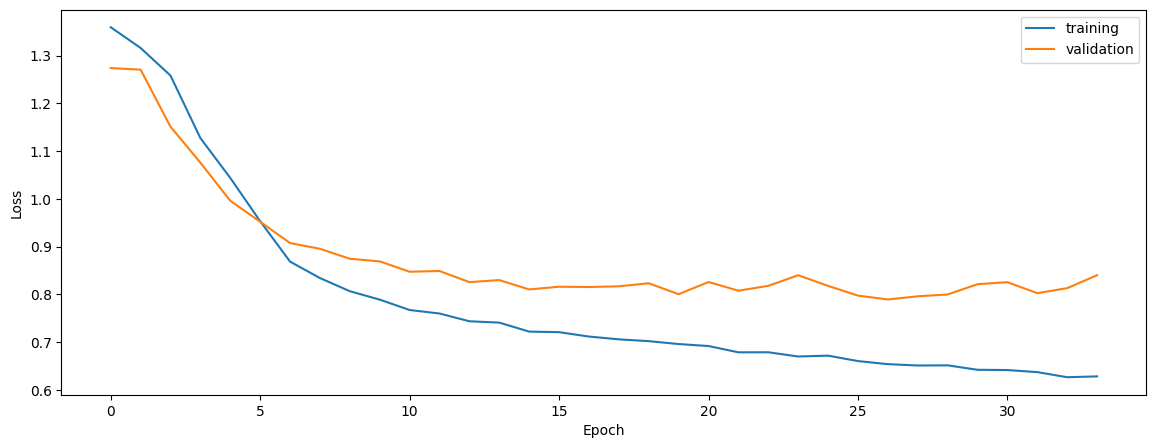

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuracy, predictInBatches

train.append(predictInBatches(model,train[0],architecture['batch_size']))
val.append(predictInBatches(model,val[0],architecture['batch_size']))
test.append(predictInBatches(model,test[0],architecture['batch_size']))

print('train')
print(getAccuracy(train[1],train[4]))
print(getAccuracy(val[1],val[4]))
print(getAccuracy(test[1],test[4]))

train
0.6126073009178127
0.6181728736209676
0.6299688502487331


In [8]:
print(props['space'])
print(getAccuracy(train[1],train[4],train[3][0]))
print(getAccuracy(val[1],val[4],val[3][0]))
print(getAccuracy(test[1],test[4],test[3][0]))

native
0.6132740459053218
0.6179799582434619
0.632156061580729


In [9]:
print('normalized' if props['space'] == 'native' else 'native')
print(getAccuracy(train[1][train[2]],train[4][train[2]],train[3][1]))
print(getAccuracy(val[1][val[2]],val[4][val[2]],val[3][1]))
print(getAccuracy(test[1][test[2]],test[4][test[2]],test[3][1]))

normalized
0.6253963501365788
0.6401718035268954
0.661180522987439


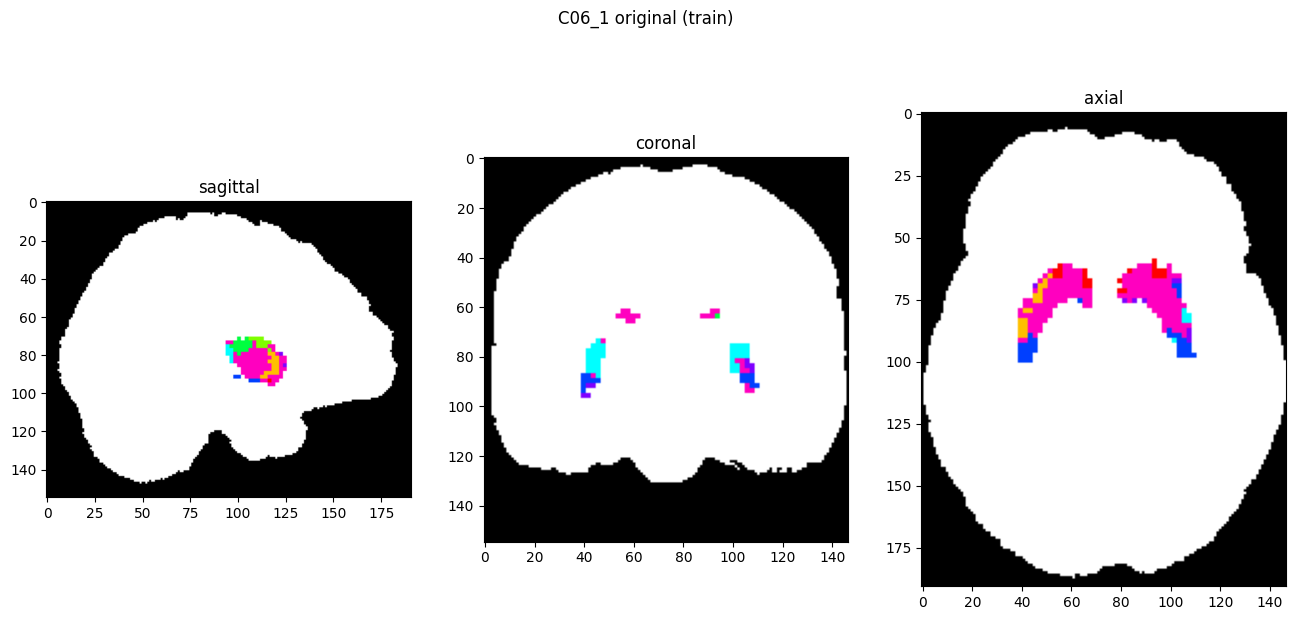

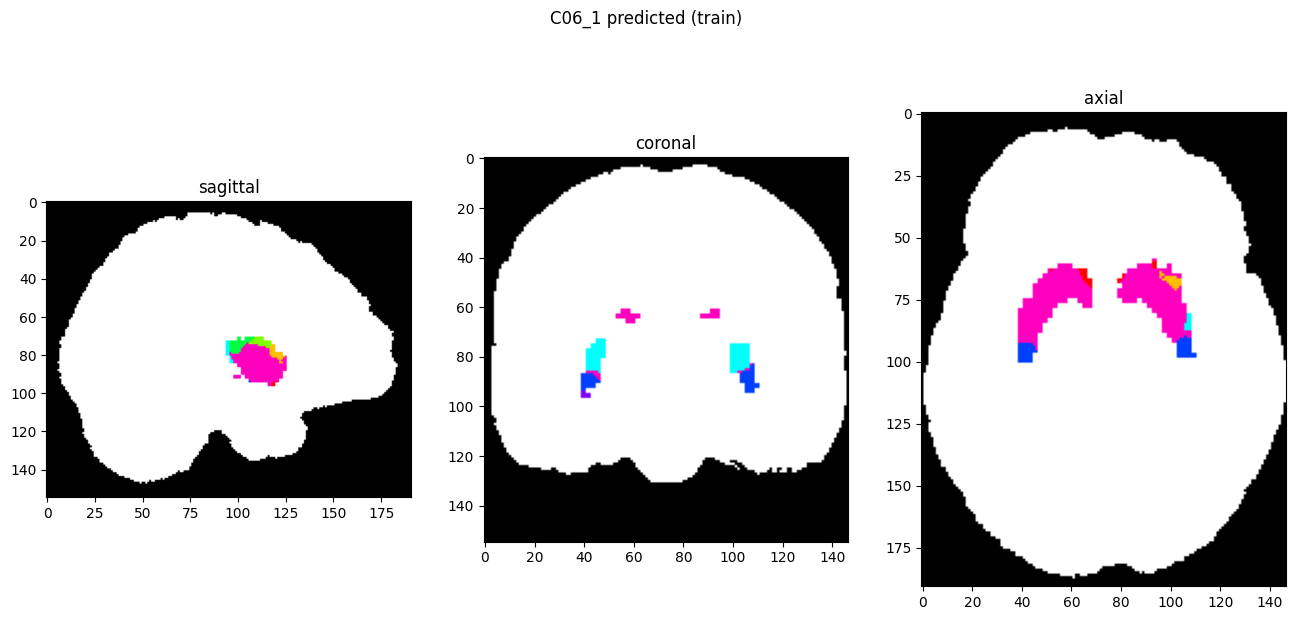

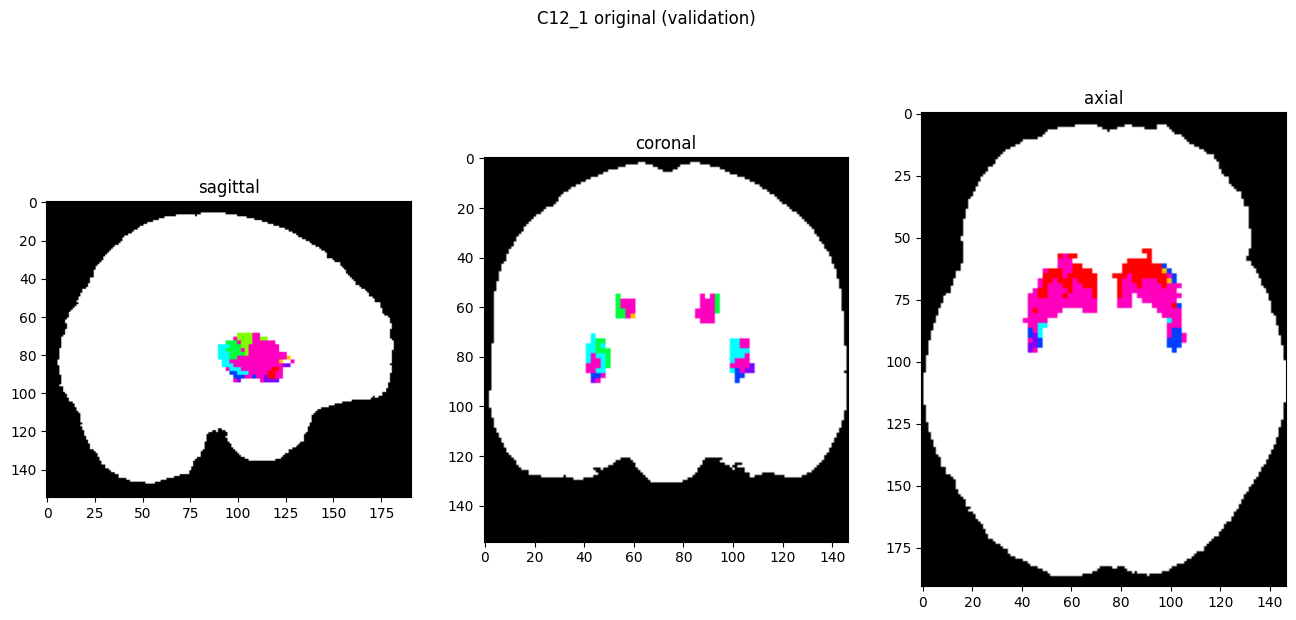

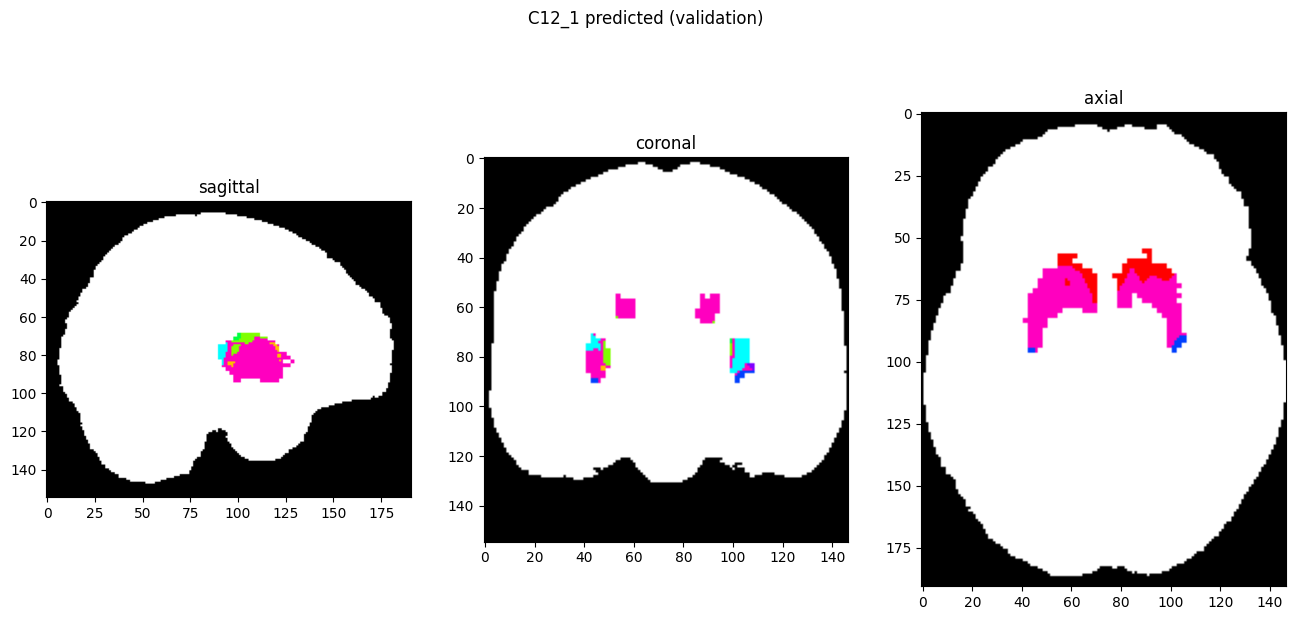

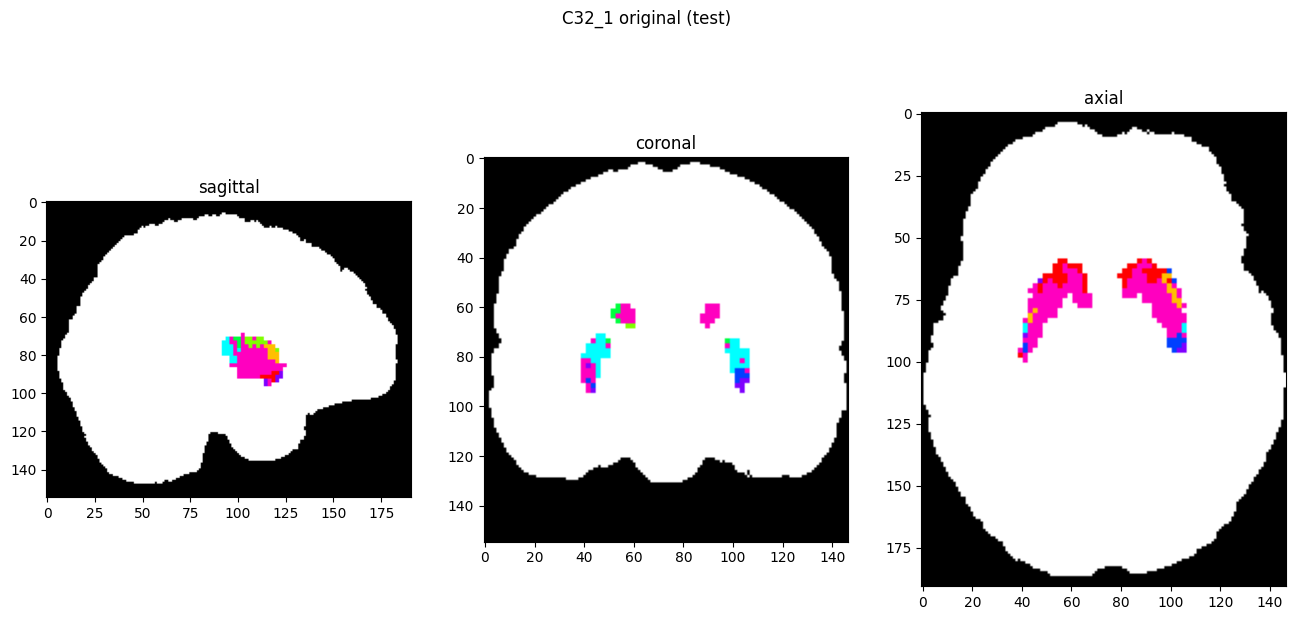

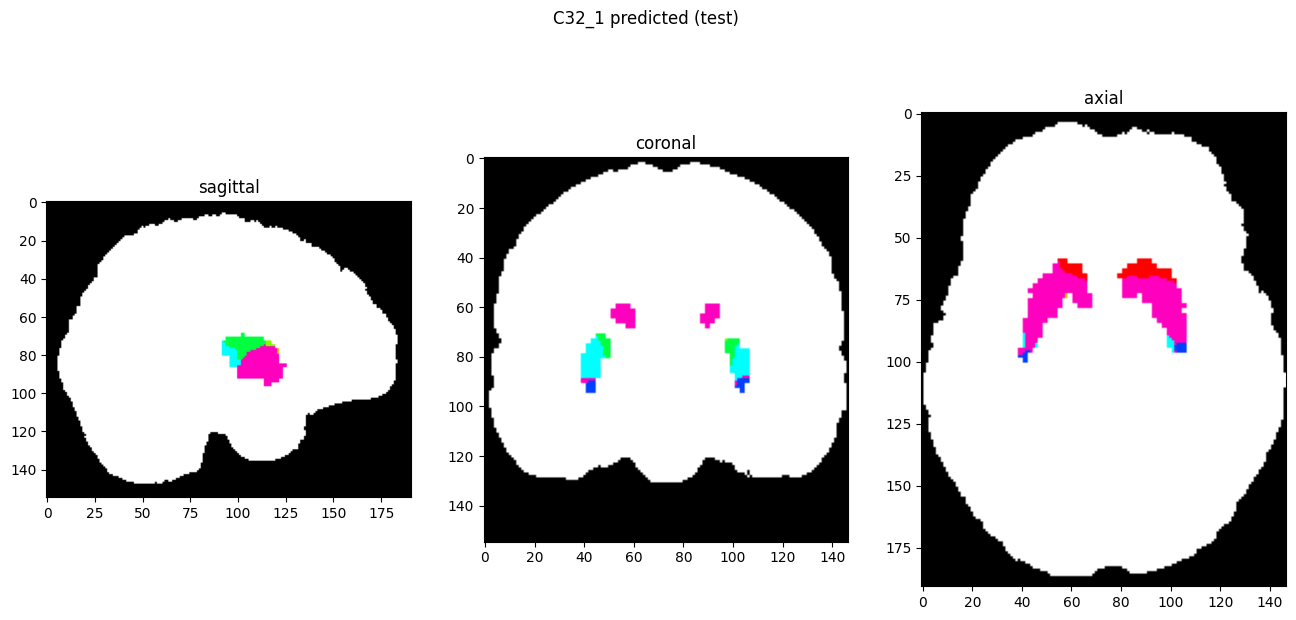

In [10]:
showResults(model, gen, threshold=0)